In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np
import cv2

## Original 1 channel image

In [4]:
import torch
from torchvision import transforms, datasets

data_transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
#         transforms.Lambda(lbp_transform),
#         transforms.Lambda(combine_lbp_hog),
#         transforms.ToPILImage(),
        # transforms.RandomSizedCrop(224),
#         transforms.RandomHorizontalFlip(),
#         transforms.RandomVerticalFlip(),
#         transforms.RandomRotation(degrees=180),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

train_fer = datasets.ImageFolder(root='/tf/data/Quan/fer2013/data/train', transform=data_transform)
val_fer = datasets.ImageFolder(root='/tf/data/Quan/fer2013/data/val', transform=data_transform)
test_fer = datasets.ImageFolder(root='/tf/data/Quan/fer2013/data/test', transform=data_transform)

batch_size = 128
train_loader = torch.utils.data.DataLoader(train_fer,
                                             batch_size=batch_size, shuffle=True,
                                             num_workers=8)
val_loader = torch.utils.data.DataLoader(val_fer,
                                             batch_size=batch_size, shuffle=True,
                                             num_workers=8)
test_loader = torch.utils.data.DataLoader(test_fer,
                                             batch_size=batch_size, shuffle=True,
                                             num_workers=8)

In [5]:
class WeightFeature(nn.Module):

    def __init__(self, feature_depth, target_depth):
        super(WeightFeature, self).__init__()

        self.target_depth = target_depth
#         self.conv1 = nn.Conv2d(feature_depth, feature_depth, kernel_size=feature_size, padding=0)
#         self.bn = nn.BatchNorm2d(feature_depth)
        self.fc1 = nn.Linear(feature_depth, target_depth)
        self.bn1 = nn.BatchNorm1d(target_depth)
        self.bn2 = nn.BatchNorm2d(target_depth)
        
    def forward(self, x1, x2):
        '''
        x1 -> GAP -> FC -> * with x2-> x2 --> out
        x2 ----------------------------|
        '''
        x1 = nn.AvgPool2d(kernel_size=(x1.size(-2), x1.size(-1)))(x1)
        x1 = nn.Flatten()(x1)

        x1 = self.fc1(x1)
#         x1 = nn.Dropout(0.6)(x1)
        x1 = self.bn1(x1)
        x1 = nn.Sigmoid()(x1)
#         x1 = nn.ReLU()(x1)
        x1 = x1.unsqueeze(-1).unsqueeze(-1)
        # print(x1.size())
        # x2 = self.conv1(x2)

        x_out = torch.mul(x2, x1)
        x_out = x_out + x2 
        x_out = self.bn2(x_out)

        return x_out

In [6]:
class SVblock(nn.Module):
    def __init__(self, in_neurons, nb_neurons, kernel_size=(3,3), batch_norm=True, activation='relu', **kwargs):
        '''
    in_neurons: C_in
    nb_neurons: n_filters of conv2d
    '''
        super(SVblock, self).__init__()
        
        self.device = torch.device('cpu') if not 'device' in kwargs else kwargs['device']
#         self.feature_size = kwargs['feature_size']

        self.index = kwargs['index'] if 'index' in kwargs else None
        self.conv1 = nn.Conv2d(in_neurons, nb_neurons, kernel_size=kernel_size, padding=1, stride=1)
        self.conv2 = nn.Conv2d(nb_neurons, nb_neurons, kernel_size=kernel_size, padding=1, stride=1)
        self.conv3 = nn.Conv2d(nb_neurons, nb_neurons, kernel_size=kernel_size, padding=1, stride=1)
#         self.conv4 = nn.Conv2d(nb_neurons, nb_neurons, kernel_size=kernel_size, padding=1, stride=1)
        self.wf1 = WeightFeature(nb_neurons, nb_neurons).to(self.device)
        self.wf2 = WeightFeature(nb_neurons, nb_neurons).to(self.device)
#         self.wf3 = WeightFeature(nb_neurons, nb_neurons).to(self.device)
        self.bn1 = nn.BatchNorm2d(nb_neurons)
        self.bn2 = nn.BatchNorm2d(nb_neurons)
        self.bn3 = nn.BatchNorm2d(nb_neurons)
#         self.bn4 = nn.BatchNorm2d(nb_neurons)
        self.relu = nn.ReLU()

        
    def forward(self, x):
        '''
        x: single output layer of list 
        '''

        x = torch.cat(x, dim=1) if type(x) is list else x

        # 1st
        x = self.conv1(x)
        x = self.bn1(x)
        x_res_1 = self.relu(x)

        # 2nd
        x = self.conv2(x_res_1)
        x = self.bn2(x)
        x2 = self.relu(x)
        
        x_res_2 = self.wf1(x_res_1, x2)

        # 3rd
        x = self.conv3(x_res_2)
        x = self.bn3(x)
        x_res_3 = self.relu(x)
        
        x_out = self.wf2(x2, x_res_3)

        return x_out

In [7]:
class SVGG(nn.Module):

    def __init__(self, **kwargs):
        super(SVGG, self).__init__()

        self.device = torch.device('cpu') if not 'device' in kwargs else kwargs['device']

        self.sv0 = SVblock(1,64).to(self.device)
        self.sv1 = SVblock(64, 128).to(self.device)
        self.sv2 = SVblock(128, 256).to(self.device)
        self.sv3 = SVblock(256, 512).to(self.device)
        self.sv4 = SVblock(512, 1024).to(self.device)


        self.fc1 = nn.Linear(1024, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 7)
        self.bn2 = nn.BatchNorm1d(7)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x0 = self.sv0(x)
        x0 = nn.MaxPool2d(kernel_size=(2,2), stride=2)(x0)
        
        x1 = self.sv1(x0)
        x1 = nn.MaxPool2d(kernel_size=(2,2), stride=2)(x1)
        
        x2 = self.sv2(x1)
        x2 = nn.MaxPool2d(kernel_size=(2,2), stride=2)(x2)
        
        x3 = self.sv3(x2)
        x3 = nn.MaxPool2d(kernel_size=(2,2), stride=2)(x3)
        
        x4 = self.sv4(x3)
        x4 = nn.MaxPool2d(kernel_size=(2,2), stride=2)(x4)
        
        x4 = nn.AvgPool2d(kernel_size=(x4.size(-2), x4.size(-1)))(x4)
        x_out = nn.Flatten()(x4)

        x_out = self.fc1(x_out)
        x_out = self.bn1(x_out)
        x_out = self.fc2(x_out)
        x_out = self.bn2(x_out)

        return x_out


In [6]:
device = torch.device('cuda')
print(device)

model = SVGG(device=device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)

# model.train()

# model = model.to(device)

cuda


In [8]:
model = model.to(device)

model_path = '/tf/data/Quan/fer2013/att_vgg_demo_2.pt'
best_acc = 0.0
hist = []

for epoch in range(60):  # loop over the dataset multiple times
    
    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0

    # TRAIN
    model.train()
    for i, data in enumerate(train_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        acc = float((torch.argmax(outputs, dim=1) == labels).float().sum()/labels.size(0))
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        running_acc += acc
        print('\t - Step %d: loss: %.3f acc: %.3f' % (i+1, loss.item(), acc))

    print('- Avg.loss: %.3f  | Avg.acc: %.3f' % (running_loss / (i+1), running_acc / (i+1)))
    avgloss = running_loss / (i+1)
    avgacc = running_acc / (i+1)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        acc = float((torch.argmax(outputs, dim=1) == labels).float().sum()/labels.size(0))
        loss = criterion(outputs, labels)

        running_valloss += loss.item()
        running_valacc += acc

    print('- Avg. val_loss: %.3f  | Avg. val_acc: %.3f' % (running_valloss / (i+1), running_valacc / (i+1)))

    avgvalloss = running_valloss / (i+1)
    avgvalcc = running_valacc / (i+1)

    hist.append([avgloss, avgvalloss, avgacc, avgvalcc])
    
    if best_acc < (running_valacc / (i+1)):
        best_acc = (running_valacc / (i+1))
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')

Epoch:  1
	 - Step 1: loss: 2.306 acc: 0.117
	 - Step 2: loss: 2.162 acc: 0.188
	 - Step 3: loss: 2.061 acc: 0.180
	 - Step 4: loss: 2.124 acc: 0.281
	 - Step 5: loss: 2.042 acc: 0.227
	 - Step 6: loss: 1.982 acc: 0.273
	 - Step 7: loss: 2.054 acc: 0.250
	 - Step 8: loss: 1.996 acc: 0.234
	 - Step 9: loss: 1.928 acc: 0.258
	 - Step 10: loss: 2.097 acc: 0.203
	 - Step 11: loss: 1.942 acc: 0.227
	 - Step 12: loss: 2.166 acc: 0.156
	 - Step 13: loss: 1.989 acc: 0.227
	 - Step 14: loss: 1.956 acc: 0.219
	 - Step 15: loss: 1.973 acc: 0.234
	 - Step 16: loss: 2.090 acc: 0.156
	 - Step 17: loss: 2.141 acc: 0.188
	 - Step 18: loss: 1.893 acc: 0.227
	 - Step 19: loss: 1.963 acc: 0.242
	 - Step 20: loss: 1.951 acc: 0.242
	 - Step 21: loss: 1.907 acc: 0.219
	 - Step 22: loss: 1.987 acc: 0.203
	 - Step 23: loss: 1.894 acc: 0.266
	 - Step 24: loss: 1.931 acc: 0.281
	 - Step 25: loss: 1.864 acc: 0.258
	 - Step 26: loss: 1.935 acc: 0.242
	 - Step 27: loss: 2.067 acc: 0.219
	 - Step 28: loss: 2.038 ac

- Avg. val_loss: 1.500  | Avg. val_acc: 0.455
* Update optimal model
Epoch:  2


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type SVGG. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type SVblock. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type WeightFeature. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


	 - Step 1: loss: 1.422 acc: 0.484
	 - Step 2: loss: 1.404 acc: 0.508
	 - Step 3: loss: 1.354 acc: 0.469
	 - Step 4: loss: 1.326 acc: 0.500
	 - Step 5: loss: 1.387 acc: 0.492
	 - Step 6: loss: 1.441 acc: 0.430
	 - Step 7: loss: 1.428 acc: 0.500
	 - Step 8: loss: 1.389 acc: 0.500
	 - Step 9: loss: 1.353 acc: 0.484
	 - Step 10: loss: 1.438 acc: 0.453
	 - Step 11: loss: 1.353 acc: 0.547
	 - Step 12: loss: 1.271 acc: 0.562
	 - Step 13: loss: 1.308 acc: 0.469
	 - Step 14: loss: 1.405 acc: 0.461
	 - Step 15: loss: 1.231 acc: 0.617
	 - Step 16: loss: 1.364 acc: 0.508
	 - Step 17: loss: 1.371 acc: 0.508
	 - Step 18: loss: 1.415 acc: 0.453
	 - Step 19: loss: 1.410 acc: 0.477
	 - Step 20: loss: 1.400 acc: 0.477
	 - Step 21: loss: 1.389 acc: 0.523
	 - Step 22: loss: 1.294 acc: 0.562
	 - Step 23: loss: 1.432 acc: 0.430
	 - Step 24: loss: 1.333 acc: 0.453
	 - Step 25: loss: 1.440 acc: 0.453
	 - Step 26: loss: 1.378 acc: 0.484
	 - Step 27: loss: 1.274 acc: 0.523
	 - Step 28: loss: 1.287 acc: 0.508
	

- Avg. val_loss: 1.295  | Avg. val_acc: 0.528
* Update optimal model
Epoch:  3
	 - Step 1: loss: 1.087 acc: 0.633
	 - Step 2: loss: 1.413 acc: 0.430
	 - Step 3: loss: 1.267 acc: 0.562
	 - Step 4: loss: 1.248 acc: 0.531
	 - Step 5: loss: 1.158 acc: 0.586
	 - Step 6: loss: 1.377 acc: 0.508
	 - Step 7: loss: 1.186 acc: 0.570
	 - Step 8: loss: 1.336 acc: 0.539
	 - Step 9: loss: 1.262 acc: 0.508
	 - Step 10: loss: 1.239 acc: 0.531
	 - Step 11: loss: 1.261 acc: 0.547
	 - Step 12: loss: 1.120 acc: 0.570
	 - Step 13: loss: 1.373 acc: 0.461
	 - Step 14: loss: 1.186 acc: 0.602
	 - Step 15: loss: 1.047 acc: 0.633
	 - Step 16: loss: 1.264 acc: 0.484
	 - Step 17: loss: 1.162 acc: 0.609
	 - Step 18: loss: 1.214 acc: 0.570
	 - Step 19: loss: 1.401 acc: 0.500
	 - Step 20: loss: 1.228 acc: 0.594
	 - Step 21: loss: 1.204 acc: 0.523
	 - Step 22: loss: 1.116 acc: 0.633
	 - Step 23: loss: 1.138 acc: 0.594
	 - Step 24: loss: 1.128 acc: 0.586
	 - Step 25: loss: 1.268 acc: 0.555
	 - Step 26: loss: 1.254 acc: 

	 - Step 225: loss: 1.014 acc: 0.595
- Avg.loss: 1.177  | Avg.acc: 0.572
- Avg. val_loss: 1.283  | Avg. val_acc: 0.502
Epoch:  4
	 - Step 1: loss: 0.955 acc: 0.688
	 - Step 2: loss: 1.197 acc: 0.578
	 - Step 3: loss: 1.115 acc: 0.586
	 - Step 4: loss: 1.162 acc: 0.562
	 - Step 5: loss: 0.991 acc: 0.672
	 - Step 6: loss: 1.193 acc: 0.555
	 - Step 7: loss: 1.219 acc: 0.570
	 - Step 8: loss: 1.132 acc: 0.570
	 - Step 9: loss: 1.088 acc: 0.633
	 - Step 10: loss: 1.130 acc: 0.555
	 - Step 11: loss: 1.113 acc: 0.578
	 - Step 12: loss: 1.217 acc: 0.570
	 - Step 13: loss: 1.154 acc: 0.602
	 - Step 14: loss: 1.033 acc: 0.641
	 - Step 15: loss: 1.221 acc: 0.516
	 - Step 16: loss: 0.989 acc: 0.633
	 - Step 17: loss: 1.215 acc: 0.555
	 - Step 18: loss: 1.090 acc: 0.617
	 - Step 19: loss: 1.161 acc: 0.523
	 - Step 20: loss: 1.113 acc: 0.570
	 - Step 21: loss: 0.975 acc: 0.672
	 - Step 22: loss: 1.024 acc: 0.672
	 - Step 23: loss: 1.302 acc: 0.570
	 - Step 24: loss: 1.082 acc: 0.609
	 - Step 25: los

	 - Step 223: loss: 1.169 acc: 0.555
	 - Step 224: loss: 1.036 acc: 0.633
	 - Step 225: loss: 0.931 acc: 0.703
- Avg.loss: 1.103  | Avg.acc: 0.600
- Avg. val_loss: 1.190  | Avg. val_acc: 0.571
* Update optimal model
Epoch:  5
	 - Step 1: loss: 1.004 acc: 0.648
	 - Step 2: loss: 0.994 acc: 0.703
	 - Step 3: loss: 0.955 acc: 0.688
	 - Step 4: loss: 0.937 acc: 0.641
	 - Step 5: loss: 0.972 acc: 0.633
	 - Step 6: loss: 1.098 acc: 0.586
	 - Step 7: loss: 1.051 acc: 0.617
	 - Step 8: loss: 1.038 acc: 0.664
	 - Step 9: loss: 0.909 acc: 0.648
	 - Step 10: loss: 1.066 acc: 0.609
	 - Step 11: loss: 1.113 acc: 0.586
	 - Step 12: loss: 1.006 acc: 0.656
	 - Step 13: loss: 1.082 acc: 0.602
	 - Step 14: loss: 1.099 acc: 0.625
	 - Step 15: loss: 0.965 acc: 0.672
	 - Step 16: loss: 0.917 acc: 0.672
	 - Step 17: loss: 0.998 acc: 0.664
	 - Step 18: loss: 0.982 acc: 0.656
	 - Step 19: loss: 1.040 acc: 0.656
	 - Step 20: loss: 0.951 acc: 0.664
	 - Step 21: loss: 1.099 acc: 0.633
	 - Step 22: loss: 1.115 ac

	 - Step 221: loss: 1.101 acc: 0.641
	 - Step 222: loss: 1.023 acc: 0.641
	 - Step 223: loss: 1.018 acc: 0.641
	 - Step 224: loss: 0.942 acc: 0.688
	 - Step 225: loss: 0.860 acc: 0.730
- Avg.loss: 1.055  | Avg.acc: 0.621
- Avg. val_loss: 1.217  | Avg. val_acc: 0.552
Epoch:  6
	 - Step 1: loss: 1.051 acc: 0.656
	 - Step 2: loss: 0.996 acc: 0.672
	 - Step 3: loss: 1.123 acc: 0.602
	 - Step 4: loss: 0.996 acc: 0.617
	 - Step 5: loss: 1.097 acc: 0.594
	 - Step 6: loss: 1.118 acc: 0.602
	 - Step 7: loss: 0.944 acc: 0.680
	 - Step 8: loss: 1.007 acc: 0.633
	 - Step 9: loss: 1.022 acc: 0.617
	 - Step 10: loss: 1.066 acc: 0.648
	 - Step 11: loss: 1.076 acc: 0.633
	 - Step 12: loss: 1.136 acc: 0.594
	 - Step 13: loss: 1.023 acc: 0.617
	 - Step 14: loss: 1.033 acc: 0.633
	 - Step 15: loss: 0.883 acc: 0.750
	 - Step 16: loss: 0.998 acc: 0.625
	 - Step 17: loss: 1.042 acc: 0.602
	 - Step 18: loss: 1.007 acc: 0.672
	 - Step 19: loss: 1.009 acc: 0.680
	 - Step 20: loss: 0.898 acc: 0.680
	 - Step 21:

	 - Step 219: loss: 1.025 acc: 0.672
	 - Step 220: loss: 1.174 acc: 0.531
	 - Step 221: loss: 0.922 acc: 0.664
	 - Step 222: loss: 1.124 acc: 0.625
	 - Step 223: loss: 1.099 acc: 0.570
	 - Step 224: loss: 0.989 acc: 0.617
	 - Step 225: loss: 0.846 acc: 0.649
- Avg.loss: 1.012  | Avg.acc: 0.635
- Avg. val_loss: 1.153  | Avg. val_acc: 0.574
* Update optimal model
Epoch:  7
	 - Step 1: loss: 0.981 acc: 0.641
	 - Step 2: loss: 0.813 acc: 0.750
	 - Step 3: loss: 0.889 acc: 0.656
	 - Step 4: loss: 0.928 acc: 0.680
	 - Step 5: loss: 0.966 acc: 0.656
	 - Step 6: loss: 0.925 acc: 0.641
	 - Step 7: loss: 1.153 acc: 0.570
	 - Step 8: loss: 0.897 acc: 0.695
	 - Step 9: loss: 0.996 acc: 0.609
	 - Step 10: loss: 0.931 acc: 0.656
	 - Step 11: loss: 1.055 acc: 0.625
	 - Step 12: loss: 0.782 acc: 0.727
	 - Step 13: loss: 0.946 acc: 0.680
	 - Step 14: loss: 0.818 acc: 0.766
	 - Step 15: loss: 1.004 acc: 0.625
	 - Step 16: loss: 0.838 acc: 0.703
	 - Step 17: loss: 0.912 acc: 0.664
	 - Step 18: loss: 0.89

	 - Step 217: loss: 0.891 acc: 0.656
	 - Step 218: loss: 1.010 acc: 0.617
	 - Step 219: loss: 0.965 acc: 0.695
	 - Step 220: loss: 0.957 acc: 0.609
	 - Step 221: loss: 0.958 acc: 0.648
	 - Step 222: loss: 1.001 acc: 0.617
	 - Step 223: loss: 1.061 acc: 0.656
	 - Step 224: loss: 0.863 acc: 0.656
	 - Step 225: loss: 0.943 acc: 0.649
- Avg.loss: 0.973  | Avg.acc: 0.650
- Avg. val_loss: 1.203  | Avg. val_acc: 0.567
Epoch:  8
	 - Step 1: loss: 0.782 acc: 0.766
	 - Step 2: loss: 0.890 acc: 0.703
	 - Step 3: loss: 1.041 acc: 0.641
	 - Step 4: loss: 0.860 acc: 0.680
	 - Step 5: loss: 0.890 acc: 0.719
	 - Step 6: loss: 1.089 acc: 0.594
	 - Step 7: loss: 0.891 acc: 0.695
	 - Step 8: loss: 0.938 acc: 0.703
	 - Step 9: loss: 0.923 acc: 0.641
	 - Step 10: loss: 0.809 acc: 0.711
	 - Step 11: loss: 0.916 acc: 0.633
	 - Step 12: loss: 0.874 acc: 0.742
	 - Step 13: loss: 0.871 acc: 0.672
	 - Step 14: loss: 0.859 acc: 0.734
	 - Step 15: loss: 0.911 acc: 0.688
	 - Step 16: loss: 0.943 acc: 0.672
	 - Step

	 - Step 215: loss: 0.975 acc: 0.672
	 - Step 216: loss: 0.852 acc: 0.672
	 - Step 217: loss: 0.871 acc: 0.625
	 - Step 218: loss: 0.921 acc: 0.680
	 - Step 219: loss: 0.917 acc: 0.648
	 - Step 220: loss: 0.930 acc: 0.656
	 - Step 221: loss: 0.934 acc: 0.656
	 - Step 222: loss: 0.897 acc: 0.664
	 - Step 223: loss: 0.764 acc: 0.734
	 - Step 224: loss: 0.861 acc: 0.711
	 - Step 225: loss: 1.450 acc: 0.432
- Avg.loss: 0.944  | Avg.acc: 0.662
- Avg. val_loss: 1.122  | Avg. val_acc: 0.593
* Update optimal model
Epoch:  9
	 - Step 1: loss: 0.815 acc: 0.719
	 - Step 2: loss: 0.832 acc: 0.719
	 - Step 3: loss: 0.785 acc: 0.742
	 - Step 4: loss: 0.997 acc: 0.711
	 - Step 5: loss: 0.753 acc: 0.734
	 - Step 6: loss: 0.916 acc: 0.688
	 - Step 7: loss: 0.841 acc: 0.734
	 - Step 8: loss: 0.897 acc: 0.703
	 - Step 9: loss: 0.803 acc: 0.734
	 - Step 10: loss: 0.909 acc: 0.672
	 - Step 11: loss: 0.879 acc: 0.711
	 - Step 12: loss: 0.721 acc: 0.742
	 - Step 13: loss: 0.780 acc: 0.703
	 - Step 14: loss: 

	 - Step 213: loss: 0.944 acc: 0.680
	 - Step 214: loss: 0.738 acc: 0.766
	 - Step 215: loss: 0.951 acc: 0.664
	 - Step 216: loss: 0.836 acc: 0.727
	 - Step 217: loss: 0.679 acc: 0.750
	 - Step 218: loss: 0.814 acc: 0.711
	 - Step 219: loss: 0.857 acc: 0.711
	 - Step 220: loss: 1.000 acc: 0.641
	 - Step 221: loss: 1.070 acc: 0.625
	 - Step 222: loss: 0.833 acc: 0.719
	 - Step 223: loss: 0.888 acc: 0.680
	 - Step 224: loss: 0.858 acc: 0.664
	 - Step 225: loss: 1.121 acc: 0.622
- Avg.loss: 0.901  | Avg.acc: 0.682
- Avg. val_loss: 1.089  | Avg. val_acc: 0.611
* Update optimal model
Epoch:  10
	 - Step 1: loss: 0.865 acc: 0.727
	 - Step 2: loss: 0.888 acc: 0.672
	 - Step 3: loss: 0.983 acc: 0.641
	 - Step 4: loss: 0.988 acc: 0.625
	 - Step 5: loss: 0.716 acc: 0.766
	 - Step 6: loss: 0.784 acc: 0.758
	 - Step 7: loss: 0.818 acc: 0.719
	 - Step 8: loss: 0.989 acc: 0.664
	 - Step 9: loss: 0.822 acc: 0.742
	 - Step 10: loss: 0.726 acc: 0.758
	 - Step 11: loss: 0.854 acc: 0.664
	 - Step 12: los

	 - Step 211: loss: 0.869 acc: 0.734
	 - Step 212: loss: 0.910 acc: 0.695
	 - Step 213: loss: 0.917 acc: 0.664
	 - Step 214: loss: 0.644 acc: 0.781
	 - Step 215: loss: 0.740 acc: 0.750
	 - Step 216: loss: 0.801 acc: 0.742
	 - Step 217: loss: 0.930 acc: 0.703
	 - Step 218: loss: 0.887 acc: 0.695
	 - Step 219: loss: 0.870 acc: 0.633
	 - Step 220: loss: 0.902 acc: 0.680
	 - Step 221: loss: 0.850 acc: 0.672
	 - Step 222: loss: 0.815 acc: 0.688
	 - Step 223: loss: 0.856 acc: 0.734
	 - Step 224: loss: 0.904 acc: 0.680
	 - Step 225: loss: 0.783 acc: 0.703
- Avg.loss: 0.873  | Avg.acc: 0.691
- Avg. val_loss: 1.186  | Avg. val_acc: 0.577
Epoch:  11
	 - Step 1: loss: 0.865 acc: 0.695
	 - Step 2: loss: 0.733 acc: 0.758
	 - Step 3: loss: 0.902 acc: 0.703
	 - Step 4: loss: 0.779 acc: 0.734
	 - Step 5: loss: 0.669 acc: 0.781
	 - Step 6: loss: 0.730 acc: 0.773
	 - Step 7: loss: 0.785 acc: 0.719
	 - Step 8: loss: 0.974 acc: 0.664
	 - Step 9: loss: 0.823 acc: 0.695
	 - Step 10: loss: 0.674 acc: 0.797
	

	 - Step 209: loss: 0.899 acc: 0.680
	 - Step 210: loss: 0.855 acc: 0.680
	 - Step 211: loss: 0.878 acc: 0.727
	 - Step 212: loss: 0.791 acc: 0.727
	 - Step 213: loss: 0.846 acc: 0.734
	 - Step 214: loss: 0.853 acc: 0.664
	 - Step 215: loss: 0.745 acc: 0.758
	 - Step 216: loss: 0.899 acc: 0.719
	 - Step 217: loss: 0.774 acc: 0.703
	 - Step 218: loss: 0.824 acc: 0.711
	 - Step 219: loss: 0.950 acc: 0.609
	 - Step 220: loss: 0.731 acc: 0.773
	 - Step 221: loss: 0.704 acc: 0.750
	 - Step 222: loss: 1.015 acc: 0.656
	 - Step 223: loss: 0.918 acc: 0.680
	 - Step 224: loss: 0.804 acc: 0.758
	 - Step 225: loss: 1.059 acc: 0.595
- Avg.loss: 0.825  | Avg.acc: 0.709
- Avg. val_loss: 1.086  | Avg. val_acc: 0.595
Epoch:  12
	 - Step 1: loss: 0.819 acc: 0.695
	 - Step 2: loss: 0.684 acc: 0.758
	 - Step 3: loss: 0.753 acc: 0.758
	 - Step 4: loss: 0.816 acc: 0.680
	 - Step 5: loss: 0.742 acc: 0.750
	 - Step 6: loss: 0.873 acc: 0.703
	 - Step 7: loss: 0.677 acc: 0.789
	 - Step 8: loss: 0.731 acc: 0.73

	 - Step 207: loss: 0.799 acc: 0.680
	 - Step 208: loss: 0.759 acc: 0.734
	 - Step 209: loss: 0.830 acc: 0.680
	 - Step 210: loss: 0.836 acc: 0.734
	 - Step 211: loss: 0.906 acc: 0.695
	 - Step 212: loss: 0.698 acc: 0.750
	 - Step 213: loss: 0.747 acc: 0.766
	 - Step 214: loss: 0.690 acc: 0.703
	 - Step 215: loss: 0.769 acc: 0.727
	 - Step 216: loss: 0.942 acc: 0.680
	 - Step 217: loss: 0.770 acc: 0.688
	 - Step 218: loss: 0.760 acc: 0.750
	 - Step 219: loss: 1.021 acc: 0.641
	 - Step 220: loss: 0.915 acc: 0.672
	 - Step 221: loss: 0.832 acc: 0.703
	 - Step 222: loss: 0.889 acc: 0.688
	 - Step 223: loss: 0.822 acc: 0.703
	 - Step 224: loss: 0.792 acc: 0.742
	 - Step 225: loss: 0.901 acc: 0.730
- Avg.loss: 0.796  | Avg.acc: 0.721
- Avg. val_loss: 1.065  | Avg. val_acc: 0.615
* Update optimal model
Epoch:  13
	 - Step 1: loss: 0.775 acc: 0.750
	 - Step 2: loss: 0.759 acc: 0.742
	 - Step 3: loss: 0.760 acc: 0.750
	 - Step 4: loss: 0.599 acc: 0.852
	 - Step 5: loss: 0.753 acc: 0.750
	 - St

	 - Step 205: loss: 0.766 acc: 0.719
	 - Step 206: loss: 0.717 acc: 0.758
	 - Step 207: loss: 0.749 acc: 0.750
	 - Step 208: loss: 0.875 acc: 0.680
	 - Step 209: loss: 0.770 acc: 0.711
	 - Step 210: loss: 0.760 acc: 0.742
	 - Step 211: loss: 0.826 acc: 0.727
	 - Step 212: loss: 0.924 acc: 0.680
	 - Step 213: loss: 0.830 acc: 0.688
	 - Step 214: loss: 0.886 acc: 0.664
	 - Step 215: loss: 0.738 acc: 0.742
	 - Step 216: loss: 0.903 acc: 0.656
	 - Step 217: loss: 0.798 acc: 0.703
	 - Step 218: loss: 0.820 acc: 0.695
	 - Step 219: loss: 0.803 acc: 0.750
	 - Step 220: loss: 0.734 acc: 0.766
	 - Step 221: loss: 0.735 acc: 0.742
	 - Step 222: loss: 0.719 acc: 0.758
	 - Step 223: loss: 0.724 acc: 0.742
	 - Step 224: loss: 0.850 acc: 0.688
	 - Step 225: loss: 0.926 acc: 0.730
- Avg.loss: 0.739  | Avg.acc: 0.744
- Avg. val_loss: 1.102  | Avg. val_acc: 0.601
Epoch:  14
	 - Step 1: loss: 0.583 acc: 0.820
	 - Step 2: loss: 0.573 acc: 0.820
	 - Step 3: loss: 0.706 acc: 0.758
	 - Step 4: loss: 0.614 a

	 - Step 203: loss: 0.784 acc: 0.742
	 - Step 204: loss: 0.884 acc: 0.688
	 - Step 205: loss: 0.703 acc: 0.742
	 - Step 206: loss: 0.724 acc: 0.766
	 - Step 207: loss: 0.733 acc: 0.719
	 - Step 208: loss: 0.773 acc: 0.711
	 - Step 209: loss: 0.705 acc: 0.758
	 - Step 210: loss: 0.822 acc: 0.750
	 - Step 211: loss: 0.728 acc: 0.734
	 - Step 212: loss: 0.705 acc: 0.758
	 - Step 213: loss: 0.617 acc: 0.742
	 - Step 214: loss: 0.626 acc: 0.789
	 - Step 215: loss: 0.600 acc: 0.750
	 - Step 216: loss: 0.609 acc: 0.781
	 - Step 217: loss: 0.725 acc: 0.719
	 - Step 218: loss: 0.674 acc: 0.750
	 - Step 219: loss: 0.937 acc: 0.672
	 - Step 220: loss: 0.628 acc: 0.805
	 - Step 221: loss: 0.847 acc: 0.727
	 - Step 222: loss: 0.811 acc: 0.719
	 - Step 223: loss: 0.701 acc: 0.766
	 - Step 224: loss: 0.737 acc: 0.727
	 - Step 225: loss: 0.538 acc: 0.757
- Avg.loss: 0.689  | Avg.acc: 0.762
- Avg. val_loss: 1.138  | Avg. val_acc: 0.603
Epoch:  15
	 - Step 1: loss: 0.624 acc: 0.812
	 - Step 2: loss: 0.5

	 - Step 201: loss: 0.701 acc: 0.766
	 - Step 202: loss: 0.630 acc: 0.789
	 - Step 203: loss: 0.776 acc: 0.727
	 - Step 204: loss: 0.761 acc: 0.734
	 - Step 205: loss: 0.597 acc: 0.852
	 - Step 206: loss: 0.780 acc: 0.695
	 - Step 207: loss: 0.930 acc: 0.688
	 - Step 208: loss: 0.737 acc: 0.742
	 - Step 209: loss: 0.686 acc: 0.750
	 - Step 210: loss: 0.635 acc: 0.789
	 - Step 211: loss: 0.625 acc: 0.789
	 - Step 212: loss: 0.719 acc: 0.750
	 - Step 213: loss: 0.663 acc: 0.750
	 - Step 214: loss: 0.674 acc: 0.742
	 - Step 215: loss: 0.737 acc: 0.734
	 - Step 216: loss: 0.699 acc: 0.742
	 - Step 217: loss: 0.765 acc: 0.750
	 - Step 218: loss: 0.629 acc: 0.812
	 - Step 219: loss: 0.576 acc: 0.812
	 - Step 220: loss: 0.629 acc: 0.797
	 - Step 221: loss: 0.596 acc: 0.828
	 - Step 222: loss: 0.633 acc: 0.812
	 - Step 223: loss: 0.670 acc: 0.766
	 - Step 224: loss: 0.614 acc: 0.766
	 - Step 225: loss: 0.864 acc: 0.622
- Avg.loss: 0.650  | Avg.acc: 0.779
- Avg. val_loss: 1.051  | Avg. val_acc:

	 - Step 199: loss: 0.480 acc: 0.828
	 - Step 200: loss: 0.506 acc: 0.797
	 - Step 201: loss: 0.647 acc: 0.820
	 - Step 202: loss: 0.666 acc: 0.773
	 - Step 203: loss: 0.462 acc: 0.852
	 - Step 204: loss: 0.605 acc: 0.812
	 - Step 205: loss: 0.710 acc: 0.758
	 - Step 206: loss: 0.669 acc: 0.797
	 - Step 207: loss: 0.607 acc: 0.812
	 - Step 208: loss: 0.590 acc: 0.781
	 - Step 209: loss: 0.725 acc: 0.766
	 - Step 210: loss: 0.632 acc: 0.773
	 - Step 211: loss: 0.549 acc: 0.805
	 - Step 212: loss: 0.589 acc: 0.789
	 - Step 213: loss: 0.464 acc: 0.844
	 - Step 214: loss: 0.663 acc: 0.781
	 - Step 215: loss: 0.775 acc: 0.727
	 - Step 216: loss: 0.580 acc: 0.812
	 - Step 217: loss: 0.536 acc: 0.844
	 - Step 218: loss: 0.660 acc: 0.742
	 - Step 219: loss: 0.564 acc: 0.781
	 - Step 220: loss: 0.658 acc: 0.797
	 - Step 221: loss: 0.614 acc: 0.789
	 - Step 222: loss: 0.602 acc: 0.805
	 - Step 223: loss: 0.642 acc: 0.789
	 - Step 224: loss: 0.650 acc: 0.781
	 - Step 225: loss: 0.623 acc: 0.784
-

	 - Step 197: loss: 0.585 acc: 0.797
	 - Step 198: loss: 0.628 acc: 0.781
	 - Step 199: loss: 0.643 acc: 0.773
	 - Step 200: loss: 0.613 acc: 0.789
	 - Step 201: loss: 0.541 acc: 0.797
	 - Step 202: loss: 0.498 acc: 0.844
	 - Step 203: loss: 0.751 acc: 0.750
	 - Step 204: loss: 0.491 acc: 0.844
	 - Step 205: loss: 0.554 acc: 0.812
	 - Step 206: loss: 0.503 acc: 0.867
	 - Step 207: loss: 0.560 acc: 0.828
	 - Step 208: loss: 0.431 acc: 0.852
	 - Step 209: loss: 0.538 acc: 0.812
	 - Step 210: loss: 0.552 acc: 0.852
	 - Step 211: loss: 0.617 acc: 0.812
	 - Step 212: loss: 0.565 acc: 0.812
	 - Step 213: loss: 0.638 acc: 0.805
	 - Step 214: loss: 0.617 acc: 0.766
	 - Step 215: loss: 0.640 acc: 0.773
	 - Step 216: loss: 0.906 acc: 0.711
	 - Step 217: loss: 0.648 acc: 0.742
	 - Step 218: loss: 0.636 acc: 0.773
	 - Step 219: loss: 0.465 acc: 0.852
	 - Step 220: loss: 0.617 acc: 0.781
	 - Step 221: loss: 0.418 acc: 0.820
	 - Step 222: loss: 0.641 acc: 0.773
	 - Step 223: loss: 0.426 acc: 0.844
	

	 - Step 195: loss: 0.453 acc: 0.844
	 - Step 196: loss: 0.616 acc: 0.781
	 - Step 197: loss: 0.574 acc: 0.828
	 - Step 198: loss: 0.623 acc: 0.789
	 - Step 199: loss: 0.417 acc: 0.875
	 - Step 200: loss: 0.665 acc: 0.766
	 - Step 201: loss: 0.546 acc: 0.836
	 - Step 202: loss: 0.617 acc: 0.781
	 - Step 203: loss: 0.533 acc: 0.844
	 - Step 204: loss: 0.470 acc: 0.844
	 - Step 205: loss: 0.494 acc: 0.828
	 - Step 206: loss: 0.555 acc: 0.773
	 - Step 207: loss: 0.675 acc: 0.797
	 - Step 208: loss: 0.579 acc: 0.773
	 - Step 209: loss: 0.649 acc: 0.836
	 - Step 210: loss: 0.590 acc: 0.820
	 - Step 211: loss: 0.529 acc: 0.852
	 - Step 212: loss: 0.441 acc: 0.859
	 - Step 213: loss: 0.495 acc: 0.805
	 - Step 214: loss: 0.544 acc: 0.812
	 - Step 215: loss: 0.577 acc: 0.797
	 - Step 216: loss: 0.724 acc: 0.750
	 - Step 217: loss: 0.758 acc: 0.750
	 - Step 218: loss: 0.632 acc: 0.797
	 - Step 219: loss: 0.493 acc: 0.844
	 - Step 220: loss: 0.503 acc: 0.828
	 - Step 221: loss: 0.604 acc: 0.766
	

	 - Step 193: loss: 0.511 acc: 0.805
	 - Step 194: loss: 0.479 acc: 0.875
	 - Step 195: loss: 0.367 acc: 0.898
	 - Step 196: loss: 0.490 acc: 0.812
	 - Step 197: loss: 0.425 acc: 0.852
	 - Step 198: loss: 0.449 acc: 0.828
	 - Step 199: loss: 0.546 acc: 0.812
	 - Step 200: loss: 0.486 acc: 0.828
	 - Step 201: loss: 0.526 acc: 0.859
	 - Step 202: loss: 0.557 acc: 0.820
	 - Step 203: loss: 0.467 acc: 0.844
	 - Step 204: loss: 0.530 acc: 0.836
	 - Step 205: loss: 0.481 acc: 0.828
	 - Step 206: loss: 0.557 acc: 0.836
	 - Step 207: loss: 0.605 acc: 0.789
	 - Step 208: loss: 0.596 acc: 0.789
	 - Step 209: loss: 0.528 acc: 0.812
	 - Step 210: loss: 0.498 acc: 0.828
	 - Step 211: loss: 0.519 acc: 0.828
	 - Step 212: loss: 0.539 acc: 0.805
	 - Step 213: loss: 0.635 acc: 0.758
	 - Step 214: loss: 0.640 acc: 0.797
	 - Step 215: loss: 0.493 acc: 0.828
	 - Step 216: loss: 0.566 acc: 0.852
	 - Step 217: loss: 0.608 acc: 0.805
	 - Step 218: loss: 0.408 acc: 0.891
	 - Step 219: loss: 0.591 acc: 0.812
	

	 - Step 191: loss: 0.391 acc: 0.836
	 - Step 192: loss: 0.355 acc: 0.883
	 - Step 193: loss: 0.499 acc: 0.852
	 - Step 194: loss: 0.356 acc: 0.875
	 - Step 195: loss: 0.508 acc: 0.852
	 - Step 196: loss: 0.485 acc: 0.836
	 - Step 197: loss: 0.408 acc: 0.852
	 - Step 198: loss: 0.359 acc: 0.867
	 - Step 199: loss: 0.369 acc: 0.867
	 - Step 200: loss: 0.445 acc: 0.836
	 - Step 201: loss: 0.502 acc: 0.828
	 - Step 202: loss: 0.691 acc: 0.781
	 - Step 203: loss: 0.430 acc: 0.883
	 - Step 204: loss: 0.503 acc: 0.812
	 - Step 205: loss: 0.435 acc: 0.844
	 - Step 206: loss: 0.335 acc: 0.875
	 - Step 207: loss: 0.538 acc: 0.758
	 - Step 208: loss: 0.607 acc: 0.812
	 - Step 209: loss: 0.515 acc: 0.828
	 - Step 210: loss: 0.351 acc: 0.852
	 - Step 211: loss: 0.504 acc: 0.836
	 - Step 212: loss: 0.392 acc: 0.891
	 - Step 213: loss: 0.477 acc: 0.852
	 - Step 214: loss: 0.453 acc: 0.875
	 - Step 215: loss: 0.286 acc: 0.914
	 - Step 216: loss: 0.486 acc: 0.805
	 - Step 217: loss: 0.491 acc: 0.844
	

	 - Step 189: loss: 0.454 acc: 0.836
	 - Step 190: loss: 0.439 acc: 0.859
	 - Step 191: loss: 0.521 acc: 0.805
	 - Step 192: loss: 0.441 acc: 0.820
	 - Step 193: loss: 0.291 acc: 0.906
	 - Step 194: loss: 0.386 acc: 0.891
	 - Step 195: loss: 0.357 acc: 0.867
	 - Step 196: loss: 0.445 acc: 0.828
	 - Step 197: loss: 0.472 acc: 0.820
	 - Step 198: loss: 0.470 acc: 0.859
	 - Step 199: loss: 0.464 acc: 0.836
	 - Step 200: loss: 0.558 acc: 0.867
	 - Step 201: loss: 0.531 acc: 0.797
	 - Step 202: loss: 0.587 acc: 0.797
	 - Step 203: loss: 0.378 acc: 0.891
	 - Step 204: loss: 0.336 acc: 0.883
	 - Step 205: loss: 0.559 acc: 0.836
	 - Step 206: loss: 0.475 acc: 0.844
	 - Step 207: loss: 0.508 acc: 0.836
	 - Step 208: loss: 0.341 acc: 0.867
	 - Step 209: loss: 0.517 acc: 0.844
	 - Step 210: loss: 0.422 acc: 0.883
	 - Step 211: loss: 0.584 acc: 0.820
	 - Step 212: loss: 0.360 acc: 0.875
	 - Step 213: loss: 0.567 acc: 0.805
	 - Step 214: loss: 0.400 acc: 0.883
	 - Step 215: loss: 0.409 acc: 0.852
	

	 - Step 187: loss: 0.304 acc: 0.914
	 - Step 188: loss: 0.527 acc: 0.867
	 - Step 189: loss: 0.277 acc: 0.922
	 - Step 190: loss: 0.300 acc: 0.914
	 - Step 191: loss: 0.355 acc: 0.914
	 - Step 192: loss: 0.475 acc: 0.844
	 - Step 193: loss: 0.226 acc: 0.938
	 - Step 194: loss: 0.216 acc: 0.945
	 - Step 195: loss: 0.334 acc: 0.898
	 - Step 196: loss: 0.387 acc: 0.867
	 - Step 197: loss: 0.295 acc: 0.898
	 - Step 198: loss: 0.396 acc: 0.859
	 - Step 199: loss: 0.373 acc: 0.883
	 - Step 200: loss: 0.408 acc: 0.891
	 - Step 201: loss: 0.408 acc: 0.875
	 - Step 202: loss: 0.335 acc: 0.898
	 - Step 203: loss: 0.390 acc: 0.883
	 - Step 204: loss: 0.418 acc: 0.867
	 - Step 205: loss: 0.350 acc: 0.898
	 - Step 206: loss: 0.254 acc: 0.930
	 - Step 207: loss: 0.405 acc: 0.906
	 - Step 208: loss: 0.359 acc: 0.898
	 - Step 209: loss: 0.607 acc: 0.812
	 - Step 210: loss: 0.466 acc: 0.867
	 - Step 211: loss: 0.342 acc: 0.898
	 - Step 212: loss: 0.371 acc: 0.898
	 - Step 213: loss: 0.292 acc: 0.898
	

	 - Step 185: loss: 0.378 acc: 0.922
	 - Step 186: loss: 0.391 acc: 0.867
	 - Step 187: loss: 0.475 acc: 0.844
	 - Step 188: loss: 0.367 acc: 0.875
	 - Step 189: loss: 0.377 acc: 0.883
	 - Step 190: loss: 0.377 acc: 0.898
	 - Step 191: loss: 0.350 acc: 0.859
	 - Step 192: loss: 0.341 acc: 0.906
	 - Step 193: loss: 0.465 acc: 0.867
	 - Step 194: loss: 0.367 acc: 0.891
	 - Step 195: loss: 0.217 acc: 0.930
	 - Step 196: loss: 0.371 acc: 0.867
	 - Step 197: loss: 0.322 acc: 0.891
	 - Step 198: loss: 0.475 acc: 0.844
	 - Step 199: loss: 0.415 acc: 0.859
	 - Step 200: loss: 0.449 acc: 0.844
	 - Step 201: loss: 0.292 acc: 0.891
	 - Step 202: loss: 0.429 acc: 0.836
	 - Step 203: loss: 0.284 acc: 0.906
	 - Step 204: loss: 0.352 acc: 0.875
	 - Step 205: loss: 0.296 acc: 0.906
	 - Step 206: loss: 0.311 acc: 0.883
	 - Step 207: loss: 0.432 acc: 0.867
	 - Step 208: loss: 0.382 acc: 0.867
	 - Step 209: loss: 0.414 acc: 0.875
	 - Step 210: loss: 0.364 acc: 0.852
	 - Step 211: loss: 0.348 acc: 0.883
	

	 - Step 183: loss: 0.303 acc: 0.875
	 - Step 184: loss: 0.225 acc: 0.945
	 - Step 185: loss: 0.431 acc: 0.852
	 - Step 186: loss: 0.357 acc: 0.875
	 - Step 187: loss: 0.325 acc: 0.891
	 - Step 188: loss: 0.399 acc: 0.859
	 - Step 189: loss: 0.406 acc: 0.859
	 - Step 190: loss: 0.549 acc: 0.828
	 - Step 191: loss: 0.325 acc: 0.906
	 - Step 192: loss: 0.490 acc: 0.836
	 - Step 193: loss: 0.252 acc: 0.922
	 - Step 194: loss: 0.411 acc: 0.875
	 - Step 195: loss: 0.268 acc: 0.922
	 - Step 196: loss: 0.250 acc: 0.906
	 - Step 197: loss: 0.344 acc: 0.891
	 - Step 198: loss: 0.317 acc: 0.883
	 - Step 199: loss: 0.433 acc: 0.867
	 - Step 200: loss: 0.493 acc: 0.867
	 - Step 201: loss: 0.284 acc: 0.898
	 - Step 202: loss: 0.382 acc: 0.852
	 - Step 203: loss: 0.420 acc: 0.852
	 - Step 204: loss: 0.288 acc: 0.898
	 - Step 205: loss: 0.483 acc: 0.836
	 - Step 206: loss: 0.293 acc: 0.922
	 - Step 207: loss: 0.402 acc: 0.891
	 - Step 208: loss: 0.319 acc: 0.898
	 - Step 209: loss: 0.376 acc: 0.914
	

	 - Step 181: loss: 0.309 acc: 0.898
	 - Step 182: loss: 0.358 acc: 0.906
	 - Step 183: loss: 0.287 acc: 0.914
	 - Step 184: loss: 0.482 acc: 0.859
	 - Step 185: loss: 0.425 acc: 0.852
	 - Step 186: loss: 0.355 acc: 0.867
	 - Step 187: loss: 0.274 acc: 0.914
	 - Step 188: loss: 0.271 acc: 0.922
	 - Step 189: loss: 0.418 acc: 0.883
	 - Step 190: loss: 0.277 acc: 0.914
	 - Step 191: loss: 0.261 acc: 0.922
	 - Step 192: loss: 0.298 acc: 0.922
	 - Step 193: loss: 0.225 acc: 0.906
	 - Step 194: loss: 0.535 acc: 0.820
	 - Step 195: loss: 0.263 acc: 0.906
	 - Step 196: loss: 0.475 acc: 0.852
	 - Step 197: loss: 0.378 acc: 0.891
	 - Step 198: loss: 0.465 acc: 0.859
	 - Step 199: loss: 0.413 acc: 0.867
	 - Step 200: loss: 0.298 acc: 0.906
	 - Step 201: loss: 0.286 acc: 0.898
	 - Step 202: loss: 0.444 acc: 0.883
	 - Step 203: loss: 0.387 acc: 0.875
	 - Step 204: loss: 0.358 acc: 0.875
	 - Step 205: loss: 0.311 acc: 0.898
	 - Step 206: loss: 0.386 acc: 0.867
	 - Step 207: loss: 0.460 acc: 0.852
	

	 - Step 179: loss: 0.266 acc: 0.914
	 - Step 180: loss: 0.244 acc: 0.938
	 - Step 181: loss: 0.474 acc: 0.867
	 - Step 182: loss: 0.239 acc: 0.914
	 - Step 183: loss: 0.253 acc: 0.922
	 - Step 184: loss: 0.259 acc: 0.891
	 - Step 185: loss: 0.275 acc: 0.914
	 - Step 186: loss: 0.356 acc: 0.867
	 - Step 187: loss: 0.340 acc: 0.875
	 - Step 188: loss: 0.306 acc: 0.891
	 - Step 189: loss: 0.329 acc: 0.875
	 - Step 190: loss: 0.263 acc: 0.922
	 - Step 191: loss: 0.390 acc: 0.852
	 - Step 192: loss: 0.298 acc: 0.906
	 - Step 193: loss: 0.391 acc: 0.859
	 - Step 194: loss: 0.335 acc: 0.875
	 - Step 195: loss: 0.372 acc: 0.867
	 - Step 196: loss: 0.294 acc: 0.883
	 - Step 197: loss: 0.328 acc: 0.898
	 - Step 198: loss: 0.327 acc: 0.898
	 - Step 199: loss: 0.351 acc: 0.883
	 - Step 200: loss: 0.383 acc: 0.883
	 - Step 201: loss: 0.403 acc: 0.867
	 - Step 202: loss: 0.332 acc: 0.875
	 - Step 203: loss: 0.299 acc: 0.867
	 - Step 204: loss: 0.572 acc: 0.828
	 - Step 205: loss: 0.351 acc: 0.844
	

	 - Step 177: loss: 0.269 acc: 0.898
	 - Step 178: loss: 0.280 acc: 0.922
	 - Step 179: loss: 0.194 acc: 0.945
	 - Step 180: loss: 0.247 acc: 0.930
	 - Step 181: loss: 0.327 acc: 0.891
	 - Step 182: loss: 0.302 acc: 0.875
	 - Step 183: loss: 0.218 acc: 0.938
	 - Step 184: loss: 0.288 acc: 0.930
	 - Step 185: loss: 0.281 acc: 0.883
	 - Step 186: loss: 0.326 acc: 0.891
	 - Step 187: loss: 0.245 acc: 0.922
	 - Step 188: loss: 0.263 acc: 0.938
	 - Step 189: loss: 0.241 acc: 0.930
	 - Step 190: loss: 0.337 acc: 0.875
	 - Step 191: loss: 0.369 acc: 0.883
	 - Step 192: loss: 0.228 acc: 0.945
	 - Step 193: loss: 0.329 acc: 0.922
	 - Step 194: loss: 0.374 acc: 0.883
	 - Step 195: loss: 0.199 acc: 0.922
	 - Step 196: loss: 0.234 acc: 0.945
	 - Step 197: loss: 0.241 acc: 0.938
	 - Step 198: loss: 0.209 acc: 0.914
	 - Step 199: loss: 0.242 acc: 0.930
	 - Step 200: loss: 0.241 acc: 0.953
	 - Step 201: loss: 0.337 acc: 0.898
	 - Step 202: loss: 0.211 acc: 0.938
	 - Step 203: loss: 0.275 acc: 0.914
	

	 - Step 175: loss: 0.233 acc: 0.930
	 - Step 176: loss: 0.216 acc: 0.945
	 - Step 177: loss: 0.339 acc: 0.867
	 - Step 178: loss: 0.221 acc: 0.938
	 - Step 179: loss: 0.236 acc: 0.938
	 - Step 180: loss: 0.196 acc: 0.945
	 - Step 181: loss: 0.284 acc: 0.914
	 - Step 182: loss: 0.202 acc: 0.930
	 - Step 183: loss: 0.261 acc: 0.914
	 - Step 184: loss: 0.206 acc: 0.953
	 - Step 185: loss: 0.333 acc: 0.875
	 - Step 186: loss: 0.251 acc: 0.914
	 - Step 187: loss: 0.183 acc: 0.938
	 - Step 188: loss: 0.284 acc: 0.938
	 - Step 189: loss: 0.229 acc: 0.938
	 - Step 190: loss: 0.338 acc: 0.906
	 - Step 191: loss: 0.235 acc: 0.898
	 - Step 192: loss: 0.165 acc: 0.945
	 - Step 193: loss: 0.202 acc: 0.938
	 - Step 194: loss: 0.228 acc: 0.930
	 - Step 195: loss: 0.303 acc: 0.898
	 - Step 196: loss: 0.283 acc: 0.922
	 - Step 197: loss: 0.134 acc: 0.953
	 - Step 198: loss: 0.123 acc: 0.961
	 - Step 199: loss: 0.248 acc: 0.898
	 - Step 200: loss: 0.219 acc: 0.930
	 - Step 201: loss: 0.273 acc: 0.875
	

	 - Step 173: loss: 0.198 acc: 0.906
	 - Step 174: loss: 0.365 acc: 0.844
	 - Step 175: loss: 0.108 acc: 0.969
	 - Step 176: loss: 0.377 acc: 0.883
	 - Step 177: loss: 0.256 acc: 0.906
	 - Step 178: loss: 0.160 acc: 0.938
	 - Step 179: loss: 0.184 acc: 0.930
	 - Step 180: loss: 0.313 acc: 0.930
	 - Step 181: loss: 0.235 acc: 0.938
	 - Step 182: loss: 0.198 acc: 0.922
	 - Step 183: loss: 0.348 acc: 0.891
	 - Step 184: loss: 0.340 acc: 0.891
	 - Step 185: loss: 0.275 acc: 0.898
	 - Step 186: loss: 0.225 acc: 0.914
	 - Step 187: loss: 0.198 acc: 0.922
	 - Step 188: loss: 0.196 acc: 0.938
	 - Step 189: loss: 0.342 acc: 0.914
	 - Step 190: loss: 0.339 acc: 0.898
	 - Step 191: loss: 0.340 acc: 0.898
	 - Step 192: loss: 0.284 acc: 0.898
	 - Step 193: loss: 0.177 acc: 0.945
	 - Step 194: loss: 0.333 acc: 0.875
	 - Step 195: loss: 0.267 acc: 0.891
	 - Step 196: loss: 0.269 acc: 0.898
	 - Step 197: loss: 0.324 acc: 0.891
	 - Step 198: loss: 0.225 acc: 0.906
	 - Step 199: loss: 0.394 acc: 0.867
	

	 - Step 171: loss: 0.301 acc: 0.906
	 - Step 172: loss: 0.255 acc: 0.938
	 - Step 173: loss: 0.304 acc: 0.906
	 - Step 174: loss: 0.271 acc: 0.906
	 - Step 175: loss: 0.227 acc: 0.906
	 - Step 176: loss: 0.201 acc: 0.930
	 - Step 177: loss: 0.385 acc: 0.883
	 - Step 178: loss: 0.294 acc: 0.906
	 - Step 179: loss: 0.229 acc: 0.930
	 - Step 180: loss: 0.219 acc: 0.930
	 - Step 181: loss: 0.199 acc: 0.930
	 - Step 182: loss: 0.332 acc: 0.906
	 - Step 183: loss: 0.265 acc: 0.914
	 - Step 184: loss: 0.320 acc: 0.891
	 - Step 185: loss: 0.239 acc: 0.922
	 - Step 186: loss: 0.347 acc: 0.891
	 - Step 187: loss: 0.271 acc: 0.906
	 - Step 188: loss: 0.400 acc: 0.883
	 - Step 189: loss: 0.213 acc: 0.922
	 - Step 190: loss: 0.339 acc: 0.883
	 - Step 191: loss: 0.205 acc: 0.930
	 - Step 192: loss: 0.206 acc: 0.945
	 - Step 193: loss: 0.188 acc: 0.969
	 - Step 194: loss: 0.270 acc: 0.898
	 - Step 195: loss: 0.259 acc: 0.930
	 - Step 196: loss: 0.279 acc: 0.906
	 - Step 197: loss: 0.273 acc: 0.914
	

	 - Step 169: loss: 0.202 acc: 0.930
	 - Step 170: loss: 0.335 acc: 0.898
	 - Step 171: loss: 0.355 acc: 0.906
	 - Step 172: loss: 0.196 acc: 0.930
	 - Step 173: loss: 0.343 acc: 0.891
	 - Step 174: loss: 0.232 acc: 0.891
	 - Step 175: loss: 0.191 acc: 0.945
	 - Step 176: loss: 0.165 acc: 0.961
	 - Step 177: loss: 0.228 acc: 0.945
	 - Step 178: loss: 0.173 acc: 0.953
	 - Step 179: loss: 0.286 acc: 0.883
	 - Step 180: loss: 0.538 acc: 0.836
	 - Step 181: loss: 0.278 acc: 0.914
	 - Step 182: loss: 0.238 acc: 0.922
	 - Step 183: loss: 0.236 acc: 0.914
	 - Step 184: loss: 0.276 acc: 0.914
	 - Step 185: loss: 0.253 acc: 0.906
	 - Step 186: loss: 0.259 acc: 0.914
	 - Step 187: loss: 0.236 acc: 0.930
	 - Step 188: loss: 0.307 acc: 0.906
	 - Step 189: loss: 0.271 acc: 0.914
	 - Step 190: loss: 0.317 acc: 0.930
	 - Step 191: loss: 0.268 acc: 0.930
	 - Step 192: loss: 0.319 acc: 0.883
	 - Step 193: loss: 0.212 acc: 0.945
	 - Step 194: loss: 0.177 acc: 0.945
	 - Step 195: loss: 0.152 acc: 0.945
	

	 - Step 167: loss: 0.201 acc: 0.938
	 - Step 168: loss: 0.188 acc: 0.953
	 - Step 169: loss: 0.424 acc: 0.828
	 - Step 170: loss: 0.249 acc: 0.945
	 - Step 171: loss: 0.274 acc: 0.945
	 - Step 172: loss: 0.233 acc: 0.906
	 - Step 173: loss: 0.227 acc: 0.938
	 - Step 174: loss: 0.150 acc: 0.953
	 - Step 175: loss: 0.294 acc: 0.875
	 - Step 176: loss: 0.126 acc: 0.945
	 - Step 177: loss: 0.253 acc: 0.922
	 - Step 178: loss: 0.168 acc: 0.945
	 - Step 179: loss: 0.280 acc: 0.938
	 - Step 180: loss: 0.301 acc: 0.906
	 - Step 181: loss: 0.267 acc: 0.914
	 - Step 182: loss: 0.246 acc: 0.914
	 - Step 183: loss: 0.164 acc: 0.961
	 - Step 184: loss: 0.194 acc: 0.930
	 - Step 185: loss: 0.194 acc: 0.938
	 - Step 186: loss: 0.216 acc: 0.938
	 - Step 187: loss: 0.254 acc: 0.922
	 - Step 188: loss: 0.285 acc: 0.945
	 - Step 189: loss: 0.204 acc: 0.945
	 - Step 190: loss: 0.221 acc: 0.938
	 - Step 191: loss: 0.194 acc: 0.938
	 - Step 192: loss: 0.309 acc: 0.914
	 - Step 193: loss: 0.398 acc: 0.859
	

	 - Step 165: loss: 0.205 acc: 0.945
	 - Step 166: loss: 0.256 acc: 0.914
	 - Step 167: loss: 0.303 acc: 0.930
	 - Step 168: loss: 0.128 acc: 0.961
	 - Step 169: loss: 0.301 acc: 0.914
	 - Step 170: loss: 0.260 acc: 0.922
	 - Step 171: loss: 0.171 acc: 0.961
	 - Step 172: loss: 0.256 acc: 0.922
	 - Step 173: loss: 0.302 acc: 0.898
	 - Step 174: loss: 0.314 acc: 0.898
	 - Step 175: loss: 0.197 acc: 0.945
	 - Step 176: loss: 0.221 acc: 0.938
	 - Step 177: loss: 0.212 acc: 0.938
	 - Step 178: loss: 0.305 acc: 0.883
	 - Step 179: loss: 0.219 acc: 0.922
	 - Step 180: loss: 0.277 acc: 0.930
	 - Step 181: loss: 0.189 acc: 0.930
	 - Step 182: loss: 0.245 acc: 0.922
	 - Step 183: loss: 0.139 acc: 0.961
	 - Step 184: loss: 0.173 acc: 0.945
	 - Step 185: loss: 0.353 acc: 0.906
	 - Step 186: loss: 0.313 acc: 0.930
	 - Step 187: loss: 0.409 acc: 0.906
	 - Step 188: loss: 0.326 acc: 0.906
	 - Step 189: loss: 0.320 acc: 0.891
	 - Step 190: loss: 0.266 acc: 0.906
	 - Step 191: loss: 0.222 acc: 0.914
	

	 - Step 163: loss: 0.184 acc: 0.938
	 - Step 164: loss: 0.220 acc: 0.938
	 - Step 165: loss: 0.244 acc: 0.930
	 - Step 166: loss: 0.279 acc: 0.914
	 - Step 167: loss: 0.282 acc: 0.898
	 - Step 168: loss: 0.240 acc: 0.938
	 - Step 169: loss: 0.229 acc: 0.914
	 - Step 170: loss: 0.201 acc: 0.922
	 - Step 171: loss: 0.387 acc: 0.875
	 - Step 172: loss: 0.224 acc: 0.922
	 - Step 173: loss: 0.140 acc: 0.969
	 - Step 174: loss: 0.199 acc: 0.961
	 - Step 175: loss: 0.200 acc: 0.930
	 - Step 176: loss: 0.212 acc: 0.922
	 - Step 177: loss: 0.225 acc: 0.969
	 - Step 178: loss: 0.145 acc: 0.961
	 - Step 179: loss: 0.347 acc: 0.922
	 - Step 180: loss: 0.146 acc: 0.961
	 - Step 181: loss: 0.183 acc: 0.961
	 - Step 182: loss: 0.216 acc: 0.930
	 - Step 183: loss: 0.224 acc: 0.938
	 - Step 184: loss: 0.146 acc: 0.945
	 - Step 185: loss: 0.229 acc: 0.914
	 - Step 186: loss: 0.363 acc: 0.898
	 - Step 187: loss: 0.235 acc: 0.898
	 - Step 188: loss: 0.220 acc: 0.922
	 - Step 189: loss: 0.234 acc: 0.930
	

	 - Step 161: loss: 0.352 acc: 0.906
	 - Step 162: loss: 0.272 acc: 0.938
	 - Step 163: loss: 0.250 acc: 0.906
	 - Step 164: loss: 0.291 acc: 0.883
	 - Step 165: loss: 0.254 acc: 0.930
	 - Step 166: loss: 0.308 acc: 0.883
	 - Step 167: loss: 0.296 acc: 0.898
	 - Step 168: loss: 0.222 acc: 0.938
	 - Step 169: loss: 0.186 acc: 0.938
	 - Step 170: loss: 0.116 acc: 0.977
	 - Step 171: loss: 0.181 acc: 0.938
	 - Step 172: loss: 0.303 acc: 0.891
	 - Step 173: loss: 0.255 acc: 0.938
	 - Step 174: loss: 0.325 acc: 0.883
	 - Step 175: loss: 0.287 acc: 0.906
	 - Step 176: loss: 0.277 acc: 0.930
	 - Step 177: loss: 0.219 acc: 0.922
	 - Step 178: loss: 0.150 acc: 0.961
	 - Step 179: loss: 0.211 acc: 0.922
	 - Step 180: loss: 0.204 acc: 0.930
	 - Step 181: loss: 0.354 acc: 0.883
	 - Step 182: loss: 0.201 acc: 0.938
	 - Step 183: loss: 0.250 acc: 0.938
	 - Step 184: loss: 0.230 acc: 0.922
	 - Step 185: loss: 0.140 acc: 0.984
	 - Step 186: loss: 0.183 acc: 0.945
	 - Step 187: loss: 0.212 acc: 0.953
	

	 - Step 159: loss: 0.139 acc: 0.961
	 - Step 160: loss: 0.168 acc: 0.945
	 - Step 161: loss: 0.251 acc: 0.898
	 - Step 162: loss: 0.203 acc: 0.945
	 - Step 163: loss: 0.172 acc: 0.953
	 - Step 164: loss: 0.178 acc: 0.953
	 - Step 165: loss: 0.259 acc: 0.906
	 - Step 166: loss: 0.262 acc: 0.930
	 - Step 167: loss: 0.154 acc: 0.953
	 - Step 168: loss: 0.168 acc: 0.945
	 - Step 169: loss: 0.196 acc: 0.945
	 - Step 170: loss: 0.194 acc: 0.930
	 - Step 171: loss: 0.236 acc: 0.938
	 - Step 172: loss: 0.214 acc: 0.945
	 - Step 173: loss: 0.180 acc: 0.953
	 - Step 174: loss: 0.275 acc: 0.914
	 - Step 175: loss: 0.192 acc: 0.898
	 - Step 176: loss: 0.236 acc: 0.930
	 - Step 177: loss: 0.238 acc: 0.930
	 - Step 178: loss: 0.209 acc: 0.953
	 - Step 179: loss: 0.216 acc: 0.938
	 - Step 180: loss: 0.293 acc: 0.883
	 - Step 181: loss: 0.241 acc: 0.922
	 - Step 182: loss: 0.229 acc: 0.930
	 - Step 183: loss: 0.252 acc: 0.922
	 - Step 184: loss: 0.116 acc: 0.953
	 - Step 185: loss: 0.248 acc: 0.938
	

	 - Step 157: loss: 0.202 acc: 0.945
	 - Step 158: loss: 0.265 acc: 0.914
	 - Step 159: loss: 0.314 acc: 0.891
	 - Step 160: loss: 0.259 acc: 0.930
	 - Step 161: loss: 0.175 acc: 0.945
	 - Step 162: loss: 0.241 acc: 0.914
	 - Step 163: loss: 0.212 acc: 0.938
	 - Step 164: loss: 0.307 acc: 0.906
	 - Step 165: loss: 0.382 acc: 0.883
	 - Step 166: loss: 0.256 acc: 0.898
	 - Step 167: loss: 0.293 acc: 0.891
	 - Step 168: loss: 0.206 acc: 0.953
	 - Step 169: loss: 0.214 acc: 0.938
	 - Step 170: loss: 0.290 acc: 0.914
	 - Step 171: loss: 0.225 acc: 0.938
	 - Step 172: loss: 0.198 acc: 0.938
	 - Step 173: loss: 0.154 acc: 0.961
	 - Step 174: loss: 0.129 acc: 0.969
	 - Step 175: loss: 0.184 acc: 0.922
	 - Step 176: loss: 0.145 acc: 0.953
	 - Step 177: loss: 0.283 acc: 0.906
	 - Step 178: loss: 0.340 acc: 0.898
	 - Step 179: loss: 0.202 acc: 0.945
	 - Step 180: loss: 0.421 acc: 0.867
	 - Step 181: loss: 0.217 acc: 0.938
	 - Step 182: loss: 0.213 acc: 0.922
	 - Step 183: loss: 0.194 acc: 0.938
	

	 - Step 155: loss: 0.268 acc: 0.922
	 - Step 156: loss: 0.176 acc: 0.938
	 - Step 157: loss: 0.166 acc: 0.945
	 - Step 158: loss: 0.152 acc: 0.969
	 - Step 159: loss: 0.230 acc: 0.922
	 - Step 160: loss: 0.210 acc: 0.938
	 - Step 161: loss: 0.123 acc: 0.977
	 - Step 162: loss: 0.253 acc: 0.914
	 - Step 163: loss: 0.244 acc: 0.922
	 - Step 164: loss: 0.205 acc: 0.930
	 - Step 165: loss: 0.258 acc: 0.914
	 - Step 166: loss: 0.191 acc: 0.938
	 - Step 167: loss: 0.320 acc: 0.914
	 - Step 168: loss: 0.180 acc: 0.930
	 - Step 169: loss: 0.189 acc: 0.906
	 - Step 170: loss: 0.230 acc: 0.914
	 - Step 171: loss: 0.255 acc: 0.891
	 - Step 172: loss: 0.100 acc: 0.977
	 - Step 173: loss: 0.256 acc: 0.898
	 - Step 174: loss: 0.210 acc: 0.922
	 - Step 175: loss: 0.209 acc: 0.938
	 - Step 176: loss: 0.134 acc: 0.953
	 - Step 177: loss: 0.312 acc: 0.883
	 - Step 178: loss: 0.242 acc: 0.930
	 - Step 179: loss: 0.167 acc: 0.938
	 - Step 180: loss: 0.103 acc: 0.977
	 - Step 181: loss: 0.186 acc: 0.938
	

	 - Step 153: loss: 0.194 acc: 0.930
	 - Step 154: loss: 0.231 acc: 0.922
	 - Step 155: loss: 0.114 acc: 0.961
	 - Step 156: loss: 0.196 acc: 0.938
	 - Step 157: loss: 0.232 acc: 0.953
	 - Step 158: loss: 0.150 acc: 0.953
	 - Step 159: loss: 0.205 acc: 0.945
	 - Step 160: loss: 0.217 acc: 0.945
	 - Step 161: loss: 0.206 acc: 0.938
	 - Step 162: loss: 0.298 acc: 0.906
	 - Step 163: loss: 0.272 acc: 0.922
	 - Step 164: loss: 0.179 acc: 0.945
	 - Step 165: loss: 0.110 acc: 0.977
	 - Step 166: loss: 0.165 acc: 0.930
	 - Step 167: loss: 0.349 acc: 0.875
	 - Step 168: loss: 0.193 acc: 0.953
	 - Step 169: loss: 0.221 acc: 0.930
	 - Step 170: loss: 0.171 acc: 0.938
	 - Step 171: loss: 0.207 acc: 0.945
	 - Step 172: loss: 0.200 acc: 0.938
	 - Step 173: loss: 0.169 acc: 0.922
	 - Step 174: loss: 0.193 acc: 0.938
	 - Step 175: loss: 0.201 acc: 0.922
	 - Step 176: loss: 0.081 acc: 0.969
	 - Step 177: loss: 0.171 acc: 0.938
	 - Step 178: loss: 0.272 acc: 0.914
	 - Step 179: loss: 0.281 acc: 0.891
	

	 - Step 151: loss: 0.241 acc: 0.922
	 - Step 152: loss: 0.241 acc: 0.914
	 - Step 153: loss: 0.270 acc: 0.891
	 - Step 154: loss: 0.240 acc: 0.922
	 - Step 155: loss: 0.231 acc: 0.930
	 - Step 156: loss: 0.156 acc: 0.938
	 - Step 157: loss: 0.214 acc: 0.938
	 - Step 158: loss: 0.121 acc: 0.977
	 - Step 159: loss: 0.162 acc: 0.938
	 - Step 160: loss: 0.151 acc: 0.938
	 - Step 161: loss: 0.271 acc: 0.914
	 - Step 162: loss: 0.159 acc: 0.961
	 - Step 163: loss: 0.226 acc: 0.914
	 - Step 164: loss: 0.173 acc: 0.938
	 - Step 165: loss: 0.160 acc: 0.953
	 - Step 166: loss: 0.137 acc: 0.953
	 - Step 167: loss: 0.225 acc: 0.922
	 - Step 168: loss: 0.234 acc: 0.930
	 - Step 169: loss: 0.149 acc: 0.953
	 - Step 170: loss: 0.285 acc: 0.891
	 - Step 171: loss: 0.253 acc: 0.906
	 - Step 172: loss: 0.206 acc: 0.938
	 - Step 173: loss: 0.151 acc: 0.953
	 - Step 174: loss: 0.216 acc: 0.930
	 - Step 175: loss: 0.167 acc: 0.945
	 - Step 176: loss: 0.222 acc: 0.930
	 - Step 177: loss: 0.279 acc: 0.914
	

	 - Step 149: loss: 0.310 acc: 0.906
	 - Step 150: loss: 0.175 acc: 0.969
	 - Step 151: loss: 0.184 acc: 0.922
	 - Step 152: loss: 0.169 acc: 0.945
	 - Step 153: loss: 0.244 acc: 0.914
	 - Step 154: loss: 0.199 acc: 0.930
	 - Step 155: loss: 0.243 acc: 0.906
	 - Step 156: loss: 0.224 acc: 0.930
	 - Step 157: loss: 0.186 acc: 0.930
	 - Step 158: loss: 0.158 acc: 0.930
	 - Step 159: loss: 0.119 acc: 0.961
	 - Step 160: loss: 0.190 acc: 0.938
	 - Step 161: loss: 0.187 acc: 0.938
	 - Step 162: loss: 0.181 acc: 0.938
	 - Step 163: loss: 0.172 acc: 0.906
	 - Step 164: loss: 0.226 acc: 0.961
	 - Step 165: loss: 0.285 acc: 0.891
	 - Step 166: loss: 0.239 acc: 0.930
	 - Step 167: loss: 0.305 acc: 0.906
	 - Step 168: loss: 0.272 acc: 0.906
	 - Step 169: loss: 0.177 acc: 0.961
	 - Step 170: loss: 0.257 acc: 0.891
	 - Step 171: loss: 0.069 acc: 0.992
	 - Step 172: loss: 0.167 acc: 0.930
	 - Step 173: loss: 0.093 acc: 0.984
	 - Step 174: loss: 0.173 acc: 0.938
	 - Step 175: loss: 0.247 acc: 0.914
	

	 - Step 147: loss: 0.284 acc: 0.914
	 - Step 148: loss: 0.232 acc: 0.922
	 - Step 149: loss: 0.207 acc: 0.938
	 - Step 150: loss: 0.186 acc: 0.945
	 - Step 151: loss: 0.111 acc: 0.977
	 - Step 152: loss: 0.208 acc: 0.945
	 - Step 153: loss: 0.260 acc: 0.898
	 - Step 154: loss: 0.168 acc: 0.945
	 - Step 155: loss: 0.173 acc: 0.930
	 - Step 156: loss: 0.150 acc: 0.977
	 - Step 157: loss: 0.172 acc: 0.938
	 - Step 158: loss: 0.210 acc: 0.938
	 - Step 159: loss: 0.261 acc: 0.930
	 - Step 160: loss: 0.133 acc: 0.961
	 - Step 161: loss: 0.175 acc: 0.969
	 - Step 162: loss: 0.121 acc: 0.961
	 - Step 163: loss: 0.162 acc: 0.953
	 - Step 164: loss: 0.165 acc: 0.961
	 - Step 165: loss: 0.255 acc: 0.922
	 - Step 166: loss: 0.184 acc: 0.945
	 - Step 167: loss: 0.118 acc: 0.953
	 - Step 168: loss: 0.217 acc: 0.914
	 - Step 169: loss: 0.277 acc: 0.914
	 - Step 170: loss: 0.345 acc: 0.883
	 - Step 171: loss: 0.165 acc: 0.938
	 - Step 172: loss: 0.190 acc: 0.922
	 - Step 173: loss: 0.070 acc: 0.984
	

	 - Step 145: loss: 0.134 acc: 0.938
	 - Step 146: loss: 0.157 acc: 0.961
	 - Step 147: loss: 0.164 acc: 0.930
	 - Step 148: loss: 0.106 acc: 0.969
	 - Step 149: loss: 0.196 acc: 0.945
	 - Step 150: loss: 0.178 acc: 0.938
	 - Step 151: loss: 0.219 acc: 0.930
	 - Step 152: loss: 0.210 acc: 0.930
	 - Step 153: loss: 0.116 acc: 0.953
	 - Step 154: loss: 0.140 acc: 0.961
	 - Step 155: loss: 0.047 acc: 1.000
	 - Step 156: loss: 0.255 acc: 0.930
	 - Step 157: loss: 0.110 acc: 0.969
	 - Step 158: loss: 0.208 acc: 0.930
	 - Step 159: loss: 0.092 acc: 0.977
	 - Step 160: loss: 0.213 acc: 0.930
	 - Step 161: loss: 0.223 acc: 0.930
	 - Step 162: loss: 0.113 acc: 0.977
	 - Step 163: loss: 0.158 acc: 0.969
	 - Step 164: loss: 0.132 acc: 0.953
	 - Step 165: loss: 0.174 acc: 0.938
	 - Step 166: loss: 0.191 acc: 0.938
	 - Step 167: loss: 0.147 acc: 0.953
	 - Step 168: loss: 0.119 acc: 0.969
	 - Step 169: loss: 0.241 acc: 0.922
	 - Step 170: loss: 0.146 acc: 0.961
	 - Step 171: loss: 0.258 acc: 0.914
	

	 - Step 143: loss: 0.090 acc: 0.977
	 - Step 144: loss: 0.176 acc: 0.938
	 - Step 145: loss: 0.163 acc: 0.953
	 - Step 146: loss: 0.199 acc: 0.930
	 - Step 147: loss: 0.211 acc: 0.945
	 - Step 148: loss: 0.193 acc: 0.930
	 - Step 149: loss: 0.197 acc: 0.930
	 - Step 150: loss: 0.153 acc: 0.938
	 - Step 151: loss: 0.145 acc: 0.969
	 - Step 152: loss: 0.413 acc: 0.914
	 - Step 153: loss: 0.207 acc: 0.930
	 - Step 154: loss: 0.197 acc: 0.922
	 - Step 155: loss: 0.181 acc: 0.945
	 - Step 156: loss: 0.293 acc: 0.891
	 - Step 157: loss: 0.285 acc: 0.938
	 - Step 158: loss: 0.154 acc: 0.938
	 - Step 159: loss: 0.210 acc: 0.930
	 - Step 160: loss: 0.138 acc: 0.953
	 - Step 161: loss: 0.147 acc: 0.953
	 - Step 162: loss: 0.132 acc: 0.961
	 - Step 163: loss: 0.157 acc: 0.961
	 - Step 164: loss: 0.126 acc: 0.961
	 - Step 165: loss: 0.202 acc: 0.930
	 - Step 166: loss: 0.229 acc: 0.914
	 - Step 167: loss: 0.174 acc: 0.945
	 - Step 168: loss: 0.260 acc: 0.914
	 - Step 169: loss: 0.256 acc: 0.930
	

	 - Step 141: loss: 0.194 acc: 0.945
	 - Step 142: loss: 0.131 acc: 0.969
	 - Step 143: loss: 0.216 acc: 0.922
	 - Step 144: loss: 0.199 acc: 0.938
	 - Step 145: loss: 0.178 acc: 0.914
	 - Step 146: loss: 0.092 acc: 0.969
	 - Step 147: loss: 0.241 acc: 0.930
	 - Step 148: loss: 0.197 acc: 0.953
	 - Step 149: loss: 0.243 acc: 0.906
	 - Step 150: loss: 0.214 acc: 0.922
	 - Step 151: loss: 0.134 acc: 0.961
	 - Step 152: loss: 0.187 acc: 0.953
	 - Step 153: loss: 0.173 acc: 0.938
	 - Step 154: loss: 0.115 acc: 0.969
	 - Step 155: loss: 0.175 acc: 0.953
	 - Step 156: loss: 0.135 acc: 0.953
	 - Step 157: loss: 0.258 acc: 0.930
	 - Step 158: loss: 0.271 acc: 0.914
	 - Step 159: loss: 0.161 acc: 0.945
	 - Step 160: loss: 0.134 acc: 0.945
	 - Step 161: loss: 0.146 acc: 0.945
	 - Step 162: loss: 0.130 acc: 0.945
	 - Step 163: loss: 0.187 acc: 0.945
	 - Step 164: loss: 0.132 acc: 0.969
	 - Step 165: loss: 0.209 acc: 0.938
	 - Step 166: loss: 0.133 acc: 0.953
	 - Step 167: loss: 0.163 acc: 0.945
	

	 - Step 139: loss: 0.161 acc: 0.945
	 - Step 140: loss: 0.157 acc: 0.930
	 - Step 141: loss: 0.101 acc: 0.953
	 - Step 142: loss: 0.213 acc: 0.945
	 - Step 143: loss: 0.180 acc: 0.922
	 - Step 144: loss: 0.272 acc: 0.914
	 - Step 145: loss: 0.109 acc: 0.945
	 - Step 146: loss: 0.190 acc: 0.938
	 - Step 147: loss: 0.204 acc: 0.938
	 - Step 148: loss: 0.123 acc: 0.977
	 - Step 149: loss: 0.199 acc: 0.945
	 - Step 150: loss: 0.216 acc: 0.930
	 - Step 151: loss: 0.192 acc: 0.930
	 - Step 152: loss: 0.179 acc: 0.953
	 - Step 153: loss: 0.226 acc: 0.922


KeyboardInterrupt: 

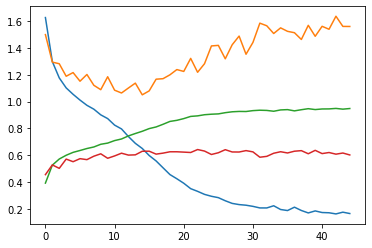

In [9]:
plt.plot(hist)

In [12]:
import pickle
pickle.dump(hist, open('/tf/data/Quan/fer2013/att_vgg_demo_2_hist.hdf5', 'wb'))

In [13]:
best_acc

0.642510775862069

In [8]:
import torch
model = torch.load('/tf/data/Quan/fer2013/att_vgg_demo_2.pt')

In [15]:
from torchvision.models import *
model = resnet18()
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
pytorch_total_params

11689512

In [16]:
138357544 + 11689512

150047056

In [10]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
pytorch_total_params

34769301

In [15]:
# EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(test_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        acc = float((torch.argmax(outputs, dim=1) == labels).float().sum()/labels.size(0))
        loss = criterion(outputs, labels)

        running_valloss += loss.item()
        running_valacc += acc

    print('- Avg. val_loss: %.3f  | Avg. val_acc: %.3f' % (running_valloss / (i+1), running_valacc / (i+1)))

- Avg. val_loss: 1.234  | Avg. val_acc: 0.624


## 2. Combine 3-channels image

In [7]:
from skimage.feature import local_binary_pattern

def lbp_transform(x):
    radius = 2
    n_points = 8 * radius
    METHOD = 'uniform'

    imgUMat = np.uint8(np.array(x))

    lbp = local_binary_pattern(imgUMat, n_points, radius, method=METHOD)
    lbp = np.uint8(lbp)
    
    return lbp

from skimage.feature import hog

def hog_transform(x):
    imgUMat = np.uint8(np.array(x))
    
    gx = cv2.Sobel(imgUMat,cv2.CV_32F,1,0,ksize=3)
    gy = cv2.Sobel(imgUMat,cv2.CV_32F,0,1,ksize=3)

    mag, ang = cv2.cartToPolar(gx, gy)


    
#     _, mag = hog(imgUMat, orientations=9, pixels_per_cell=(8, 8), 
#                     cells_per_block=(2, 2), visualize=True, multichannel=False)
    
    hg = np.uint8(mag)
    
    return hg

def combine_lbp_hog(x):
    imgUMat = np.uint8(np.array(x))
    hg = hog_transform(x)
    lbp = lbp_transform(x)
    
#     print('gray: ', imgUMat)
#     print('hg: ', hg)
#     print('lbp: ', lbp)

#     print(lbp)
    
#     print()


    cimg = np.stack((imgUMat, hg, lbp), axis=2)
#     cimg = cimg / 3
    
#     cimg = np.uint8(cimg)
    
    
#     cimg = (np.dstack((imgUMat, hg, lbp)) * 255.999) .astype(np.uint8)
    
    return cimg

In [8]:
import torch
from torchvision import transforms, datasets

data_transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
#         transforms.Lambda(detect_face),
#         transforms.Lambda(lbp_transform),
        transforms.Lambda(combine_lbp_hog),
        transforms.ToPILImage(),
        # transforms.RandomSizedCrop(224),
#         transforms.RandomHorizontalFlip(),
#         transforms.RandomVerticalFlip(),
#         transforms.RandomRotation(degrees=180),
        transforms.Resize((48,48)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

train_fer = datasets.ImageFolder(root='/tf/data/Quan/fer2013/data/train', transform=data_transform)
val_fer = datasets.ImageFolder(root='/tf/data/Quan/fer2013/data/val', transform=data_transform)
test_fer = datasets.ImageFolder(root='/tf/data/Quan/fer2013/data/test', transform=data_transform)

batch_size = 128
train_loader = torch.utils.data.DataLoader(train_fer,
                                             batch_size=batch_size, shuffle=True,
                                             num_workers=8)
val_loader = torch.utils.data.DataLoader(val_fer,
                                             batch_size=batch_size, shuffle=True,
                                             num_workers=8)
test_loader = torch.utils.data.DataLoader(test_fer,
                                             batch_size=batch_size, shuffle=True,
                                             num_workers=8)

In [9]:
model = model.to(device)

model_path = '/tf/data/Quan/fer2013/att_vgg_demo_2_3channels.pt'
best_acc = 0.0
hist = []

for epoch in range(60):  # loop over the dataset multiple times
    
    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0

    # TRAIN
    model.train()
    for i, data in enumerate(train_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        acc = float((torch.argmax(outputs, dim=1) == labels).float().sum()/labels.size(0))
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        running_acc += acc
        print('\t - Step %d: loss: %.3f acc: %.3f' % (i+1, loss.item(), acc))

    print('- Avg.loss: %.3f  | Avg.acc: %.3f' % (running_loss / (i+1), running_acc / (i+1)))
    avgloss = running_loss / (i+1)
    avgacc = running_acc / (i+1)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        acc = float((torch.argmax(outputs, dim=1) == labels).float().sum()/labels.size(0))
        loss = criterion(outputs, labels)

        running_valloss += loss.item()
        running_valacc += acc

    print('- Avg. val_loss: %.3f  | Avg. val_acc: %.3f' % (running_valloss / (i+1), running_valacc / (i+1)))

    avgvalloss = running_valloss / (i+1)
    avgvalcc = running_valacc / (i+1)

    hist.append([avgloss, avgvalloss, avgacc, avgvalcc])
    
    if best_acc < (running_valacc / (i+1)):
        best_acc = (running_valacc / (i+1))
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')

Epoch:  1
	 - Step 1: loss: 2.251 acc: 0.211
	 - Step 2: loss: 2.276 acc: 0.188
	 - Step 3: loss: 2.250 acc: 0.180
	 - Step 4: loss: 1.957 acc: 0.234
	 - Step 5: loss: 2.056 acc: 0.148
	 - Step 6: loss: 1.967 acc: 0.172
	 - Step 7: loss: 1.965 acc: 0.164
	 - Step 8: loss: 1.979 acc: 0.133
	 - Step 9: loss: 1.912 acc: 0.156
	 - Step 10: loss: 1.895 acc: 0.195
	 - Step 11: loss: 1.917 acc: 0.227
	 - Step 12: loss: 1.887 acc: 0.227
	 - Step 13: loss: 1.939 acc: 0.164
	 - Step 14: loss: 1.923 acc: 0.266
	 - Step 15: loss: 1.898 acc: 0.242
	 - Step 16: loss: 1.925 acc: 0.195
	 - Step 17: loss: 1.907 acc: 0.195
	 - Step 18: loss: 1.908 acc: 0.234
	 - Step 19: loss: 1.903 acc: 0.281
	 - Step 20: loss: 1.877 acc: 0.305
	 - Step 21: loss: 1.910 acc: 0.242
	 - Step 22: loss: 1.949 acc: 0.211
	 - Step 23: loss: 1.898 acc: 0.242
	 - Step 24: loss: 1.902 acc: 0.180
	 - Step 25: loss: 1.939 acc: 0.227
	 - Step 26: loss: 1.914 acc: 0.234
	 - Step 27: loss: 1.896 acc: 0.289
	 - Step 28: loss: 1.919 ac

- Avg. val_loss: 1.515  | Avg. val_acc: 0.409
* Update optimal model
Epoch:  2


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type SVGG. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type SVblock. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type WeightFeature. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


	 - Step 1: loss: 1.560 acc: 0.391
	 - Step 2: loss: 1.556 acc: 0.375
	 - Step 3: loss: 1.442 acc: 0.469
	 - Step 4: loss: 1.494 acc: 0.469
	 - Step 5: loss: 1.542 acc: 0.398
	 - Step 6: loss: 1.543 acc: 0.438
	 - Step 7: loss: 1.437 acc: 0.461
	 - Step 8: loss: 1.504 acc: 0.461
	 - Step 9: loss: 1.517 acc: 0.453
	 - Step 10: loss: 1.363 acc: 0.539
	 - Step 11: loss: 1.492 acc: 0.430
	 - Step 12: loss: 1.315 acc: 0.500
	 - Step 13: loss: 1.477 acc: 0.453
	 - Step 14: loss: 1.471 acc: 0.406
	 - Step 15: loss: 1.481 acc: 0.438
	 - Step 16: loss: 1.467 acc: 0.461
	 - Step 17: loss: 1.480 acc: 0.422
	 - Step 18: loss: 1.439 acc: 0.469
	 - Step 19: loss: 1.472 acc: 0.445
	 - Step 20: loss: 1.444 acc: 0.469
	 - Step 21: loss: 1.475 acc: 0.531
	 - Step 22: loss: 1.485 acc: 0.445
	 - Step 23: loss: 1.565 acc: 0.398
	 - Step 24: loss: 1.434 acc: 0.461
	 - Step 25: loss: 1.513 acc: 0.398
	 - Step 26: loss: 1.459 acc: 0.453
	 - Step 27: loss: 1.370 acc: 0.531
	 - Step 28: loss: 1.487 acc: 0.375
	

- Avg. val_loss: 1.359  | Avg. val_acc: 0.484
* Update optimal model
Epoch:  3
	 - Step 1: loss: 1.400 acc: 0.430
	 - Step 2: loss: 1.348 acc: 0.508
	 - Step 3: loss: 1.146 acc: 0.625
	 - Step 4: loss: 1.300 acc: 0.484
	 - Step 5: loss: 1.173 acc: 0.547
	 - Step 6: loss: 1.447 acc: 0.469
	 - Step 7: loss: 1.241 acc: 0.508
	 - Step 8: loss: 1.210 acc: 0.586
	 - Step 9: loss: 1.148 acc: 0.617
	 - Step 10: loss: 1.196 acc: 0.594
	 - Step 11: loss: 1.318 acc: 0.531
	 - Step 12: loss: 1.240 acc: 0.523
	 - Step 13: loss: 1.302 acc: 0.562
	 - Step 14: loss: 1.282 acc: 0.508
	 - Step 15: loss: 1.284 acc: 0.500
	 - Step 16: loss: 1.311 acc: 0.539
	 - Step 17: loss: 1.212 acc: 0.547
	 - Step 18: loss: 1.314 acc: 0.508
	 - Step 19: loss: 1.167 acc: 0.562
	 - Step 20: loss: 1.196 acc: 0.578
	 - Step 21: loss: 1.245 acc: 0.531
	 - Step 22: loss: 1.195 acc: 0.578
	 - Step 23: loss: 1.376 acc: 0.508
	 - Step 24: loss: 1.276 acc: 0.508
	 - Step 25: loss: 1.333 acc: 0.523
	 - Step 26: loss: 1.279 acc: 

	 - Step 225: loss: 1.222 acc: 0.568
- Avg.loss: 1.253  | Avg.acc: 0.542
- Avg. val_loss: 1.251  | Avg. val_acc: 0.541
* Update optimal model
Epoch:  4
	 - Step 1: loss: 1.115 acc: 0.617
	 - Step 2: loss: 1.079 acc: 0.633
	 - Step 3: loss: 1.308 acc: 0.531
	 - Step 4: loss: 1.258 acc: 0.500
	 - Step 5: loss: 1.079 acc: 0.594
	 - Step 6: loss: 1.255 acc: 0.578
	 - Step 7: loss: 1.192 acc: 0.539
	 - Step 8: loss: 1.197 acc: 0.492
	 - Step 9: loss: 1.186 acc: 0.555
	 - Step 10: loss: 1.115 acc: 0.602
	 - Step 11: loss: 1.262 acc: 0.586
	 - Step 12: loss: 1.161 acc: 0.539
	 - Step 13: loss: 1.126 acc: 0.570
	 - Step 14: loss: 1.157 acc: 0.555
	 - Step 15: loss: 1.245 acc: 0.500
	 - Step 16: loss: 1.143 acc: 0.625
	 - Step 17: loss: 1.150 acc: 0.602
	 - Step 18: loss: 1.191 acc: 0.539
	 - Step 19: loss: 1.063 acc: 0.594
	 - Step 20: loss: 1.174 acc: 0.578
	 - Step 21: loss: 1.225 acc: 0.594
	 - Step 22: loss: 1.140 acc: 0.594
	 - Step 23: loss: 1.113 acc: 0.547
	 - Step 24: loss: 1.292 acc:

	 - Step 223: loss: 1.270 acc: 0.539
	 - Step 224: loss: 1.145 acc: 0.586
	 - Step 225: loss: 1.153 acc: 0.568
- Avg.loss: 1.160  | Avg.acc: 0.575
- Avg. val_loss: 1.229  | Avg. val_acc: 0.545
* Update optimal model
Epoch:  5
	 - Step 1: loss: 1.045 acc: 0.633
	 - Step 2: loss: 1.161 acc: 0.570
	 - Step 3: loss: 1.098 acc: 0.570
	 - Step 4: loss: 1.121 acc: 0.594
	 - Step 5: loss: 1.045 acc: 0.594
	 - Step 6: loss: 1.152 acc: 0.562
	 - Step 7: loss: 1.022 acc: 0.625
	 - Step 8: loss: 1.094 acc: 0.617
	 - Step 9: loss: 1.121 acc: 0.578
	 - Step 10: loss: 0.980 acc: 0.672
	 - Step 11: loss: 1.064 acc: 0.633
	 - Step 12: loss: 1.098 acc: 0.625
	 - Step 13: loss: 1.104 acc: 0.555
	 - Step 14: loss: 0.987 acc: 0.664
	 - Step 15: loss: 0.913 acc: 0.680
	 - Step 16: loss: 1.099 acc: 0.617
	 - Step 17: loss: 1.047 acc: 0.617
	 - Step 18: loss: 1.033 acc: 0.633
	 - Step 19: loss: 0.952 acc: 0.695
	 - Step 20: loss: 1.005 acc: 0.680
	 - Step 21: loss: 1.134 acc: 0.578
	 - Step 22: loss: 1.139 ac

	 - Step 221: loss: 1.083 acc: 0.602
	 - Step 222: loss: 1.176 acc: 0.492
	 - Step 223: loss: 0.967 acc: 0.688
	 - Step 224: loss: 1.048 acc: 0.617
	 - Step 225: loss: 1.415 acc: 0.568
- Avg.loss: 1.104  | Avg.acc: 0.599
- Avg. val_loss: 1.246  | Avg. val_acc: 0.539
Epoch:  6
	 - Step 1: loss: 0.971 acc: 0.656
	 - Step 2: loss: 1.158 acc: 0.586
	 - Step 3: loss: 1.057 acc: 0.664
	 - Step 4: loss: 1.043 acc: 0.648
	 - Step 5: loss: 1.050 acc: 0.656
	 - Step 6: loss: 1.133 acc: 0.602
	 - Step 7: loss: 1.163 acc: 0.570
	 - Step 8: loss: 1.075 acc: 0.625
	 - Step 9: loss: 1.023 acc: 0.609
	 - Step 10: loss: 0.865 acc: 0.719
	 - Step 11: loss: 1.132 acc: 0.594
	 - Step 12: loss: 1.023 acc: 0.609
	 - Step 13: loss: 1.116 acc: 0.625
	 - Step 14: loss: 1.020 acc: 0.602
	 - Step 15: loss: 0.947 acc: 0.664
	 - Step 16: loss: 1.067 acc: 0.617
	 - Step 17: loss: 1.043 acc: 0.609
	 - Step 18: loss: 1.008 acc: 0.688
	 - Step 19: loss: 0.994 acc: 0.625
	 - Step 20: loss: 0.963 acc: 0.633
	 - Step 21:

	 - Step 219: loss: 1.007 acc: 0.641
	 - Step 220: loss: 1.040 acc: 0.633
	 - Step 221: loss: 1.040 acc: 0.609
	 - Step 222: loss: 1.004 acc: 0.656
	 - Step 223: loss: 1.048 acc: 0.602
	 - Step 224: loss: 1.029 acc: 0.648
	 - Step 225: loss: 1.208 acc: 0.486
- Avg.loss: 1.058  | Avg.acc: 0.618
- Avg. val_loss: 1.197  | Avg. val_acc: 0.564
* Update optimal model
Epoch:  7
	 - Step 1: loss: 0.995 acc: 0.609
	 - Step 2: loss: 1.109 acc: 0.625
	 - Step 3: loss: 1.079 acc: 0.609
	 - Step 4: loss: 0.926 acc: 0.695
	 - Step 5: loss: 1.038 acc: 0.648
	 - Step 6: loss: 0.974 acc: 0.664
	 - Step 7: loss: 1.011 acc: 0.672
	 - Step 8: loss: 1.030 acc: 0.609
	 - Step 9: loss: 0.977 acc: 0.656
	 - Step 10: loss: 1.075 acc: 0.578
	 - Step 11: loss: 0.966 acc: 0.711
	 - Step 12: loss: 1.068 acc: 0.617
	 - Step 13: loss: 1.059 acc: 0.656
	 - Step 14: loss: 0.990 acc: 0.609
	 - Step 15: loss: 0.892 acc: 0.664
	 - Step 16: loss: 0.952 acc: 0.656
	 - Step 17: loss: 1.046 acc: 0.648
	 - Step 18: loss: 0.90

	 - Step 217: loss: 1.056 acc: 0.625
	 - Step 218: loss: 1.017 acc: 0.664
	 - Step 219: loss: 1.123 acc: 0.531
	 - Step 220: loss: 1.009 acc: 0.594
	 - Step 221: loss: 1.110 acc: 0.625
	 - Step 222: loss: 1.133 acc: 0.570
	 - Step 223: loss: 1.099 acc: 0.602
	 - Step 224: loss: 0.986 acc: 0.648
	 - Step 225: loss: 1.058 acc: 0.568
- Avg.loss: 1.010  | Avg.acc: 0.637
- Avg. val_loss: 1.198  | Avg. val_acc: 0.552
Epoch:  8
	 - Step 1: loss: 0.897 acc: 0.719
	 - Step 2: loss: 0.895 acc: 0.703
	 - Step 3: loss: 0.931 acc: 0.664
	 - Step 4: loss: 0.932 acc: 0.680
	 - Step 5: loss: 0.960 acc: 0.633
	 - Step 6: loss: 0.950 acc: 0.656
	 - Step 7: loss: 1.015 acc: 0.625
	 - Step 8: loss: 0.977 acc: 0.648
	 - Step 9: loss: 1.111 acc: 0.562
	 - Step 10: loss: 1.103 acc: 0.602
	 - Step 11: loss: 0.965 acc: 0.641
	 - Step 12: loss: 0.929 acc: 0.688
	 - Step 13: loss: 1.007 acc: 0.672
	 - Step 14: loss: 1.204 acc: 0.539
	 - Step 15: loss: 0.944 acc: 0.609
	 - Step 16: loss: 0.895 acc: 0.734
	 - Step

	 - Step 215: loss: 0.884 acc: 0.703
	 - Step 216: loss: 1.130 acc: 0.555
	 - Step 217: loss: 1.183 acc: 0.570
	 - Step 218: loss: 0.948 acc: 0.656
	 - Step 219: loss: 0.945 acc: 0.703
	 - Step 220: loss: 1.047 acc: 0.617
	 - Step 221: loss: 1.071 acc: 0.586
	 - Step 222: loss: 0.824 acc: 0.672
	 - Step 223: loss: 0.967 acc: 0.633
	 - Step 224: loss: 0.889 acc: 0.680
	 - Step 225: loss: 1.101 acc: 0.649
- Avg.loss: 0.974  | Avg.acc: 0.649
- Avg. val_loss: 1.212  | Avg. val_acc: 0.558
Epoch:  9
	 - Step 1: loss: 0.960 acc: 0.656
	 - Step 2: loss: 0.918 acc: 0.664
	 - Step 3: loss: 0.917 acc: 0.672
	 - Step 4: loss: 1.059 acc: 0.617
	 - Step 5: loss: 0.868 acc: 0.703
	 - Step 6: loss: 0.903 acc: 0.648
	 - Step 7: loss: 0.842 acc: 0.695
	 - Step 8: loss: 0.864 acc: 0.703
	 - Step 9: loss: 0.959 acc: 0.672
	 - Step 10: loss: 1.256 acc: 0.531
	 - Step 11: loss: 1.055 acc: 0.594
	 - Step 12: loss: 0.956 acc: 0.703
	 - Step 13: loss: 0.920 acc: 0.672
	 - Step 14: loss: 0.835 acc: 0.672
	 - St

	 - Step 213: loss: 0.911 acc: 0.664
	 - Step 214: loss: 0.933 acc: 0.688
	 - Step 215: loss: 1.112 acc: 0.594
	 - Step 216: loss: 0.959 acc: 0.656
	 - Step 217: loss: 0.986 acc: 0.641
	 - Step 218: loss: 0.845 acc: 0.688
	 - Step 219: loss: 0.921 acc: 0.680
	 - Step 220: loss: 0.964 acc: 0.641
	 - Step 221: loss: 0.884 acc: 0.711
	 - Step 222: loss: 0.940 acc: 0.609
	 - Step 223: loss: 0.929 acc: 0.656
	 - Step 224: loss: 0.959 acc: 0.656
	 - Step 225: loss: 0.825 acc: 0.703
- Avg.loss: 0.943  | Avg.acc: 0.663
- Avg. val_loss: 1.209  | Avg. val_acc: 0.561
Epoch:  10
	 - Step 1: loss: 0.909 acc: 0.688
	 - Step 2: loss: 0.890 acc: 0.695
	 - Step 3: loss: 0.757 acc: 0.734
	 - Step 4: loss: 0.893 acc: 0.641
	 - Step 5: loss: 0.745 acc: 0.789
	 - Step 6: loss: 0.742 acc: 0.766
	 - Step 7: loss: 0.954 acc: 0.672
	 - Step 8: loss: 0.847 acc: 0.688
	 - Step 9: loss: 0.763 acc: 0.773
	 - Step 10: loss: 0.841 acc: 0.719
	 - Step 11: loss: 0.753 acc: 0.727
	 - Step 12: loss: 0.737 acc: 0.750
	 -

	 - Step 211: loss: 1.029 acc: 0.648
	 - Step 212: loss: 0.963 acc: 0.664
	 - Step 213: loss: 0.955 acc: 0.641
	 - Step 214: loss: 1.011 acc: 0.648
	 - Step 215: loss: 1.017 acc: 0.633
	 - Step 216: loss: 0.997 acc: 0.617
	 - Step 217: loss: 1.056 acc: 0.555
	 - Step 218: loss: 0.897 acc: 0.664
	 - Step 219: loss: 0.760 acc: 0.727
	 - Step 220: loss: 1.010 acc: 0.664
	 - Step 221: loss: 0.864 acc: 0.672
	 - Step 222: loss: 1.092 acc: 0.602
	 - Step 223: loss: 0.787 acc: 0.742
	 - Step 224: loss: 0.752 acc: 0.719
	 - Step 225: loss: 0.766 acc: 0.703
- Avg.loss: 0.899  | Avg.acc: 0.681
- Avg. val_loss: 1.154  | Avg. val_acc: 0.569
* Update optimal model
Epoch:  11
	 - Step 1: loss: 0.928 acc: 0.672
	 - Step 2: loss: 0.749 acc: 0.766
	 - Step 3: loss: 1.017 acc: 0.672
	 - Step 4: loss: 0.763 acc: 0.750
	 - Step 5: loss: 0.901 acc: 0.664
	 - Step 6: loss: 0.875 acc: 0.672
	 - Step 7: loss: 0.723 acc: 0.773
	 - Step 8: loss: 0.729 acc: 0.727
	 - Step 9: loss: 0.816 acc: 0.734
	 - Step 10: l

	 - Step 209: loss: 0.882 acc: 0.680
	 - Step 210: loss: 0.941 acc: 0.680
	 - Step 211: loss: 0.871 acc: 0.680
	 - Step 212: loss: 1.029 acc: 0.633
	 - Step 213: loss: 0.822 acc: 0.734
	 - Step 214: loss: 0.941 acc: 0.680
	 - Step 215: loss: 0.825 acc: 0.719
	 - Step 216: loss: 0.855 acc: 0.695
	 - Step 217: loss: 0.792 acc: 0.734
	 - Step 218: loss: 0.873 acc: 0.672
	 - Step 219: loss: 0.884 acc: 0.695
	 - Step 220: loss: 0.895 acc: 0.617
	 - Step 221: loss: 0.906 acc: 0.664
	 - Step 222: loss: 0.797 acc: 0.695
	 - Step 223: loss: 0.774 acc: 0.703
	 - Step 224: loss: 0.897 acc: 0.688
	 - Step 225: loss: 0.850 acc: 0.676
- Avg.loss: 0.853  | Avg.acc: 0.701
- Avg. val_loss: 1.139  | Avg. val_acc: 0.580
* Update optimal model
Epoch:  12
	 - Step 1: loss: 0.802 acc: 0.711
	 - Step 2: loss: 0.804 acc: 0.773
	 - Step 3: loss: 0.754 acc: 0.742
	 - Step 4: loss: 0.899 acc: 0.703
	 - Step 5: loss: 0.812 acc: 0.711
	 - Step 6: loss: 0.769 acc: 0.727
	 - Step 7: loss: 0.819 acc: 0.734
	 - Step 8

	 - Step 207: loss: 0.740 acc: 0.711
	 - Step 208: loss: 0.788 acc: 0.695
	 - Step 209: loss: 0.791 acc: 0.695
	 - Step 210: loss: 0.679 acc: 0.766
	 - Step 211: loss: 0.833 acc: 0.727
	 - Step 212: loss: 0.943 acc: 0.664
	 - Step 213: loss: 0.925 acc: 0.656
	 - Step 214: loss: 0.832 acc: 0.703
	 - Step 215: loss: 0.767 acc: 0.727
	 - Step 216: loss: 0.727 acc: 0.727
	 - Step 217: loss: 0.795 acc: 0.711
	 - Step 218: loss: 0.799 acc: 0.688
	 - Step 219: loss: 1.128 acc: 0.602
	 - Step 220: loss: 0.874 acc: 0.727
	 - Step 221: loss: 0.841 acc: 0.711
	 - Step 222: loss: 0.876 acc: 0.680
	 - Step 223: loss: 0.813 acc: 0.711
	 - Step 224: loss: 0.727 acc: 0.781
	 - Step 225: loss: 1.063 acc: 0.541
- Avg.loss: 0.816  | Avg.acc: 0.714
- Avg. val_loss: 1.204  | Avg. val_acc: 0.577
Epoch:  13
	 - Step 1: loss: 0.713 acc: 0.758
	 - Step 2: loss: 0.605 acc: 0.828
	 - Step 3: loss: 0.719 acc: 0.742
	 - Step 4: loss: 0.721 acc: 0.734
	 - Step 5: loss: 0.672 acc: 0.773
	 - Step 6: loss: 0.592 acc: 

	 - Step 205: loss: 0.973 acc: 0.672
	 - Step 206: loss: 0.740 acc: 0.734
	 - Step 207: loss: 0.628 acc: 0.797
	 - Step 208: loss: 0.831 acc: 0.711
	 - Step 209: loss: 0.871 acc: 0.711
	 - Step 210: loss: 0.720 acc: 0.766
	 - Step 211: loss: 0.737 acc: 0.742
	 - Step 212: loss: 0.826 acc: 0.742
	 - Step 213: loss: 0.732 acc: 0.805
	 - Step 214: loss: 0.735 acc: 0.742
	 - Step 215: loss: 0.690 acc: 0.789
	 - Step 216: loss: 0.806 acc: 0.703
	 - Step 217: loss: 0.834 acc: 0.695
	 - Step 218: loss: 0.753 acc: 0.711
	 - Step 219: loss: 0.577 acc: 0.789
	 - Step 220: loss: 0.700 acc: 0.773
	 - Step 221: loss: 0.671 acc: 0.734
	 - Step 222: loss: 0.836 acc: 0.703
	 - Step 223: loss: 0.864 acc: 0.672
	 - Step 224: loss: 0.711 acc: 0.711
	 - Step 225: loss: 0.872 acc: 0.703
- Avg.loss: 0.769  | Avg.acc: 0.730
- Avg. val_loss: 1.111  | Avg. val_acc: 0.599
* Update optimal model
Epoch:  14
	 - Step 1: loss: 0.726 acc: 0.750
	 - Step 2: loss: 0.718 acc: 0.758
	 - Step 3: loss: 0.683 acc: 0.742
	 

	 - Step 203: loss: 0.780 acc: 0.680
	 - Step 204: loss: 0.698 acc: 0.734
	 - Step 205: loss: 0.868 acc: 0.641
	 - Step 206: loss: 0.657 acc: 0.781
	 - Step 207: loss: 0.728 acc: 0.781
	 - Step 208: loss: 0.730 acc: 0.758
	 - Step 209: loss: 0.689 acc: 0.742
	 - Step 210: loss: 0.717 acc: 0.766
	 - Step 211: loss: 0.739 acc: 0.742
	 - Step 212: loss: 0.828 acc: 0.711
	 - Step 213: loss: 0.765 acc: 0.727
	 - Step 214: loss: 0.839 acc: 0.727
	 - Step 215: loss: 0.778 acc: 0.734
	 - Step 216: loss: 0.645 acc: 0.781
	 - Step 217: loss: 0.665 acc: 0.758
	 - Step 218: loss: 0.630 acc: 0.797
	 - Step 219: loss: 0.773 acc: 0.758
	 - Step 220: loss: 0.720 acc: 0.727
	 - Step 221: loss: 0.843 acc: 0.695
	 - Step 222: loss: 0.836 acc: 0.703
	 - Step 223: loss: 0.835 acc: 0.688
	 - Step 224: loss: 0.745 acc: 0.719
	 - Step 225: loss: 0.770 acc: 0.703
- Avg.loss: 0.718  | Avg.acc: 0.751
- Avg. val_loss: 1.244  | Avg. val_acc: 0.572
Epoch:  15
	 - Step 1: loss: 0.503 acc: 0.836
	 - Step 2: loss: 0.5

	 - Step 201: loss: 0.619 acc: 0.781
	 - Step 202: loss: 0.659 acc: 0.758
	 - Step 203: loss: 0.854 acc: 0.695
	 - Step 204: loss: 0.966 acc: 0.711
	 - Step 205: loss: 0.622 acc: 0.805
	 - Step 206: loss: 0.753 acc: 0.734
	 - Step 207: loss: 0.808 acc: 0.711
	 - Step 208: loss: 0.791 acc: 0.734
	 - Step 209: loss: 0.716 acc: 0.734
	 - Step 210: loss: 0.754 acc: 0.766
	 - Step 211: loss: 0.694 acc: 0.734
	 - Step 212: loss: 0.428 acc: 0.898
	 - Step 213: loss: 0.728 acc: 0.758
	 - Step 214: loss: 0.610 acc: 0.758
	 - Step 215: loss: 0.644 acc: 0.789
	 - Step 216: loss: 0.774 acc: 0.750
	 - Step 217: loss: 0.959 acc: 0.664
	 - Step 218: loss: 0.957 acc: 0.664
	 - Step 219: loss: 0.701 acc: 0.734
	 - Step 220: loss: 0.798 acc: 0.742
	 - Step 221: loss: 0.780 acc: 0.734
	 - Step 222: loss: 0.695 acc: 0.766
	 - Step 223: loss: 0.851 acc: 0.703
	 - Step 224: loss: 0.627 acc: 0.789
	 - Step 225: loss: 0.699 acc: 0.703
- Avg.loss: 0.667  | Avg.acc: 0.774
- Avg. val_loss: 1.115  | Avg. val_acc:

	 - Step 199: loss: 0.617 acc: 0.797
	 - Step 200: loss: 0.637 acc: 0.820
	 - Step 201: loss: 0.691 acc: 0.781
	 - Step 202: loss: 0.655 acc: 0.789
	 - Step 203: loss: 0.706 acc: 0.781
	 - Step 204: loss: 0.693 acc: 0.758
	 - Step 205: loss: 0.562 acc: 0.797
	 - Step 206: loss: 0.718 acc: 0.734
	 - Step 207: loss: 0.701 acc: 0.711
	 - Step 208: loss: 0.697 acc: 0.773
	 - Step 209: loss: 0.789 acc: 0.719
	 - Step 210: loss: 0.625 acc: 0.812
	 - Step 211: loss: 0.643 acc: 0.789
	 - Step 212: loss: 0.674 acc: 0.758
	 - Step 213: loss: 0.537 acc: 0.812
	 - Step 214: loss: 0.576 acc: 0.781
	 - Step 215: loss: 0.750 acc: 0.719
	 - Step 216: loss: 0.709 acc: 0.773
	 - Step 217: loss: 0.683 acc: 0.750
	 - Step 218: loss: 0.710 acc: 0.703
	 - Step 219: loss: 0.833 acc: 0.719
	 - Step 220: loss: 0.688 acc: 0.797
	 - Step 221: loss: 0.744 acc: 0.734
	 - Step 222: loss: 0.556 acc: 0.836
	 - Step 223: loss: 0.709 acc: 0.797
	 - Step 224: loss: 0.689 acc: 0.734
	 - Step 225: loss: 0.665 acc: 0.757
-

	 - Step 197: loss: 0.565 acc: 0.820
	 - Step 198: loss: 0.567 acc: 0.797
	 - Step 199: loss: 0.516 acc: 0.859
	 - Step 200: loss: 0.718 acc: 0.734
	 - Step 201: loss: 0.736 acc: 0.727
	 - Step 202: loss: 0.585 acc: 0.820
	 - Step 203: loss: 0.598 acc: 0.828
	 - Step 204: loss: 0.639 acc: 0.750
	 - Step 205: loss: 0.626 acc: 0.781
	 - Step 206: loss: 0.632 acc: 0.797
	 - Step 207: loss: 0.602 acc: 0.781
	 - Step 208: loss: 0.632 acc: 0.781
	 - Step 209: loss: 0.544 acc: 0.797
	 - Step 210: loss: 0.737 acc: 0.727
	 - Step 211: loss: 0.684 acc: 0.773
	 - Step 212: loss: 0.695 acc: 0.773
	 - Step 213: loss: 0.510 acc: 0.820
	 - Step 214: loss: 0.653 acc: 0.766
	 - Step 215: loss: 0.609 acc: 0.812
	 - Step 216: loss: 0.524 acc: 0.805
	 - Step 217: loss: 0.655 acc: 0.797
	 - Step 218: loss: 0.542 acc: 0.836
	 - Step 219: loss: 0.515 acc: 0.797
	 - Step 220: loss: 0.816 acc: 0.727
	 - Step 221: loss: 0.639 acc: 0.758
	 - Step 222: loss: 0.559 acc: 0.828
	 - Step 223: loss: 0.642 acc: 0.781
	

	 - Step 195: loss: 0.606 acc: 0.805
	 - Step 196: loss: 0.607 acc: 0.789
	 - Step 197: loss: 0.504 acc: 0.836
	 - Step 198: loss: 0.591 acc: 0.781
	 - Step 199: loss: 0.527 acc: 0.820
	 - Step 200: loss: 0.706 acc: 0.758
	 - Step 201: loss: 0.452 acc: 0.820
	 - Step 202: loss: 0.471 acc: 0.820
	 - Step 203: loss: 0.435 acc: 0.852
	 - Step 204: loss: 0.798 acc: 0.805
	 - Step 205: loss: 0.551 acc: 0.836
	 - Step 206: loss: 0.609 acc: 0.836
	 - Step 207: loss: 0.576 acc: 0.844
	 - Step 208: loss: 0.644 acc: 0.773
	 - Step 209: loss: 0.604 acc: 0.789
	 - Step 210: loss: 0.486 acc: 0.812
	 - Step 211: loss: 0.461 acc: 0.844
	 - Step 212: loss: 0.541 acc: 0.773
	 - Step 213: loss: 0.563 acc: 0.836
	 - Step 214: loss: 0.581 acc: 0.797
	 - Step 215: loss: 0.542 acc: 0.828
	 - Step 216: loss: 0.646 acc: 0.734
	 - Step 217: loss: 0.448 acc: 0.859
	 - Step 218: loss: 0.535 acc: 0.820
	 - Step 219: loss: 0.630 acc: 0.773
	 - Step 220: loss: 0.444 acc: 0.836
	 - Step 221: loss: 0.602 acc: 0.773
	

	 - Step 193: loss: 0.364 acc: 0.875
	 - Step 194: loss: 0.641 acc: 0.766
	 - Step 195: loss: 0.519 acc: 0.852
	 - Step 196: loss: 0.474 acc: 0.828
	 - Step 197: loss: 0.441 acc: 0.859
	 - Step 198: loss: 0.508 acc: 0.836
	 - Step 199: loss: 0.409 acc: 0.852
	 - Step 200: loss: 0.531 acc: 0.828
	 - Step 201: loss: 0.522 acc: 0.820
	 - Step 202: loss: 0.734 acc: 0.766
	 - Step 203: loss: 0.480 acc: 0.859
	 - Step 204: loss: 0.427 acc: 0.883
	 - Step 205: loss: 0.343 acc: 0.898
	 - Step 206: loss: 0.629 acc: 0.812
	 - Step 207: loss: 0.519 acc: 0.828
	 - Step 208: loss: 0.499 acc: 0.852
	 - Step 209: loss: 0.576 acc: 0.836
	 - Step 210: loss: 0.621 acc: 0.750
	 - Step 211: loss: 0.502 acc: 0.836
	 - Step 212: loss: 0.616 acc: 0.805
	 - Step 213: loss: 0.440 acc: 0.844
	 - Step 214: loss: 0.514 acc: 0.820
	 - Step 215: loss: 0.542 acc: 0.812
	 - Step 216: loss: 0.427 acc: 0.906
	 - Step 217: loss: 0.489 acc: 0.820
	 - Step 218: loss: 0.603 acc: 0.789
	 - Step 219: loss: 0.549 acc: 0.844
	

	 - Step 191: loss: 0.361 acc: 0.898
	 - Step 192: loss: 0.488 acc: 0.867
	 - Step 193: loss: 0.515 acc: 0.820
	 - Step 194: loss: 0.428 acc: 0.859
	 - Step 195: loss: 0.532 acc: 0.836
	 - Step 196: loss: 0.341 acc: 0.875
	 - Step 197: loss: 0.484 acc: 0.875
	 - Step 198: loss: 0.386 acc: 0.891
	 - Step 199: loss: 0.508 acc: 0.828
	 - Step 200: loss: 0.496 acc: 0.867
	 - Step 201: loss: 0.335 acc: 0.898
	 - Step 202: loss: 0.397 acc: 0.898
	 - Step 203: loss: 0.397 acc: 0.859
	 - Step 204: loss: 0.533 acc: 0.805
	 - Step 205: loss: 0.448 acc: 0.859
	 - Step 206: loss: 0.304 acc: 0.898
	 - Step 207: loss: 0.495 acc: 0.828
	 - Step 208: loss: 0.582 acc: 0.812
	 - Step 209: loss: 0.507 acc: 0.852
	 - Step 210: loss: 0.425 acc: 0.828
	 - Step 211: loss: 0.479 acc: 0.820
	 - Step 212: loss: 0.608 acc: 0.789
	 - Step 213: loss: 0.427 acc: 0.867
	 - Step 214: loss: 0.374 acc: 0.883
	 - Step 215: loss: 0.431 acc: 0.875
	 - Step 216: loss: 0.522 acc: 0.797
	 - Step 217: loss: 0.472 acc: 0.844
	

	 - Step 189: loss: 0.418 acc: 0.859
	 - Step 190: loss: 0.446 acc: 0.805
	 - Step 191: loss: 0.648 acc: 0.781
	 - Step 192: loss: 0.472 acc: 0.844
	 - Step 193: loss: 0.409 acc: 0.844
	 - Step 194: loss: 0.379 acc: 0.883
	 - Step 195: loss: 0.372 acc: 0.906
	 - Step 196: loss: 0.542 acc: 0.836
	 - Step 197: loss: 0.314 acc: 0.898
	 - Step 198: loss: 0.536 acc: 0.859
	 - Step 199: loss: 0.456 acc: 0.828
	 - Step 200: loss: 0.428 acc: 0.859
	 - Step 201: loss: 0.615 acc: 0.805
	 - Step 202: loss: 0.530 acc: 0.812
	 - Step 203: loss: 0.497 acc: 0.820
	 - Step 204: loss: 0.500 acc: 0.820
	 - Step 205: loss: 0.506 acc: 0.820
	 - Step 206: loss: 0.476 acc: 0.820
	 - Step 207: loss: 0.441 acc: 0.844
	 - Step 208: loss: 0.336 acc: 0.906
	 - Step 209: loss: 0.373 acc: 0.914
	 - Step 210: loss: 0.539 acc: 0.820
	 - Step 211: loss: 0.392 acc: 0.906
	 - Step 212: loss: 0.415 acc: 0.875
	 - Step 213: loss: 0.453 acc: 0.859
	 - Step 214: loss: 0.522 acc: 0.828
	 - Step 215: loss: 0.487 acc: 0.836
	

	 - Step 187: loss: 0.396 acc: 0.891
	 - Step 188: loss: 0.377 acc: 0.883
	 - Step 189: loss: 0.390 acc: 0.867
	 - Step 190: loss: 0.523 acc: 0.836
	 - Step 191: loss: 0.481 acc: 0.859
	 - Step 192: loss: 0.336 acc: 0.867
	 - Step 193: loss: 0.411 acc: 0.867
	 - Step 194: loss: 0.453 acc: 0.859
	 - Step 195: loss: 0.341 acc: 0.898
	 - Step 196: loss: 0.279 acc: 0.906
	 - Step 197: loss: 0.469 acc: 0.844
	 - Step 198: loss: 0.486 acc: 0.820
	 - Step 199: loss: 0.475 acc: 0.812
	 - Step 200: loss: 0.449 acc: 0.859
	 - Step 201: loss: 0.415 acc: 0.859
	 - Step 202: loss: 0.493 acc: 0.812
	 - Step 203: loss: 0.519 acc: 0.859
	 - Step 204: loss: 0.454 acc: 0.883
	 - Step 205: loss: 0.326 acc: 0.891
	 - Step 206: loss: 0.345 acc: 0.914
	 - Step 207: loss: 0.465 acc: 0.828
	 - Step 208: loss: 0.314 acc: 0.922
	 - Step 209: loss: 0.438 acc: 0.867
	 - Step 210: loss: 0.526 acc: 0.828
	 - Step 211: loss: 0.444 acc: 0.852
	 - Step 212: loss: 0.457 acc: 0.867
	 - Step 213: loss: 0.327 acc: 0.906
	

	 - Step 185: loss: 0.362 acc: 0.867
	 - Step 186: loss: 0.453 acc: 0.859
	 - Step 187: loss: 0.444 acc: 0.875
	 - Step 188: loss: 0.424 acc: 0.898
	 - Step 189: loss: 0.366 acc: 0.883
	 - Step 190: loss: 0.237 acc: 0.930
	 - Step 191: loss: 0.336 acc: 0.875
	 - Step 192: loss: 0.408 acc: 0.883
	 - Step 193: loss: 0.389 acc: 0.875
	 - Step 194: loss: 0.397 acc: 0.828
	 - Step 195: loss: 0.287 acc: 0.922
	 - Step 196: loss: 0.282 acc: 0.906
	 - Step 197: loss: 0.335 acc: 0.906
	 - Step 198: loss: 0.468 acc: 0.844
	 - Step 199: loss: 0.396 acc: 0.867
	 - Step 200: loss: 0.340 acc: 0.883
	 - Step 201: loss: 0.331 acc: 0.859
	 - Step 202: loss: 0.347 acc: 0.891
	 - Step 203: loss: 0.340 acc: 0.898
	 - Step 204: loss: 0.483 acc: 0.820
	 - Step 205: loss: 0.367 acc: 0.898
	 - Step 206: loss: 0.342 acc: 0.914
	 - Step 207: loss: 0.508 acc: 0.820
	 - Step 208: loss: 0.469 acc: 0.836
	 - Step 209: loss: 0.339 acc: 0.906
	 - Step 210: loss: 0.348 acc: 0.883
	 - Step 211: loss: 0.393 acc: 0.875
	

	 - Step 183: loss: 0.331 acc: 0.875
	 - Step 184: loss: 0.370 acc: 0.867
	 - Step 185: loss: 0.212 acc: 0.953
	 - Step 186: loss: 0.384 acc: 0.891
	 - Step 187: loss: 0.300 acc: 0.891
	 - Step 188: loss: 0.337 acc: 0.891
	 - Step 189: loss: 0.357 acc: 0.898
	 - Step 190: loss: 0.241 acc: 0.922
	 - Step 191: loss: 0.374 acc: 0.852
	 - Step 192: loss: 0.296 acc: 0.922
	 - Step 193: loss: 0.332 acc: 0.875
	 - Step 194: loss: 0.399 acc: 0.875
	 - Step 195: loss: 0.332 acc: 0.898
	 - Step 196: loss: 0.392 acc: 0.891
	 - Step 197: loss: 0.253 acc: 0.922
	 - Step 198: loss: 0.275 acc: 0.914
	 - Step 199: loss: 0.245 acc: 0.945
	 - Step 200: loss: 0.312 acc: 0.914
	 - Step 201: loss: 0.387 acc: 0.852
	 - Step 202: loss: 0.263 acc: 0.922
	 - Step 203: loss: 0.227 acc: 0.930
	 - Step 204: loss: 0.302 acc: 0.891
	 - Step 205: loss: 0.180 acc: 0.953
	 - Step 206: loss: 0.448 acc: 0.859
	 - Step 207: loss: 0.301 acc: 0.883
	 - Step 208: loss: 0.332 acc: 0.891
	 - Step 209: loss: 0.402 acc: 0.859
	

	 - Step 181: loss: 0.457 acc: 0.859
	 - Step 182: loss: 0.319 acc: 0.898
	 - Step 183: loss: 0.285 acc: 0.906
	 - Step 184: loss: 0.282 acc: 0.906
	 - Step 185: loss: 0.175 acc: 0.961
	 - Step 186: loss: 0.341 acc: 0.875
	 - Step 187: loss: 0.266 acc: 0.922
	 - Step 188: loss: 0.317 acc: 0.883
	 - Step 189: loss: 0.473 acc: 0.859
	 - Step 190: loss: 0.367 acc: 0.914
	 - Step 191: loss: 0.296 acc: 0.898
	 - Step 192: loss: 0.303 acc: 0.867
	 - Step 193: loss: 0.470 acc: 0.844
	 - Step 194: loss: 0.264 acc: 0.906
	 - Step 195: loss: 0.216 acc: 0.961
	 - Step 196: loss: 0.304 acc: 0.898
	 - Step 197: loss: 0.348 acc: 0.898
	 - Step 198: loss: 0.356 acc: 0.859
	 - Step 199: loss: 0.407 acc: 0.859
	 - Step 200: loss: 0.301 acc: 0.875
	 - Step 201: loss: 0.270 acc: 0.914
	 - Step 202: loss: 0.309 acc: 0.906
	 - Step 203: loss: 0.557 acc: 0.820
	 - Step 204: loss: 0.288 acc: 0.922
	 - Step 205: loss: 0.350 acc: 0.898
	 - Step 206: loss: 0.347 acc: 0.906
	 - Step 207: loss: 0.262 acc: 0.883
	

	 - Step 179: loss: 0.161 acc: 0.961
	 - Step 180: loss: 0.335 acc: 0.898
	 - Step 181: loss: 0.262 acc: 0.922
	 - Step 182: loss: 0.428 acc: 0.836
	 - Step 183: loss: 0.301 acc: 0.898
	 - Step 184: loss: 0.343 acc: 0.906
	 - Step 185: loss: 0.292 acc: 0.891
	 - Step 186: loss: 0.319 acc: 0.875
	 - Step 187: loss: 0.317 acc: 0.906
	 - Step 188: loss: 0.267 acc: 0.922
	 - Step 189: loss: 0.248 acc: 0.922
	 - Step 190: loss: 0.331 acc: 0.930
	 - Step 191: loss: 0.387 acc: 0.867
	 - Step 192: loss: 0.272 acc: 0.930
	 - Step 193: loss: 0.386 acc: 0.906
	 - Step 194: loss: 0.326 acc: 0.883
	 - Step 195: loss: 0.271 acc: 0.922
	 - Step 196: loss: 0.298 acc: 0.922
	 - Step 197: loss: 0.263 acc: 0.922
	 - Step 198: loss: 0.417 acc: 0.891
	 - Step 199: loss: 0.461 acc: 0.844
	 - Step 200: loss: 0.261 acc: 0.906
	 - Step 201: loss: 0.284 acc: 0.914
	 - Step 202: loss: 0.270 acc: 0.906
	 - Step 203: loss: 0.352 acc: 0.898
	 - Step 204: loss: 0.297 acc: 0.906
	 - Step 205: loss: 0.331 acc: 0.875
	

	 - Step 177: loss: 0.338 acc: 0.898
	 - Step 178: loss: 0.257 acc: 0.922
	 - Step 179: loss: 0.416 acc: 0.852
	 - Step 180: loss: 0.214 acc: 0.945
	 - Step 181: loss: 0.234 acc: 0.914
	 - Step 182: loss: 0.221 acc: 0.953
	 - Step 183: loss: 0.278 acc: 0.914
	 - Step 184: loss: 0.281 acc: 0.906
	 - Step 185: loss: 0.196 acc: 0.930
	 - Step 186: loss: 0.333 acc: 0.906
	 - Step 187: loss: 0.240 acc: 0.938
	 - Step 188: loss: 0.270 acc: 0.906
	 - Step 189: loss: 0.274 acc: 0.891
	 - Step 190: loss: 0.203 acc: 0.945
	 - Step 191: loss: 0.262 acc: 0.914
	 - Step 192: loss: 0.355 acc: 0.883
	 - Step 193: loss: 0.283 acc: 0.930
	 - Step 194: loss: 0.275 acc: 0.914
	 - Step 195: loss: 0.257 acc: 0.922
	 - Step 196: loss: 0.292 acc: 0.922
	 - Step 197: loss: 0.343 acc: 0.891
	 - Step 198: loss: 0.158 acc: 0.953
	 - Step 199: loss: 0.228 acc: 0.930
	 - Step 200: loss: 0.222 acc: 0.922
	 - Step 201: loss: 0.252 acc: 0.945
	 - Step 202: loss: 0.234 acc: 0.930
	 - Step 203: loss: 0.302 acc: 0.898
	

	 - Step 175: loss: 0.245 acc: 0.922
	 - Step 176: loss: 0.200 acc: 0.945
	 - Step 177: loss: 0.260 acc: 0.906
	 - Step 178: loss: 0.313 acc: 0.867
	 - Step 179: loss: 0.302 acc: 0.922
	 - Step 180: loss: 0.253 acc: 0.922
	 - Step 181: loss: 0.179 acc: 0.961
	 - Step 182: loss: 0.216 acc: 0.930
	 - Step 183: loss: 0.264 acc: 0.914
	 - Step 184: loss: 0.177 acc: 0.953
	 - Step 185: loss: 0.202 acc: 0.945
	 - Step 186: loss: 0.315 acc: 0.914
	 - Step 187: loss: 0.234 acc: 0.922
	 - Step 188: loss: 0.261 acc: 0.906
	 - Step 189: loss: 0.345 acc: 0.883
	 - Step 190: loss: 0.271 acc: 0.914
	 - Step 191: loss: 0.203 acc: 0.938
	 - Step 192: loss: 0.322 acc: 0.867
	 - Step 193: loss: 0.251 acc: 0.898
	 - Step 194: loss: 0.239 acc: 0.922
	 - Step 195: loss: 0.254 acc: 0.930
	 - Step 196: loss: 0.287 acc: 0.891
	 - Step 197: loss: 0.246 acc: 0.906
	 - Step 198: loss: 0.242 acc: 0.914
	 - Step 199: loss: 0.324 acc: 0.883
	 - Step 200: loss: 0.279 acc: 0.922
	 - Step 201: loss: 0.259 acc: 0.898
	

	 - Step 173: loss: 0.132 acc: 0.953
	 - Step 174: loss: 0.231 acc: 0.922
	 - Step 175: loss: 0.267 acc: 0.898
	 - Step 176: loss: 0.196 acc: 0.953
	 - Step 177: loss: 0.281 acc: 0.906
	 - Step 178: loss: 0.314 acc: 0.891
	 - Step 179: loss: 0.175 acc: 0.930
	 - Step 180: loss: 0.291 acc: 0.922
	 - Step 181: loss: 0.260 acc: 0.906
	 - Step 182: loss: 0.263 acc: 0.922
	 - Step 183: loss: 0.230 acc: 0.930
	 - Step 184: loss: 0.265 acc: 0.914
	 - Step 185: loss: 0.259 acc: 0.930
	 - Step 186: loss: 0.161 acc: 0.961
	 - Step 187: loss: 0.207 acc: 0.938
	 - Step 188: loss: 0.218 acc: 0.906
	 - Step 189: loss: 0.283 acc: 0.906
	 - Step 190: loss: 0.275 acc: 0.945
	 - Step 191: loss: 0.256 acc: 0.930
	 - Step 192: loss: 0.257 acc: 0.898
	 - Step 193: loss: 0.266 acc: 0.938
	 - Step 194: loss: 0.327 acc: 0.898
	 - Step 195: loss: 0.319 acc: 0.914
	 - Step 196: loss: 0.210 acc: 0.914
	 - Step 197: loss: 0.234 acc: 0.930
	 - Step 198: loss: 0.340 acc: 0.898
	 - Step 199: loss: 0.291 acc: 0.914
	

	 - Step 171: loss: 0.306 acc: 0.914
	 - Step 172: loss: 0.232 acc: 0.914
	 - Step 173: loss: 0.168 acc: 0.977
	 - Step 174: loss: 0.184 acc: 0.938
	 - Step 175: loss: 0.223 acc: 0.938
	 - Step 176: loss: 0.261 acc: 0.914
	 - Step 177: loss: 0.359 acc: 0.859
	 - Step 178: loss: 0.202 acc: 0.906
	 - Step 179: loss: 0.172 acc: 0.961
	 - Step 180: loss: 0.303 acc: 0.914
	 - Step 181: loss: 0.310 acc: 0.906
	 - Step 182: loss: 0.301 acc: 0.898
	 - Step 183: loss: 0.274 acc: 0.906
	 - Step 184: loss: 0.314 acc: 0.883
	 - Step 185: loss: 0.215 acc: 0.938
	 - Step 186: loss: 0.294 acc: 0.891
	 - Step 187: loss: 0.338 acc: 0.914
	 - Step 188: loss: 0.165 acc: 0.961
	 - Step 189: loss: 0.313 acc: 0.883
	 - Step 190: loss: 0.393 acc: 0.906
	 - Step 191: loss: 0.101 acc: 0.984
	 - Step 192: loss: 0.265 acc: 0.914
	 - Step 193: loss: 0.275 acc: 0.914
	 - Step 194: loss: 0.316 acc: 0.906
	 - Step 195: loss: 0.251 acc: 0.906
	 - Step 196: loss: 0.299 acc: 0.906
	 - Step 197: loss: 0.275 acc: 0.922
	

	 - Step 169: loss: 0.261 acc: 0.906
	 - Step 170: loss: 0.246 acc: 0.906
	 - Step 171: loss: 0.220 acc: 0.930
	 - Step 172: loss: 0.232 acc: 0.938
	 - Step 173: loss: 0.294 acc: 0.891
	 - Step 174: loss: 0.332 acc: 0.898
	 - Step 175: loss: 0.306 acc: 0.898
	 - Step 176: loss: 0.242 acc: 0.938
	 - Step 177: loss: 0.192 acc: 0.938
	 - Step 178: loss: 0.204 acc: 0.930
	 - Step 179: loss: 0.167 acc: 0.945
	 - Step 180: loss: 0.204 acc: 0.938
	 - Step 181: loss: 0.250 acc: 0.930
	 - Step 182: loss: 0.217 acc: 0.906
	 - Step 183: loss: 0.168 acc: 0.945
	 - Step 184: loss: 0.397 acc: 0.867
	 - Step 185: loss: 0.243 acc: 0.914
	 - Step 186: loss: 0.395 acc: 0.867
	 - Step 187: loss: 0.259 acc: 0.922
	 - Step 188: loss: 0.278 acc: 0.898
	 - Step 189: loss: 0.232 acc: 0.938
	 - Step 190: loss: 0.245 acc: 0.898
	 - Step 191: loss: 0.323 acc: 0.898
	 - Step 192: loss: 0.277 acc: 0.914
	 - Step 193: loss: 0.180 acc: 0.938
	 - Step 194: loss: 0.184 acc: 0.938
	 - Step 195: loss: 0.294 acc: 0.898
	

	 - Step 167: loss: 0.340 acc: 0.891
	 - Step 168: loss: 0.255 acc: 0.914
	 - Step 169: loss: 0.175 acc: 0.938
	 - Step 170: loss: 0.232 acc: 0.922
	 - Step 171: loss: 0.140 acc: 0.961
	 - Step 172: loss: 0.245 acc: 0.914
	 - Step 173: loss: 0.220 acc: 0.930
	 - Step 174: loss: 0.194 acc: 0.930
	 - Step 175: loss: 0.314 acc: 0.898
	 - Step 176: loss: 0.150 acc: 0.945
	 - Step 177: loss: 0.227 acc: 0.930
	 - Step 178: loss: 0.294 acc: 0.922
	 - Step 179: loss: 0.242 acc: 0.922
	 - Step 180: loss: 0.228 acc: 0.930
	 - Step 181: loss: 0.212 acc: 0.930
	 - Step 182: loss: 0.247 acc: 0.930
	 - Step 183: loss: 0.264 acc: 0.930
	 - Step 184: loss: 0.230 acc: 0.938
	 - Step 185: loss: 0.249 acc: 0.922
	 - Step 186: loss: 0.172 acc: 0.953
	 - Step 187: loss: 0.281 acc: 0.922
	 - Step 188: loss: 0.217 acc: 0.930
	 - Step 189: loss: 0.179 acc: 0.961
	 - Step 190: loss: 0.337 acc: 0.906
	 - Step 191: loss: 0.226 acc: 0.953
	 - Step 192: loss: 0.321 acc: 0.898
	 - Step 193: loss: 0.273 acc: 0.914
	

	 - Step 165: loss: 0.163 acc: 0.945
	 - Step 166: loss: 0.158 acc: 0.945
	 - Step 167: loss: 0.158 acc: 0.953
	 - Step 168: loss: 0.173 acc: 0.953
	 - Step 169: loss: 0.214 acc: 0.922
	 - Step 170: loss: 0.252 acc: 0.922
	 - Step 171: loss: 0.285 acc: 0.898
	 - Step 172: loss: 0.400 acc: 0.891
	 - Step 173: loss: 0.266 acc: 0.906
	 - Step 174: loss: 0.132 acc: 0.969
	 - Step 175: loss: 0.241 acc: 0.922
	 - Step 176: loss: 0.125 acc: 0.961
	 - Step 177: loss: 0.369 acc: 0.859
	 - Step 178: loss: 0.315 acc: 0.914
	 - Step 179: loss: 0.207 acc: 0.945
	 - Step 180: loss: 0.176 acc: 0.930
	 - Step 181: loss: 0.227 acc: 0.906
	 - Step 182: loss: 0.216 acc: 0.938
	 - Step 183: loss: 0.261 acc: 0.922
	 - Step 184: loss: 0.213 acc: 0.922
	 - Step 185: loss: 0.222 acc: 0.906
	 - Step 186: loss: 0.143 acc: 0.953
	 - Step 187: loss: 0.274 acc: 0.898
	 - Step 188: loss: 0.261 acc: 0.914
	 - Step 189: loss: 0.112 acc: 0.977
	 - Step 190: loss: 0.183 acc: 0.930
	 - Step 191: loss: 0.278 acc: 0.922
	

KeyboardInterrupt: 

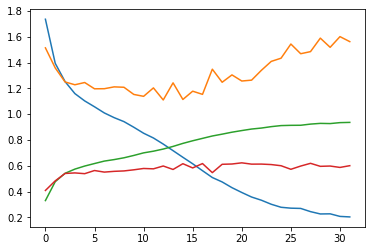

In [10]:
plt.plot(hist)

In [11]:
model = torch.load('/tf/data/Quan/fer2013/att_vgg_demo_2_3channels.pt')

In [12]:
# EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(test_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        acc = float((torch.argmax(outputs, dim=1) == labels).float().sum()/labels.size(0))
        loss = criterion(outputs, labels)

        running_valloss += loss.item()
        running_valacc += acc

    print('- Avg. val_loss: %.3f  | Avg. val_acc: %.3f' % (running_valloss / (i+1), running_valacc / (i+1)))

- Avg. val_loss: 1.224  | Avg. val_acc: 0.619


## Using face detector

In [7]:
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

def detect_face(img):
    
    img = np.uint8(np.array(img))
    faces = face_cascade.detectMultiScale(img)
    
    if len(faces) == 0:
        return np.uint8(img)
    
    else:
        
        x,y,w,h = faces[0]
        roi = img[y:y+h, x:x+w]
        
        return np.uint8(roi)

In [8]:
import torch
from torchvision import transforms, datasets

data_transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Lambda(detect_face),
#         transforms.Lambda(lbp_transform),
#         transforms.Lambda(combine_lbp_hog),
        transforms.ToPILImage(),
        # transforms.RandomSizedCrop(224),
#         transforms.RandomHorizontalFlip(),
#         transforms.RandomVerticalFlip(),
#         transforms.RandomRotation(degrees=180),
        transforms.Resize((48,48)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

train_fer = datasets.ImageFolder(root='/tf/data/Quan/fer2013/data/train', transform=data_transform)
val_fer = datasets.ImageFolder(root='/tf/data/Quan/fer2013/data/val', transform=data_transform)
test_fer = datasets.ImageFolder(root='/tf/data/Quan/fer2013/data/test', transform=data_transform)

batch_size = 128
train_loader = torch.utils.data.DataLoader(train_fer,
                                             batch_size=batch_size, shuffle=True,
                                             num_workers=8)
val_loader = torch.utils.data.DataLoader(val_fer,
                                             batch_size=batch_size, shuffle=True,
                                             num_workers=8)
test_loader = torch.utils.data.DataLoader(test_fer,
                                             batch_size=batch_size, shuffle=True,
                                             num_workers=8)

In [10]:
model = model.to(device)

model_path = '/tf/data/Quan/fer2013/att_vgg_demo_2_facedetector.pt'
best_acc = 0.0
hist = []

for epoch in range(60):  # loop over the dataset multiple times
    
    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0

    # TRAIN
    model.train()
    for i, data in enumerate(train_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        acc = float((torch.argmax(outputs, dim=1) == labels).float().sum()/labels.size(0))
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        running_acc += acc
        print('\t - Step %d: loss: %.3f acc: %.3f' % (i+1, loss.item(), acc))

    print('- Avg.loss: %.3f  | Avg.acc: %.3f' % (running_loss / (i+1), running_acc / (i+1)))
    avgloss = running_loss / (i+1)
    avgacc = running_acc / (i+1)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        acc = float((torch.argmax(outputs, dim=1) == labels).float().sum()/labels.size(0))
        loss = criterion(outputs, labels)

        running_valloss += loss.item()
        running_valacc += acc

    print('- Avg. val_loss: %.3f  | Avg. val_acc: %.3f' % (running_valloss / (i+1), running_valacc / (i+1)))

    avgvalloss = running_valloss / (i+1)
    avgvalcc = running_valacc / (i+1)

    hist.append([avgloss, avgvalloss, avgacc, avgvalcc])
    
    if best_acc < (running_valacc / (i+1)):
        best_acc = (running_valacc / (i+1))
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')

Epoch:  1
	 - Step 1: loss: 2.245 acc: 0.148
	 - Step 2: loss: 2.222 acc: 0.148
	 - Step 3: loss: 2.270 acc: 0.094
	 - Step 4: loss: 2.178 acc: 0.156
	 - Step 5: loss: 2.301 acc: 0.117
	 - Step 6: loss: 1.964 acc: 0.156
	 - Step 7: loss: 1.965 acc: 0.148
	 - Step 8: loss: 1.936 acc: 0.188
	 - Step 9: loss: 1.927 acc: 0.156
	 - Step 10: loss: 2.084 acc: 0.242
	 - Step 11: loss: 1.937 acc: 0.195
	 - Step 12: loss: 2.094 acc: 0.172
	 - Step 13: loss: 2.062 acc: 0.211
	 - Step 14: loss: 1.945 acc: 0.180
	 - Step 15: loss: 2.011 acc: 0.188
	 - Step 16: loss: 1.944 acc: 0.164
	 - Step 17: loss: 1.932 acc: 0.125
	 - Step 18: loss: 1.954 acc: 0.211
	 - Step 19: loss: 1.913 acc: 0.148
	 - Step 20: loss: 2.051 acc: 0.156
	 - Step 21: loss: 1.990 acc: 0.211
	 - Step 22: loss: 2.045 acc: 0.164
	 - Step 23: loss: 1.914 acc: 0.148
	 - Step 24: loss: 1.882 acc: 0.242
	 - Step 25: loss: 1.929 acc: 0.172
	 - Step 26: loss: 1.959 acc: 0.148
	 - Step 27: loss: 1.932 acc: 0.133
	 - Step 28: loss: 1.998 ac

- Avg. val_loss: 1.527  | Avg. val_acc: 0.414
* Update optimal model
Epoch:  2


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type SVGG. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type SVblock. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type WeightFeature. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


	 - Step 1: loss: 1.505 acc: 0.453
	 - Step 2: loss: 1.445 acc: 0.422
	 - Step 3: loss: 1.656 acc: 0.391
	 - Step 4: loss: 1.416 acc: 0.484
	 - Step 5: loss: 1.630 acc: 0.344
	 - Step 6: loss: 1.522 acc: 0.484
	 - Step 7: loss: 1.529 acc: 0.375
	 - Step 8: loss: 1.532 acc: 0.430
	 - Step 9: loss: 1.373 acc: 0.523
	 - Step 10: loss: 1.452 acc: 0.492
	 - Step 11: loss: 1.621 acc: 0.336
	 - Step 12: loss: 1.491 acc: 0.398
	 - Step 13: loss: 1.424 acc: 0.445
	 - Step 14: loss: 1.552 acc: 0.352
	 - Step 15: loss: 1.407 acc: 0.461
	 - Step 16: loss: 1.413 acc: 0.492
	 - Step 17: loss: 1.464 acc: 0.438
	 - Step 18: loss: 1.446 acc: 0.453
	 - Step 19: loss: 1.515 acc: 0.430
	 - Step 20: loss: 1.494 acc: 0.477
	 - Step 21: loss: 1.424 acc: 0.516
	 - Step 22: loss: 1.492 acc: 0.469
	 - Step 23: loss: 1.498 acc: 0.438
	 - Step 24: loss: 1.466 acc: 0.469
	 - Step 25: loss: 1.370 acc: 0.500
	 - Step 26: loss: 1.461 acc: 0.516
	 - Step 27: loss: 1.321 acc: 0.516
	 - Step 28: loss: 1.361 acc: 0.500
	

- Avg. val_loss: 1.490  | Avg. val_acc: 0.434
* Update optimal model
Epoch:  3
	 - Step 1: loss: 1.171 acc: 0.609
	 - Step 2: loss: 1.267 acc: 0.586
	 - Step 3: loss: 1.312 acc: 0.539
	 - Step 4: loss: 1.344 acc: 0.516
	 - Step 5: loss: 1.304 acc: 0.500
	 - Step 6: loss: 1.269 acc: 0.539
	 - Step 7: loss: 1.192 acc: 0.562
	 - Step 8: loss: 1.299 acc: 0.516
	 - Step 9: loss: 1.272 acc: 0.562
	 - Step 10: loss: 1.239 acc: 0.523
	 - Step 11: loss: 1.342 acc: 0.453
	 - Step 12: loss: 1.357 acc: 0.469
	 - Step 13: loss: 1.225 acc: 0.562
	 - Step 14: loss: 1.242 acc: 0.586
	 - Step 15: loss: 1.304 acc: 0.484
	 - Step 16: loss: 1.392 acc: 0.445
	 - Step 17: loss: 1.234 acc: 0.547
	 - Step 18: loss: 1.362 acc: 0.469
	 - Step 19: loss: 1.398 acc: 0.492
	 - Step 20: loss: 1.270 acc: 0.508
	 - Step 21: loss: 1.271 acc: 0.508
	 - Step 22: loss: 1.256 acc: 0.547
	 - Step 23: loss: 1.242 acc: 0.602
	 - Step 24: loss: 1.386 acc: 0.461
	 - Step 25: loss: 1.243 acc: 0.570
	 - Step 26: loss: 1.185 acc: 

	 - Step 225: loss: 1.137 acc: 0.541
- Avg.loss: 1.257  | Avg.acc: 0.537
- Avg. val_loss: 1.335  | Avg. val_acc: 0.489
* Update optimal model
Epoch:  4
	 - Step 1: loss: 1.182 acc: 0.594
	 - Step 2: loss: 1.261 acc: 0.555
	 - Step 3: loss: 1.237 acc: 0.570
	 - Step 4: loss: 1.141 acc: 0.594
	 - Step 5: loss: 1.308 acc: 0.531
	 - Step 6: loss: 1.151 acc: 0.578
	 - Step 7: loss: 1.213 acc: 0.531
	 - Step 8: loss: 1.125 acc: 0.578
	 - Step 9: loss: 1.464 acc: 0.477
	 - Step 10: loss: 1.222 acc: 0.547
	 - Step 11: loss: 1.209 acc: 0.555
	 - Step 12: loss: 1.247 acc: 0.570
	 - Step 13: loss: 1.203 acc: 0.562
	 - Step 14: loss: 1.182 acc: 0.547
	 - Step 15: loss: 1.093 acc: 0.633
	 - Step 16: loss: 1.309 acc: 0.500
	 - Step 17: loss: 1.102 acc: 0.562
	 - Step 18: loss: 1.149 acc: 0.555
	 - Step 19: loss: 1.229 acc: 0.516
	 - Step 20: loss: 1.223 acc: 0.570
	 - Step 21: loss: 1.256 acc: 0.547
	 - Step 22: loss: 1.189 acc: 0.555
	 - Step 23: loss: 1.287 acc: 0.477
	 - Step 24: loss: 1.224 acc:

	 - Step 223: loss: 1.076 acc: 0.594
	 - Step 224: loss: 1.102 acc: 0.633
	 - Step 225: loss: 1.222 acc: 0.514
- Avg.loss: 1.172  | Avg.acc: 0.574
- Avg. val_loss: 1.264  | Avg. val_acc: 0.544
* Update optimal model
Epoch:  5
	 - Step 1: loss: 1.107 acc: 0.586
	 - Step 2: loss: 1.223 acc: 0.523
	 - Step 3: loss: 1.127 acc: 0.562
	 - Step 4: loss: 1.092 acc: 0.609
	 - Step 5: loss: 1.152 acc: 0.609
	 - Step 6: loss: 1.262 acc: 0.547
	 - Step 7: loss: 1.323 acc: 0.461
	 - Step 8: loss: 1.131 acc: 0.609
	 - Step 9: loss: 1.052 acc: 0.633
	 - Step 10: loss: 1.193 acc: 0.539
	 - Step 11: loss: 0.939 acc: 0.695
	 - Step 12: loss: 1.124 acc: 0.578
	 - Step 13: loss: 1.161 acc: 0.562
	 - Step 14: loss: 1.098 acc: 0.656
	 - Step 15: loss: 1.002 acc: 0.648
	 - Step 16: loss: 1.261 acc: 0.531
	 - Step 17: loss: 1.075 acc: 0.539
	 - Step 18: loss: 1.313 acc: 0.477
	 - Step 19: loss: 1.120 acc: 0.617
	 - Step 20: loss: 1.118 acc: 0.586
	 - Step 21: loss: 1.115 acc: 0.570
	 - Step 22: loss: 1.141 ac

	 - Step 221: loss: 0.986 acc: 0.602
	 - Step 222: loss: 1.168 acc: 0.594
	 - Step 223: loss: 1.012 acc: 0.641
	 - Step 224: loss: 1.066 acc: 0.570
	 - Step 225: loss: 1.035 acc: 0.622
- Avg.loss: 1.108  | Avg.acc: 0.598
- Avg. val_loss: 1.237  | Avg. val_acc: 0.519
Epoch:  6
	 - Step 1: loss: 1.124 acc: 0.609
	 - Step 2: loss: 1.032 acc: 0.672
	 - Step 3: loss: 1.033 acc: 0.617
	 - Step 4: loss: 0.988 acc: 0.617
	 - Step 5: loss: 1.114 acc: 0.578
	 - Step 6: loss: 1.060 acc: 0.633
	 - Step 7: loss: 1.095 acc: 0.617
	 - Step 8: loss: 1.108 acc: 0.586
	 - Step 9: loss: 1.070 acc: 0.625
	 - Step 10: loss: 1.116 acc: 0.578
	 - Step 11: loss: 1.213 acc: 0.531
	 - Step 12: loss: 1.102 acc: 0.609
	 - Step 13: loss: 1.141 acc: 0.609
	 - Step 14: loss: 0.966 acc: 0.672
	 - Step 15: loss: 1.178 acc: 0.539
	 - Step 16: loss: 0.900 acc: 0.695
	 - Step 17: loss: 1.010 acc: 0.633
	 - Step 18: loss: 1.142 acc: 0.578
	 - Step 19: loss: 1.160 acc: 0.609
	 - Step 20: loss: 1.139 acc: 0.570
	 - Step 21:

	 - Step 219: loss: 0.917 acc: 0.656
	 - Step 220: loss: 1.045 acc: 0.617
	 - Step 221: loss: 1.018 acc: 0.633
	 - Step 222: loss: 1.033 acc: 0.648
	 - Step 223: loss: 1.098 acc: 0.609
	 - Step 224: loss: 1.204 acc: 0.523
	 - Step 225: loss: 1.050 acc: 0.541
- Avg.loss: 1.069  | Avg.acc: 0.612
- Avg. val_loss: 1.119  | Avg. val_acc: 0.596
* Update optimal model
Epoch:  7
	 - Step 1: loss: 1.042 acc: 0.586
	 - Step 2: loss: 0.969 acc: 0.672
	 - Step 3: loss: 0.983 acc: 0.641
	 - Step 4: loss: 1.066 acc: 0.625
	 - Step 5: loss: 1.054 acc: 0.555
	 - Step 6: loss: 1.222 acc: 0.562
	 - Step 7: loss: 1.052 acc: 0.664
	 - Step 8: loss: 1.044 acc: 0.656
	 - Step 9: loss: 0.997 acc: 0.641
	 - Step 10: loss: 1.035 acc: 0.688
	 - Step 11: loss: 1.081 acc: 0.586
	 - Step 12: loss: 1.050 acc: 0.633
	 - Step 13: loss: 1.039 acc: 0.664
	 - Step 14: loss: 1.080 acc: 0.578
	 - Step 15: loss: 1.044 acc: 0.578
	 - Step 16: loss: 1.065 acc: 0.586
	 - Step 17: loss: 1.088 acc: 0.664
	 - Step 18: loss: 1.03

	 - Step 217: loss: 1.098 acc: 0.562
	 - Step 218: loss: 0.998 acc: 0.656
	 - Step 219: loss: 1.010 acc: 0.656
	 - Step 220: loss: 0.841 acc: 0.711
	 - Step 221: loss: 0.936 acc: 0.633
	 - Step 222: loss: 1.174 acc: 0.578
	 - Step 223: loss: 0.989 acc: 0.625
	 - Step 224: loss: 0.918 acc: 0.688
	 - Step 225: loss: 1.006 acc: 0.649
- Avg.loss: 1.030  | Avg.acc: 0.626
- Avg. val_loss: 1.152  | Avg. val_acc: 0.576
Epoch:  8
	 - Step 1: loss: 0.959 acc: 0.672
	 - Step 2: loss: 0.908 acc: 0.734
	 - Step 3: loss: 1.013 acc: 0.656
	 - Step 4: loss: 0.819 acc: 0.734
	 - Step 5: loss: 1.098 acc: 0.625
	 - Step 6: loss: 0.931 acc: 0.656
	 - Step 7: loss: 0.892 acc: 0.727
	 - Step 8: loss: 0.969 acc: 0.609
	 - Step 9: loss: 1.001 acc: 0.625
	 - Step 10: loss: 0.887 acc: 0.656
	 - Step 11: loss: 0.867 acc: 0.664
	 - Step 12: loss: 0.954 acc: 0.695
	 - Step 13: loss: 0.865 acc: 0.727
	 - Step 14: loss: 0.983 acc: 0.625
	 - Step 15: loss: 0.877 acc: 0.703
	 - Step 16: loss: 0.935 acc: 0.609
	 - Step

	 - Step 215: loss: 0.880 acc: 0.727
	 - Step 216: loss: 0.934 acc: 0.656
	 - Step 217: loss: 1.075 acc: 0.602
	 - Step 218: loss: 0.940 acc: 0.688
	 - Step 219: loss: 1.023 acc: 0.625
	 - Step 220: loss: 0.921 acc: 0.711
	 - Step 221: loss: 0.970 acc: 0.664
	 - Step 222: loss: 0.951 acc: 0.641
	 - Step 223: loss: 1.060 acc: 0.648
	 - Step 224: loss: 0.906 acc: 0.695
	 - Step 225: loss: 1.576 acc: 0.405
- Avg.loss: 0.995  | Avg.acc: 0.642
- Avg. val_loss: 1.114  | Avg. val_acc: 0.585
Epoch:  9
	 - Step 1: loss: 0.960 acc: 0.656
	 - Step 2: loss: 1.067 acc: 0.617
	 - Step 3: loss: 0.829 acc: 0.734
	 - Step 4: loss: 0.917 acc: 0.703
	 - Step 5: loss: 0.972 acc: 0.664
	 - Step 6: loss: 0.966 acc: 0.641
	 - Step 7: loss: 0.816 acc: 0.727
	 - Step 8: loss: 0.843 acc: 0.734
	 - Step 9: loss: 0.871 acc: 0.688
	 - Step 10: loss: 0.971 acc: 0.664
	 - Step 11: loss: 0.861 acc: 0.727
	 - Step 12: loss: 1.032 acc: 0.609
	 - Step 13: loss: 0.989 acc: 0.625
	 - Step 14: loss: 0.859 acc: 0.695
	 - St

	 - Step 213: loss: 0.936 acc: 0.641
	 - Step 214: loss: 0.927 acc: 0.680
	 - Step 215: loss: 1.132 acc: 0.633
	 - Step 216: loss: 0.841 acc: 0.695
	 - Step 217: loss: 1.013 acc: 0.625
	 - Step 218: loss: 1.079 acc: 0.617
	 - Step 219: loss: 0.946 acc: 0.703
	 - Step 220: loss: 0.966 acc: 0.617
	 - Step 221: loss: 0.933 acc: 0.688
	 - Step 222: loss: 0.895 acc: 0.641
	 - Step 223: loss: 0.984 acc: 0.617
	 - Step 224: loss: 0.937 acc: 0.664
	 - Step 225: loss: 1.150 acc: 0.541
- Avg.loss: 0.957  | Avg.acc: 0.655
- Avg. val_loss: 1.115  | Avg. val_acc: 0.591
Epoch:  10
	 - Step 1: loss: 0.759 acc: 0.742
	 - Step 2: loss: 0.960 acc: 0.711
	 - Step 3: loss: 0.910 acc: 0.656
	 - Step 4: loss: 0.958 acc: 0.664
	 - Step 5: loss: 0.882 acc: 0.734
	 - Step 6: loss: 0.749 acc: 0.781
	 - Step 7: loss: 0.928 acc: 0.688
	 - Step 8: loss: 0.844 acc: 0.727
	 - Step 9: loss: 0.780 acc: 0.727
	 - Step 10: loss: 0.879 acc: 0.688
	 - Step 11: loss: 0.937 acc: 0.664
	 - Step 12: loss: 0.851 acc: 0.711
	 -

	 - Step 211: loss: 0.944 acc: 0.664
	 - Step 212: loss: 1.038 acc: 0.641
	 - Step 213: loss: 0.965 acc: 0.648
	 - Step 214: loss: 1.045 acc: 0.602
	 - Step 215: loss: 1.024 acc: 0.672
	 - Step 216: loss: 0.928 acc: 0.648
	 - Step 217: loss: 0.897 acc: 0.688
	 - Step 218: loss: 1.175 acc: 0.562
	 - Step 219: loss: 0.926 acc: 0.648
	 - Step 220: loss: 0.842 acc: 0.719
	 - Step 221: loss: 0.807 acc: 0.711
	 - Step 222: loss: 0.884 acc: 0.719
	 - Step 223: loss: 0.803 acc: 0.711
	 - Step 224: loss: 0.973 acc: 0.641
	 - Step 225: loss: 0.809 acc: 0.622
- Avg.loss: 0.926  | Avg.acc: 0.671
- Avg. val_loss: 1.185  | Avg. val_acc: 0.579
Epoch:  11
	 - Step 1: loss: 0.887 acc: 0.719
	 - Step 2: loss: 0.869 acc: 0.688
	 - Step 3: loss: 0.823 acc: 0.727
	 - Step 4: loss: 1.010 acc: 0.617
	 - Step 5: loss: 0.725 acc: 0.750
	 - Step 6: loss: 0.855 acc: 0.703
	 - Step 7: loss: 0.719 acc: 0.758
	 - Step 8: loss: 0.652 acc: 0.781
	 - Step 9: loss: 0.903 acc: 0.742
	 - Step 10: loss: 0.721 acc: 0.742
	

	 - Step 209: loss: 0.855 acc: 0.727
	 - Step 210: loss: 0.748 acc: 0.742
	 - Step 211: loss: 1.021 acc: 0.680
	 - Step 212: loss: 0.913 acc: 0.695
	 - Step 213: loss: 0.932 acc: 0.680
	 - Step 214: loss: 0.920 acc: 0.688
	 - Step 215: loss: 0.799 acc: 0.703
	 - Step 216: loss: 0.830 acc: 0.695
	 - Step 217: loss: 0.931 acc: 0.727
	 - Step 218: loss: 0.975 acc: 0.703
	 - Step 219: loss: 0.845 acc: 0.680
	 - Step 220: loss: 1.001 acc: 0.641
	 - Step 221: loss: 0.795 acc: 0.719
	 - Step 222: loss: 0.872 acc: 0.727
	 - Step 223: loss: 0.782 acc: 0.734
	 - Step 224: loss: 0.828 acc: 0.711
	 - Step 225: loss: 1.173 acc: 0.568
- Avg.loss: 0.883  | Avg.acc: 0.691
- Avg. val_loss: 1.188  | Avg. val_acc: 0.580
Epoch:  12
	 - Step 1: loss: 0.838 acc: 0.727
	 - Step 2: loss: 0.848 acc: 0.695
	 - Step 3: loss: 0.768 acc: 0.711
	 - Step 4: loss: 0.679 acc: 0.773
	 - Step 5: loss: 0.666 acc: 0.789
	 - Step 6: loss: 0.741 acc: 0.750
	 - Step 7: loss: 0.864 acc: 0.719
	 - Step 8: loss: 0.928 acc: 0.69

	 - Step 207: loss: 0.908 acc: 0.641
	 - Step 208: loss: 0.865 acc: 0.664
	 - Step 209: loss: 0.915 acc: 0.695
	 - Step 210: loss: 0.784 acc: 0.719
	 - Step 211: loss: 0.770 acc: 0.758
	 - Step 212: loss: 0.948 acc: 0.641
	 - Step 213: loss: 0.858 acc: 0.727
	 - Step 214: loss: 0.860 acc: 0.680
	 - Step 215: loss: 0.686 acc: 0.758
	 - Step 216: loss: 0.778 acc: 0.711
	 - Step 217: loss: 0.852 acc: 0.742
	 - Step 218: loss: 0.824 acc: 0.711
	 - Step 219: loss: 1.031 acc: 0.602
	 - Step 220: loss: 0.886 acc: 0.672
	 - Step 221: loss: 0.729 acc: 0.719
	 - Step 222: loss: 0.702 acc: 0.750
	 - Step 223: loss: 0.821 acc: 0.742
	 - Step 224: loss: 0.888 acc: 0.703
	 - Step 225: loss: 0.716 acc: 0.838
- Avg.loss: 0.844  | Avg.acc: 0.702
- Avg. val_loss: 1.217  | Avg. val_acc: 0.576
Epoch:  13
	 - Step 1: loss: 0.744 acc: 0.766
	 - Step 2: loss: 0.810 acc: 0.734
	 - Step 3: loss: 0.815 acc: 0.727
	 - Step 4: loss: 0.681 acc: 0.781
	 - Step 5: loss: 0.764 acc: 0.742
	 - Step 6: loss: 0.793 acc: 

	 - Step 205: loss: 0.900 acc: 0.695
	 - Step 206: loss: 0.808 acc: 0.734
	 - Step 207: loss: 0.870 acc: 0.648
	 - Step 208: loss: 0.758 acc: 0.734
	 - Step 209: loss: 0.839 acc: 0.727
	 - Step 210: loss: 0.779 acc: 0.734
	 - Step 211: loss: 0.749 acc: 0.727
	 - Step 212: loss: 0.785 acc: 0.703
	 - Step 213: loss: 0.802 acc: 0.742
	 - Step 214: loss: 0.812 acc: 0.656
	 - Step 215: loss: 0.732 acc: 0.758
	 - Step 216: loss: 0.846 acc: 0.688
	 - Step 217: loss: 0.854 acc: 0.711
	 - Step 218: loss: 0.793 acc: 0.734
	 - Step 219: loss: 0.906 acc: 0.641
	 - Step 220: loss: 0.780 acc: 0.727
	 - Step 221: loss: 0.922 acc: 0.688
	 - Step 222: loss: 0.747 acc: 0.711
	 - Step 223: loss: 0.894 acc: 0.703
	 - Step 224: loss: 0.830 acc: 0.703
	 - Step 225: loss: 1.087 acc: 0.676
- Avg.loss: 0.801  | Avg.acc: 0.718
- Avg. val_loss: 1.204  | Avg. val_acc: 0.570
Epoch:  14
	 - Step 1: loss: 0.576 acc: 0.781
	 - Step 2: loss: 0.646 acc: 0.828
	 - Step 3: loss: 0.860 acc: 0.688
	 - Step 4: loss: 0.766 a

	 - Step 203: loss: 0.768 acc: 0.742
	 - Step 204: loss: 0.836 acc: 0.695
	 - Step 205: loss: 0.750 acc: 0.742
	 - Step 206: loss: 0.792 acc: 0.727
	 - Step 207: loss: 0.849 acc: 0.727
	 - Step 208: loss: 0.855 acc: 0.711
	 - Step 209: loss: 0.745 acc: 0.781
	 - Step 210: loss: 0.722 acc: 0.750
	 - Step 211: loss: 0.675 acc: 0.742
	 - Step 212: loss: 0.759 acc: 0.711
	 - Step 213: loss: 0.642 acc: 0.789
	 - Step 214: loss: 0.546 acc: 0.820
	 - Step 215: loss: 0.702 acc: 0.781
	 - Step 216: loss: 0.797 acc: 0.750
	 - Step 217: loss: 0.710 acc: 0.750
	 - Step 218: loss: 0.701 acc: 0.758
	 - Step 219: loss: 0.823 acc: 0.719
	 - Step 220: loss: 0.759 acc: 0.695
	 - Step 221: loss: 0.795 acc: 0.711
	 - Step 222: loss: 0.871 acc: 0.695
	 - Step 223: loss: 0.634 acc: 0.734
	 - Step 224: loss: 0.659 acc: 0.789
	 - Step 225: loss: 0.981 acc: 0.703
- Avg.loss: 0.760  | Avg.acc: 0.736
- Avg. val_loss: 1.072  | Avg. val_acc: 0.618
* Update optimal model
Epoch:  15
	 - Step 1: loss: 0.650 acc: 0.78

	 - Step 201: loss: 0.702 acc: 0.742
	 - Step 202: loss: 0.738 acc: 0.758
	 - Step 203: loss: 0.688 acc: 0.766
	 - Step 204: loss: 0.772 acc: 0.711
	 - Step 205: loss: 0.868 acc: 0.672
	 - Step 206: loss: 0.677 acc: 0.750
	 - Step 207: loss: 0.749 acc: 0.797
	 - Step 208: loss: 0.749 acc: 0.742
	 - Step 209: loss: 0.801 acc: 0.703
	 - Step 210: loss: 0.789 acc: 0.734
	 - Step 211: loss: 0.603 acc: 0.797
	 - Step 212: loss: 0.771 acc: 0.719
	 - Step 213: loss: 0.790 acc: 0.703
	 - Step 214: loss: 0.765 acc: 0.758
	 - Step 215: loss: 0.789 acc: 0.727
	 - Step 216: loss: 0.649 acc: 0.797
	 - Step 217: loss: 0.653 acc: 0.758
	 - Step 218: loss: 0.671 acc: 0.789
	 - Step 219: loss: 0.757 acc: 0.703
	 - Step 220: loss: 0.804 acc: 0.719
	 - Step 221: loss: 0.590 acc: 0.797
	 - Step 222: loss: 0.836 acc: 0.711
	 - Step 223: loss: 0.890 acc: 0.695
	 - Step 224: loss: 0.750 acc: 0.672
	 - Step 225: loss: 0.846 acc: 0.676
- Avg.loss: 0.709  | Avg.acc: 0.755
- Avg. val_loss: 1.189  | Avg. val_acc:

	 - Step 199: loss: 0.600 acc: 0.844
	 - Step 200: loss: 0.716 acc: 0.719
	 - Step 201: loss: 0.639 acc: 0.820
	 - Step 202: loss: 0.692 acc: 0.766
	 - Step 203: loss: 0.790 acc: 0.703
	 - Step 204: loss: 0.719 acc: 0.758
	 - Step 205: loss: 0.697 acc: 0.734
	 - Step 206: loss: 0.692 acc: 0.789
	 - Step 207: loss: 0.686 acc: 0.758
	 - Step 208: loss: 0.738 acc: 0.750
	 - Step 209: loss: 0.698 acc: 0.766
	 - Step 210: loss: 0.655 acc: 0.781
	 - Step 211: loss: 0.763 acc: 0.695
	 - Step 212: loss: 0.744 acc: 0.758
	 - Step 213: loss: 0.635 acc: 0.773
	 - Step 214: loss: 0.738 acc: 0.750
	 - Step 215: loss: 0.750 acc: 0.734
	 - Step 216: loss: 0.597 acc: 0.812
	 - Step 217: loss: 0.786 acc: 0.750
	 - Step 218: loss: 0.668 acc: 0.812
	 - Step 219: loss: 0.652 acc: 0.758
	 - Step 220: loss: 0.749 acc: 0.711
	 - Step 221: loss: 0.775 acc: 0.703
	 - Step 222: loss: 0.511 acc: 0.820
	 - Step 223: loss: 0.809 acc: 0.727
	 - Step 224: loss: 0.736 acc: 0.734
	 - Step 225: loss: 0.698 acc: 0.730
-

	 - Step 197: loss: 0.584 acc: 0.766
	 - Step 198: loss: 0.659 acc: 0.789
	 - Step 199: loss: 0.823 acc: 0.664
	 - Step 200: loss: 0.610 acc: 0.797
	 - Step 201: loss: 0.539 acc: 0.797
	 - Step 202: loss: 0.612 acc: 0.781
	 - Step 203: loss: 0.522 acc: 0.836
	 - Step 204: loss: 0.668 acc: 0.773
	 - Step 205: loss: 0.669 acc: 0.758
	 - Step 206: loss: 0.631 acc: 0.781
	 - Step 207: loss: 0.637 acc: 0.781
	 - Step 208: loss: 0.617 acc: 0.781
	 - Step 209: loss: 0.718 acc: 0.781
	 - Step 210: loss: 0.673 acc: 0.773
	 - Step 211: loss: 0.679 acc: 0.797
	 - Step 212: loss: 0.761 acc: 0.758
	 - Step 213: loss: 0.591 acc: 0.797
	 - Step 214: loss: 0.639 acc: 0.781
	 - Step 215: loss: 0.702 acc: 0.734
	 - Step 216: loss: 0.641 acc: 0.789
	 - Step 217: loss: 0.718 acc: 0.711
	 - Step 218: loss: 0.666 acc: 0.797
	 - Step 219: loss: 0.647 acc: 0.766
	 - Step 220: loss: 0.894 acc: 0.750
	 - Step 221: loss: 0.676 acc: 0.773
	 - Step 222: loss: 0.666 acc: 0.750
	 - Step 223: loss: 0.762 acc: 0.727
	

	 - Step 195: loss: 0.602 acc: 0.781
	 - Step 196: loss: 0.537 acc: 0.797
	 - Step 197: loss: 0.544 acc: 0.805
	 - Step 198: loss: 0.660 acc: 0.797
	 - Step 199: loss: 0.687 acc: 0.750
	 - Step 200: loss: 0.582 acc: 0.789
	 - Step 201: loss: 0.682 acc: 0.766
	 - Step 202: loss: 0.546 acc: 0.828
	 - Step 203: loss: 0.709 acc: 0.727
	 - Step 204: loss: 0.531 acc: 0.812
	 - Step 205: loss: 0.612 acc: 0.805
	 - Step 206: loss: 0.443 acc: 0.867
	 - Step 207: loss: 0.491 acc: 0.836
	 - Step 208: loss: 0.836 acc: 0.727
	 - Step 209: loss: 0.733 acc: 0.758
	 - Step 210: loss: 0.477 acc: 0.836
	 - Step 211: loss: 0.523 acc: 0.820
	 - Step 212: loss: 0.626 acc: 0.789
	 - Step 213: loss: 0.590 acc: 0.797
	 - Step 214: loss: 0.669 acc: 0.789
	 - Step 215: loss: 0.508 acc: 0.812
	 - Step 216: loss: 0.612 acc: 0.828
	 - Step 217: loss: 0.501 acc: 0.820
	 - Step 218: loss: 0.575 acc: 0.797
	 - Step 219: loss: 0.623 acc: 0.750
	 - Step 220: loss: 0.596 acc: 0.805
	 - Step 221: loss: 0.495 acc: 0.812
	

	 - Step 193: loss: 0.678 acc: 0.781
	 - Step 194: loss: 0.496 acc: 0.836
	 - Step 195: loss: 0.664 acc: 0.797
	 - Step 196: loss: 0.653 acc: 0.781
	 - Step 197: loss: 0.550 acc: 0.828
	 - Step 198: loss: 0.667 acc: 0.766
	 - Step 199: loss: 0.439 acc: 0.859
	 - Step 200: loss: 0.596 acc: 0.797
	 - Step 201: loss: 0.644 acc: 0.812
	 - Step 202: loss: 0.515 acc: 0.836
	 - Step 203: loss: 0.609 acc: 0.812
	 - Step 204: loss: 0.463 acc: 0.852
	 - Step 205: loss: 0.562 acc: 0.789
	 - Step 206: loss: 0.568 acc: 0.773
	 - Step 207: loss: 0.447 acc: 0.844
	 - Step 208: loss: 0.525 acc: 0.812
	 - Step 209: loss: 0.622 acc: 0.750
	 - Step 210: loss: 0.675 acc: 0.758
	 - Step 211: loss: 0.452 acc: 0.852
	 - Step 212: loss: 0.629 acc: 0.750
	 - Step 213: loss: 0.591 acc: 0.773
	 - Step 214: loss: 0.589 acc: 0.789
	 - Step 215: loss: 0.562 acc: 0.828
	 - Step 216: loss: 0.501 acc: 0.852
	 - Step 217: loss: 0.587 acc: 0.781
	 - Step 218: loss: 0.615 acc: 0.773
	 - Step 219: loss: 0.612 acc: 0.773
	

	 - Step 191: loss: 0.382 acc: 0.914
	 - Step 192: loss: 0.572 acc: 0.828
	 - Step 193: loss: 0.509 acc: 0.828
	 - Step 194: loss: 0.551 acc: 0.797
	 - Step 195: loss: 0.511 acc: 0.820
	 - Step 196: loss: 0.462 acc: 0.859
	 - Step 197: loss: 0.421 acc: 0.898
	 - Step 198: loss: 0.496 acc: 0.859
	 - Step 199: loss: 0.379 acc: 0.875
	 - Step 200: loss: 0.670 acc: 0.727
	 - Step 201: loss: 0.601 acc: 0.812
	 - Step 202: loss: 0.428 acc: 0.844
	 - Step 203: loss: 0.484 acc: 0.852
	 - Step 204: loss: 0.480 acc: 0.836
	 - Step 205: loss: 0.562 acc: 0.797
	 - Step 206: loss: 0.444 acc: 0.867
	 - Step 207: loss: 0.620 acc: 0.805
	 - Step 208: loss: 0.413 acc: 0.875
	 - Step 209: loss: 0.391 acc: 0.867
	 - Step 210: loss: 0.419 acc: 0.867
	 - Step 211: loss: 0.368 acc: 0.844
	 - Step 212: loss: 0.548 acc: 0.844
	 - Step 213: loss: 0.508 acc: 0.844
	 - Step 214: loss: 0.542 acc: 0.836
	 - Step 215: loss: 0.503 acc: 0.859
	 - Step 216: loss: 0.563 acc: 0.812
	 - Step 217: loss: 0.608 acc: 0.812
	

	 - Step 189: loss: 0.365 acc: 0.891
	 - Step 190: loss: 0.397 acc: 0.891
	 - Step 191: loss: 0.520 acc: 0.844
	 - Step 192: loss: 0.533 acc: 0.797
	 - Step 193: loss: 0.514 acc: 0.844
	 - Step 194: loss: 0.450 acc: 0.859
	 - Step 195: loss: 0.371 acc: 0.883
	 - Step 196: loss: 0.421 acc: 0.883
	 - Step 197: loss: 0.573 acc: 0.805
	 - Step 198: loss: 0.475 acc: 0.844
	 - Step 199: loss: 0.401 acc: 0.859
	 - Step 200: loss: 0.422 acc: 0.859
	 - Step 201: loss: 0.434 acc: 0.859
	 - Step 202: loss: 0.481 acc: 0.836
	 - Step 203: loss: 0.597 acc: 0.820
	 - Step 204: loss: 0.566 acc: 0.820
	 - Step 205: loss: 0.678 acc: 0.758
	 - Step 206: loss: 0.605 acc: 0.805
	 - Step 207: loss: 0.381 acc: 0.898
	 - Step 208: loss: 0.404 acc: 0.867
	 - Step 209: loss: 0.494 acc: 0.828
	 - Step 210: loss: 0.390 acc: 0.844
	 - Step 211: loss: 0.467 acc: 0.836
	 - Step 212: loss: 0.499 acc: 0.859
	 - Step 213: loss: 0.523 acc: 0.820
	 - Step 214: loss: 0.453 acc: 0.828
	 - Step 215: loss: 0.391 acc: 0.883
	

	 - Step 187: loss: 0.501 acc: 0.812
	 - Step 188: loss: 0.400 acc: 0.859
	 - Step 189: loss: 0.448 acc: 0.844
	 - Step 190: loss: 0.372 acc: 0.859
	 - Step 191: loss: 0.477 acc: 0.859
	 - Step 192: loss: 0.421 acc: 0.844
	 - Step 193: loss: 0.490 acc: 0.875
	 - Step 194: loss: 0.371 acc: 0.883
	 - Step 195: loss: 0.401 acc: 0.859
	 - Step 196: loss: 0.383 acc: 0.898
	 - Step 197: loss: 0.535 acc: 0.805
	 - Step 198: loss: 0.470 acc: 0.852
	 - Step 199: loss: 0.224 acc: 0.938
	 - Step 200: loss: 0.419 acc: 0.852
	 - Step 201: loss: 0.490 acc: 0.852
	 - Step 202: loss: 0.682 acc: 0.805
	 - Step 203: loss: 0.603 acc: 0.836
	 - Step 204: loss: 0.442 acc: 0.844
	 - Step 205: loss: 0.442 acc: 0.859
	 - Step 206: loss: 0.418 acc: 0.875
	 - Step 207: loss: 0.477 acc: 0.859
	 - Step 208: loss: 0.355 acc: 0.875
	 - Step 209: loss: 0.447 acc: 0.852
	 - Step 210: loss: 0.397 acc: 0.852
	 - Step 211: loss: 0.403 acc: 0.852
	 - Step 212: loss: 0.382 acc: 0.859
	 - Step 213: loss: 0.382 acc: 0.867
	

	 - Step 185: loss: 0.321 acc: 0.898
	 - Step 186: loss: 0.361 acc: 0.898
	 - Step 187: loss: 0.441 acc: 0.844
	 - Step 188: loss: 0.362 acc: 0.883
	 - Step 189: loss: 0.369 acc: 0.875
	 - Step 190: loss: 0.398 acc: 0.875
	 - Step 191: loss: 0.456 acc: 0.836
	 - Step 192: loss: 0.431 acc: 0.859
	 - Step 193: loss: 0.406 acc: 0.875
	 - Step 194: loss: 0.326 acc: 0.883
	 - Step 195: loss: 0.283 acc: 0.906
	 - Step 196: loss: 0.423 acc: 0.859
	 - Step 197: loss: 0.415 acc: 0.883
	 - Step 198: loss: 0.339 acc: 0.922
	 - Step 199: loss: 0.448 acc: 0.875
	 - Step 200: loss: 0.453 acc: 0.875
	 - Step 201: loss: 0.338 acc: 0.914
	 - Step 202: loss: 0.326 acc: 0.898
	 - Step 203: loss: 0.390 acc: 0.891
	 - Step 204: loss: 0.378 acc: 0.875
	 - Step 205: loss: 0.318 acc: 0.883
	 - Step 206: loss: 0.450 acc: 0.852
	 - Step 207: loss: 0.430 acc: 0.867
	 - Step 208: loss: 0.293 acc: 0.914
	 - Step 209: loss: 0.391 acc: 0.852
	 - Step 210: loss: 0.401 acc: 0.844
	 - Step 211: loss: 0.316 acc: 0.906
	

	 - Step 183: loss: 0.430 acc: 0.859
	 - Step 184: loss: 0.482 acc: 0.828
	 - Step 185: loss: 0.356 acc: 0.883
	 - Step 186: loss: 0.395 acc: 0.867
	 - Step 187: loss: 0.387 acc: 0.867
	 - Step 188: loss: 0.374 acc: 0.875
	 - Step 189: loss: 0.342 acc: 0.891
	 - Step 190: loss: 0.320 acc: 0.906
	 - Step 191: loss: 0.421 acc: 0.859
	 - Step 192: loss: 0.408 acc: 0.852
	 - Step 193: loss: 0.389 acc: 0.883
	 - Step 194: loss: 0.274 acc: 0.938
	 - Step 195: loss: 0.332 acc: 0.883
	 - Step 196: loss: 0.459 acc: 0.789
	 - Step 197: loss: 0.450 acc: 0.867
	 - Step 198: loss: 0.439 acc: 0.852
	 - Step 199: loss: 0.421 acc: 0.844
	 - Step 200: loss: 0.360 acc: 0.898
	 - Step 201: loss: 0.337 acc: 0.875
	 - Step 202: loss: 0.320 acc: 0.891
	 - Step 203: loss: 0.361 acc: 0.883
	 - Step 204: loss: 0.377 acc: 0.852
	 - Step 205: loss: 0.389 acc: 0.883
	 - Step 206: loss: 0.372 acc: 0.891
	 - Step 207: loss: 0.460 acc: 0.844
	 - Step 208: loss: 0.482 acc: 0.820
	 - Step 209: loss: 0.429 acc: 0.867
	

	 - Step 181: loss: 0.270 acc: 0.914
	 - Step 182: loss: 0.371 acc: 0.883
	 - Step 183: loss: 0.283 acc: 0.906
	 - Step 184: loss: 0.385 acc: 0.844
	 - Step 185: loss: 0.413 acc: 0.867
	 - Step 186: loss: 0.329 acc: 0.906
	 - Step 187: loss: 0.230 acc: 0.930
	 - Step 188: loss: 0.282 acc: 0.906
	 - Step 189: loss: 0.383 acc: 0.883
	 - Step 190: loss: 0.285 acc: 0.883
	 - Step 191: loss: 0.443 acc: 0.859
	 - Step 192: loss: 0.328 acc: 0.898
	 - Step 193: loss: 0.307 acc: 0.867
	 - Step 194: loss: 0.214 acc: 0.945
	 - Step 195: loss: 0.462 acc: 0.875
	 - Step 196: loss: 0.268 acc: 0.898
	 - Step 197: loss: 0.255 acc: 0.922
	 - Step 198: loss: 0.274 acc: 0.891
	 - Step 199: loss: 0.304 acc: 0.875
	 - Step 200: loss: 0.389 acc: 0.867
	 - Step 201: loss: 0.287 acc: 0.914
	 - Step 202: loss: 0.368 acc: 0.867
	 - Step 203: loss: 0.347 acc: 0.914
	 - Step 204: loss: 0.473 acc: 0.859
	 - Step 205: loss: 0.410 acc: 0.867
	 - Step 206: loss: 0.358 acc: 0.859
	 - Step 207: loss: 0.468 acc: 0.859
	

	 - Step 179: loss: 0.343 acc: 0.914
	 - Step 180: loss: 0.410 acc: 0.844
	 - Step 181: loss: 0.263 acc: 0.938
	 - Step 182: loss: 0.275 acc: 0.922
	 - Step 183: loss: 0.243 acc: 0.922
	 - Step 184: loss: 0.342 acc: 0.867
	 - Step 185: loss: 0.298 acc: 0.914
	 - Step 186: loss: 0.275 acc: 0.914
	 - Step 187: loss: 0.353 acc: 0.875
	 - Step 188: loss: 0.257 acc: 0.922
	 - Step 189: loss: 0.336 acc: 0.891
	 - Step 190: loss: 0.374 acc: 0.891
	 - Step 191: loss: 0.230 acc: 0.930
	 - Step 192: loss: 0.395 acc: 0.859
	 - Step 193: loss: 0.372 acc: 0.883
	 - Step 194: loss: 0.352 acc: 0.891
	 - Step 195: loss: 0.378 acc: 0.859
	 - Step 196: loss: 0.347 acc: 0.883
	 - Step 197: loss: 0.353 acc: 0.914
	 - Step 198: loss: 0.326 acc: 0.898
	 - Step 199: loss: 0.398 acc: 0.852
	 - Step 200: loss: 0.276 acc: 0.891
	 - Step 201: loss: 0.418 acc: 0.883
	 - Step 202: loss: 0.330 acc: 0.867
	 - Step 203: loss: 0.294 acc: 0.898
	 - Step 204: loss: 0.322 acc: 0.922
	 - Step 205: loss: 0.419 acc: 0.859
	

	 - Step 177: loss: 0.235 acc: 0.930
	 - Step 178: loss: 0.427 acc: 0.852
	 - Step 179: loss: 0.341 acc: 0.859
	 - Step 180: loss: 0.302 acc: 0.891
	 - Step 181: loss: 0.232 acc: 0.930
	 - Step 182: loss: 0.362 acc: 0.875
	 - Step 183: loss: 0.282 acc: 0.891
	 - Step 184: loss: 0.288 acc: 0.930
	 - Step 185: loss: 0.404 acc: 0.891
	 - Step 186: loss: 0.252 acc: 0.938
	 - Step 187: loss: 0.242 acc: 0.914
	 - Step 188: loss: 0.328 acc: 0.891
	 - Step 189: loss: 0.438 acc: 0.859
	 - Step 190: loss: 0.315 acc: 0.922
	 - Step 191: loss: 0.452 acc: 0.812
	 - Step 192: loss: 0.382 acc: 0.883
	 - Step 193: loss: 0.298 acc: 0.914
	 - Step 194: loss: 0.300 acc: 0.875
	 - Step 195: loss: 0.258 acc: 0.938
	 - Step 196: loss: 0.269 acc: 0.906
	 - Step 197: loss: 0.268 acc: 0.922
	 - Step 198: loss: 0.312 acc: 0.930
	 - Step 199: loss: 0.245 acc: 0.945
	 - Step 200: loss: 0.400 acc: 0.891
	 - Step 201: loss: 0.414 acc: 0.898
	 - Step 202: loss: 0.231 acc: 0.898
	 - Step 203: loss: 0.243 acc: 0.922
	

	 - Step 175: loss: 0.214 acc: 0.945
	 - Step 176: loss: 0.263 acc: 0.938
	 - Step 177: loss: 0.262 acc: 0.906
	 - Step 178: loss: 0.329 acc: 0.898
	 - Step 179: loss: 0.355 acc: 0.883
	 - Step 180: loss: 0.342 acc: 0.898
	 - Step 181: loss: 0.253 acc: 0.922
	 - Step 182: loss: 0.400 acc: 0.875
	 - Step 183: loss: 0.281 acc: 0.906
	 - Step 184: loss: 0.248 acc: 0.930
	 - Step 185: loss: 0.305 acc: 0.914
	 - Step 186: loss: 0.226 acc: 0.930
	 - Step 187: loss: 0.349 acc: 0.898
	 - Step 188: loss: 0.340 acc: 0.875
	 - Step 189: loss: 0.380 acc: 0.883
	 - Step 190: loss: 0.209 acc: 0.938
	 - Step 191: loss: 0.286 acc: 0.898
	 - Step 192: loss: 0.326 acc: 0.852
	 - Step 193: loss: 0.195 acc: 0.945
	 - Step 194: loss: 0.377 acc: 0.875
	 - Step 195: loss: 0.313 acc: 0.914
	 - Step 196: loss: 0.278 acc: 0.914
	 - Step 197: loss: 0.305 acc: 0.891
	 - Step 198: loss: 0.249 acc: 0.930
	 - Step 199: loss: 0.348 acc: 0.875
	 - Step 200: loss: 0.192 acc: 0.938
	 - Step 201: loss: 0.249 acc: 0.906
	

	 - Step 173: loss: 0.302 acc: 0.883
	 - Step 174: loss: 0.346 acc: 0.875
	 - Step 175: loss: 0.321 acc: 0.906
	 - Step 176: loss: 0.359 acc: 0.867
	 - Step 177: loss: 0.216 acc: 0.930
	 - Step 178: loss: 0.208 acc: 0.922
	 - Step 179: loss: 0.411 acc: 0.906
	 - Step 180: loss: 0.215 acc: 0.930
	 - Step 181: loss: 0.432 acc: 0.859
	 - Step 182: loss: 0.247 acc: 0.914
	 - Step 183: loss: 0.371 acc: 0.844
	 - Step 184: loss: 0.275 acc: 0.891
	 - Step 185: loss: 0.360 acc: 0.875
	 - Step 186: loss: 0.375 acc: 0.883
	 - Step 187: loss: 0.211 acc: 0.945
	 - Step 188: loss: 0.421 acc: 0.859
	 - Step 189: loss: 0.293 acc: 0.891
	 - Step 190: loss: 0.261 acc: 0.922
	 - Step 191: loss: 0.262 acc: 0.922
	 - Step 192: loss: 0.313 acc: 0.906
	 - Step 193: loss: 0.346 acc: 0.898
	 - Step 194: loss: 0.509 acc: 0.828
	 - Step 195: loss: 0.402 acc: 0.891
	 - Step 196: loss: 0.279 acc: 0.906
	 - Step 197: loss: 0.292 acc: 0.914
	 - Step 198: loss: 0.292 acc: 0.883
	 - Step 199: loss: 0.320 acc: 0.898
	

	 - Step 171: loss: 0.335 acc: 0.883
	 - Step 172: loss: 0.242 acc: 0.930
	 - Step 173: loss: 0.247 acc: 0.938
	 - Step 174: loss: 0.363 acc: 0.914
	 - Step 175: loss: 0.245 acc: 0.930
	 - Step 176: loss: 0.212 acc: 0.938
	 - Step 177: loss: 0.191 acc: 0.938
	 - Step 178: loss: 0.287 acc: 0.914
	 - Step 179: loss: 0.318 acc: 0.914
	 - Step 180: loss: 0.223 acc: 0.930
	 - Step 181: loss: 0.404 acc: 0.852
	 - Step 182: loss: 0.167 acc: 0.969
	 - Step 183: loss: 0.330 acc: 0.891
	 - Step 184: loss: 0.281 acc: 0.906
	 - Step 185: loss: 0.292 acc: 0.906
	 - Step 186: loss: 0.278 acc: 0.906
	 - Step 187: loss: 0.220 acc: 0.930
	 - Step 188: loss: 0.195 acc: 0.930
	 - Step 189: loss: 0.251 acc: 0.938
	 - Step 190: loss: 0.224 acc: 0.930
	 - Step 191: loss: 0.196 acc: 0.969
	 - Step 192: loss: 0.357 acc: 0.883
	 - Step 193: loss: 0.402 acc: 0.859
	 - Step 194: loss: 0.374 acc: 0.891
	 - Step 195: loss: 0.283 acc: 0.914
	 - Step 196: loss: 0.373 acc: 0.883
	 - Step 197: loss: 0.278 acc: 0.914
	

	 - Step 169: loss: 0.383 acc: 0.875
	 - Step 170: loss: 0.283 acc: 0.922
	 - Step 171: loss: 0.215 acc: 0.930
	 - Step 172: loss: 0.210 acc: 0.938
	 - Step 173: loss: 0.380 acc: 0.883
	 - Step 174: loss: 0.291 acc: 0.922
	 - Step 175: loss: 0.159 acc: 0.938
	 - Step 176: loss: 0.229 acc: 0.906
	 - Step 177: loss: 0.263 acc: 0.922
	 - Step 178: loss: 0.239 acc: 0.938
	 - Step 179: loss: 0.340 acc: 0.898
	 - Step 180: loss: 0.226 acc: 0.922
	 - Step 181: loss: 0.249 acc: 0.930
	 - Step 182: loss: 0.308 acc: 0.883
	 - Step 183: loss: 0.234 acc: 0.938
	 - Step 184: loss: 0.228 acc: 0.922
	 - Step 185: loss: 0.279 acc: 0.922
	 - Step 186: loss: 0.350 acc: 0.883
	 - Step 187: loss: 0.214 acc: 0.938
	 - Step 188: loss: 0.263 acc: 0.914
	 - Step 189: loss: 0.236 acc: 0.930
	 - Step 190: loss: 0.324 acc: 0.891
	 - Step 191: loss: 0.235 acc: 0.898
	 - Step 192: loss: 0.219 acc: 0.906
	 - Step 193: loss: 0.471 acc: 0.836
	 - Step 194: loss: 0.257 acc: 0.914
	 - Step 195: loss: 0.328 acc: 0.883
	

	 - Step 167: loss: 0.260 acc: 0.906
	 - Step 168: loss: 0.270 acc: 0.922
	 - Step 169: loss: 0.160 acc: 0.922
	 - Step 170: loss: 0.279 acc: 0.922
	 - Step 171: loss: 0.144 acc: 0.953
	 - Step 172: loss: 0.173 acc: 0.945
	 - Step 173: loss: 0.166 acc: 0.953
	 - Step 174: loss: 0.279 acc: 0.906
	 - Step 175: loss: 0.143 acc: 0.969
	 - Step 176: loss: 0.189 acc: 0.969
	 - Step 177: loss: 0.199 acc: 0.945
	 - Step 178: loss: 0.172 acc: 0.945
	 - Step 179: loss: 0.296 acc: 0.898
	 - Step 180: loss: 0.252 acc: 0.922
	 - Step 181: loss: 0.293 acc: 0.922
	 - Step 182: loss: 0.247 acc: 0.922
	 - Step 183: loss: 0.173 acc: 0.930
	 - Step 184: loss: 0.159 acc: 0.953
	 - Step 185: loss: 0.199 acc: 0.930
	 - Step 186: loss: 0.289 acc: 0.922
	 - Step 187: loss: 0.197 acc: 0.938
	 - Step 188: loss: 0.216 acc: 0.930
	 - Step 189: loss: 0.206 acc: 0.938
	 - Step 190: loss: 0.258 acc: 0.922
	 - Step 191: loss: 0.264 acc: 0.906
	 - Step 192: loss: 0.257 acc: 0.898
	 - Step 193: loss: 0.222 acc: 0.945
	

	 - Step 165: loss: 0.176 acc: 0.938
	 - Step 166: loss: 0.317 acc: 0.914
	 - Step 167: loss: 0.341 acc: 0.875
	 - Step 168: loss: 0.200 acc: 0.953
	 - Step 169: loss: 0.276 acc: 0.922
	 - Step 170: loss: 0.350 acc: 0.898
	 - Step 171: loss: 0.224 acc: 0.914
	 - Step 172: loss: 0.399 acc: 0.859
	 - Step 173: loss: 0.346 acc: 0.898
	 - Step 174: loss: 0.162 acc: 0.938
	 - Step 175: loss: 0.229 acc: 0.938
	 - Step 176: loss: 0.255 acc: 0.906
	 - Step 177: loss: 0.192 acc: 0.930
	 - Step 178: loss: 0.247 acc: 0.938
	 - Step 179: loss: 0.317 acc: 0.867
	 - Step 180: loss: 0.270 acc: 0.930
	 - Step 181: loss: 0.283 acc: 0.891
	 - Step 182: loss: 0.254 acc: 0.922
	 - Step 183: loss: 0.224 acc: 0.938
	 - Step 184: loss: 0.289 acc: 0.906
	 - Step 185: loss: 0.200 acc: 0.953
	 - Step 186: loss: 0.392 acc: 0.867
	 - Step 187: loss: 0.277 acc: 0.922
	 - Step 188: loss: 0.174 acc: 0.938
	 - Step 189: loss: 0.336 acc: 0.906
	 - Step 190: loss: 0.311 acc: 0.922
	 - Step 191: loss: 0.190 acc: 0.930
	

	 - Step 163: loss: 0.236 acc: 0.930
	 - Step 164: loss: 0.233 acc: 0.930
	 - Step 165: loss: 0.336 acc: 0.898
	 - Step 166: loss: 0.318 acc: 0.891
	 - Step 167: loss: 0.190 acc: 0.938
	 - Step 168: loss: 0.268 acc: 0.867
	 - Step 169: loss: 0.243 acc: 0.914
	 - Step 170: loss: 0.137 acc: 0.969
	 - Step 171: loss: 0.249 acc: 0.930
	 - Step 172: loss: 0.246 acc: 0.906
	 - Step 173: loss: 0.270 acc: 0.930
	 - Step 174: loss: 0.150 acc: 0.938
	 - Step 175: loss: 0.138 acc: 0.961
	 - Step 176: loss: 0.295 acc: 0.891
	 - Step 177: loss: 0.200 acc: 0.953
	 - Step 178: loss: 0.242 acc: 0.922
	 - Step 179: loss: 0.124 acc: 0.977
	 - Step 180: loss: 0.165 acc: 0.961
	 - Step 181: loss: 0.310 acc: 0.883
	 - Step 182: loss: 0.104 acc: 0.977
	 - Step 183: loss: 0.221 acc: 0.914
	 - Step 184: loss: 0.306 acc: 0.898
	 - Step 185: loss: 0.310 acc: 0.875
	 - Step 186: loss: 0.293 acc: 0.883
	 - Step 187: loss: 0.151 acc: 0.938
	 - Step 188: loss: 0.205 acc: 0.938
	 - Step 189: loss: 0.219 acc: 0.930
	

	 - Step 161: loss: 0.317 acc: 0.883
	 - Step 162: loss: 0.314 acc: 0.906
	 - Step 163: loss: 0.268 acc: 0.914
	 - Step 164: loss: 0.235 acc: 0.938
	 - Step 165: loss: 0.211 acc: 0.922
	 - Step 166: loss: 0.110 acc: 0.969
	 - Step 167: loss: 0.330 acc: 0.883
	 - Step 168: loss: 0.281 acc: 0.914
	 - Step 169: loss: 0.265 acc: 0.898
	 - Step 170: loss: 0.196 acc: 0.945
	 - Step 171: loss: 0.240 acc: 0.906
	 - Step 172: loss: 0.262 acc: 0.922
	 - Step 173: loss: 0.320 acc: 0.906
	 - Step 174: loss: 0.233 acc: 0.938
	 - Step 175: loss: 0.179 acc: 0.938
	 - Step 176: loss: 0.269 acc: 0.930
	 - Step 177: loss: 0.139 acc: 0.969
	 - Step 178: loss: 0.077 acc: 0.969
	 - Step 179: loss: 0.181 acc: 0.945
	 - Step 180: loss: 0.208 acc: 0.938
	 - Step 181: loss: 0.163 acc: 0.945
	 - Step 182: loss: 0.190 acc: 0.961
	 - Step 183: loss: 0.207 acc: 0.906
	 - Step 184: loss: 0.211 acc: 0.930
	 - Step 185: loss: 0.224 acc: 0.922
	 - Step 186: loss: 0.206 acc: 0.922
	 - Step 187: loss: 0.200 acc: 0.961
	

	 - Step 159: loss: 0.153 acc: 0.938
	 - Step 160: loss: 0.186 acc: 0.938
	 - Step 161: loss: 0.216 acc: 0.922
	 - Step 162: loss: 0.130 acc: 0.945
	 - Step 163: loss: 0.152 acc: 0.961
	 - Step 164: loss: 0.101 acc: 0.977
	 - Step 165: loss: 0.246 acc: 0.914
	 - Step 166: loss: 0.071 acc: 0.977
	 - Step 167: loss: 0.138 acc: 0.938
	 - Step 168: loss: 0.126 acc: 0.961
	 - Step 169: loss: 0.305 acc: 0.898
	 - Step 170: loss: 0.195 acc: 0.961
	 - Step 171: loss: 0.197 acc: 0.906
	 - Step 172: loss: 0.240 acc: 0.938
	 - Step 173: loss: 0.153 acc: 0.969
	 - Step 174: loss: 0.250 acc: 0.906
	 - Step 175: loss: 0.154 acc: 0.922
	 - Step 176: loss: 0.312 acc: 0.891
	 - Step 177: loss: 0.283 acc: 0.906
	 - Step 178: loss: 0.266 acc: 0.930
	 - Step 179: loss: 0.270 acc: 0.945
	 - Step 180: loss: 0.241 acc: 0.938
	 - Step 181: loss: 0.145 acc: 0.945
	 - Step 182: loss: 0.131 acc: 0.969
	 - Step 183: loss: 0.137 acc: 0.961
	 - Step 184: loss: 0.195 acc: 0.953
	 - Step 185: loss: 0.193 acc: 0.930
	

	 - Step 156: loss: 0.221 acc: 0.938
	 - Step 157: loss: 0.199 acc: 0.922
	 - Step 158: loss: 0.146 acc: 0.938
	 - Step 159: loss: 0.230 acc: 0.922
	 - Step 160: loss: 0.160 acc: 0.953
	 - Step 161: loss: 0.170 acc: 0.953
	 - Step 162: loss: 0.157 acc: 0.945
	 - Step 163: loss: 0.265 acc: 0.914
	 - Step 164: loss: 0.110 acc: 0.977
	 - Step 165: loss: 0.275 acc: 0.898
	 - Step 166: loss: 0.207 acc: 0.945
	 - Step 167: loss: 0.159 acc: 0.961
	 - Step 168: loss: 0.373 acc: 0.875
	 - Step 169: loss: 0.218 acc: 0.922
	 - Step 170: loss: 0.469 acc: 0.867
	 - Step 171: loss: 0.183 acc: 0.938
	 - Step 172: loss: 0.150 acc: 0.961
	 - Step 173: loss: 0.188 acc: 0.914
	 - Step 174: loss: 0.267 acc: 0.922
	 - Step 175: loss: 0.298 acc: 0.898
	 - Step 176: loss: 0.106 acc: 0.969
	 - Step 177: loss: 0.195 acc: 0.938
	 - Step 178: loss: 0.215 acc: 0.906
	 - Step 179: loss: 0.230 acc: 0.898
	 - Step 180: loss: 0.336 acc: 0.891
	 - Step 181: loss: 0.218 acc: 0.930
	 - Step 182: loss: 0.267 acc: 0.898


KeyboardInterrupt: 

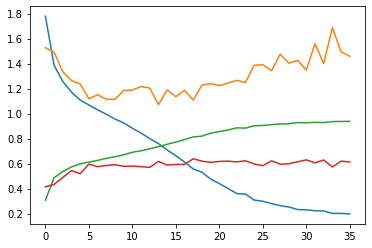

In [11]:
plt.plot(hist)

In [12]:
best_acc

0.6390086206896551

In [9]:
model = torch.load('/tf/data/Quan/fer2013/att_vgg_demo_2_facedetector.pt')

In [11]:
device = torch.device('cuda')

# EVALUATE
model.eval()
running_valloss = 0.0
running_valacc = 0.0
for i,data in enumerate(test_loader):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model(inputs)
    acc = float((torch.argmax(outputs, dim=1) == labels).float().sum()/labels.size(0))
    loss = criterion(outputs, labels)

    running_valloss += loss.item()
    running_valacc += acc

print('- Avg. val_loss: %.3f  | Avg. val_acc: %.3f' % (running_valloss / (i+1), running_valacc / (i+1)))

- Avg. val_loss: 1.109  | Avg. val_acc: 0.628
